# <span style="color:orange"> **Anime 1: Estimación de ratings en animes**

## <span style="color:#87CEEB"> **1.- Resumen**
    Problema: La empresa nos pide crear un sistema que ayude a estimar el puntaje que una serie/película debería tener dadas sus características.

    Solucion Propuesta: Modelo predictivo de regresión.

    Vector Objetivo: Variable 'rating'.

    Dataset: anime.csv

        * anime_id: Identificador único del anime.
        * name: Nombre completo del anime.
        * genre: Lista de géneros (separados por coma) en el que califica el anime.
        * type: Tipo de presentación del anime, puede ser: movie, TV, OVA, etc.
        * episodes: Número de episodios del anime (1 para el caso películas).
        * rating: Evaluación promedio del anime.
        * members: Número de miembros de la comunidad que están en el “grupo” del anime.

## <span style="color:#87CEEB"> **2.- Aspectos computacionales**

### <span style="color:#87CEEB"> 2.1.- Librerías

In [1]:
# Ingesta
import numpy as np
import pandas as pd
import scipy.stats as stats

# Preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# Visualización
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
import missingno as msngo
import matplotlib.gridspec as gridspec

from imblearn.over_sampling import SVMSMOTE # Balancear datos

# Modelación
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

# Métricas de evaluación
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Otros
import pickle
import time
import warnings
warnings.filterwarnings("ignore")

### <span style="color:#87CEEB"> 2.2.- Funciones

In [2]:
# Observacion de nulos
from funciones import print_column_info # Imprime metodo .info
from funciones import estudio_nulos
from funciones import porcentaje_nulos_en_df
from funciones import nulos_en_variable  
from funciones import graficar_nulos_total  
from funciones import graficar_nulos 
from funciones import imputar_nulos # imputa nulos porla moda

# Análisis descriptivo
from funciones import graficar_cont
from funciones import dataframe_behaviour_univariate # grafica comportamiendo del dataframe
from funciones import dataframe_behaviour_multivariate # grafica comportamiendo del dataframe
from funciones import graficar_dispersion # grafica la dispersión para las variables Members, Episodes vs Rating
from funciones import dataframe_scaler # escalador de dataframe
from funciones import mostrar_estandarizacion
from funciones import dataframe_sin_outliers # tratamiento de outliers
from funciones import comparacion_correlaciones # heatmap de correlaciones
from funciones import creacion_rangos
from funciones import graficar_error # gráfico múltiple del error

# Premodelación
from funciones import probar_modelos # modela, predice e imprime resultados MAPE, MAE y R2
from pre_proceso import standard_outlier_dummies_gen #aplica preproceso y genera matriz con dummies
from funciones import escalador_simple #escala una matriz usando standardscaler

# Modelación
from funciones import graficar_metricas
from funciones import convertir_a_string
from funciones import graficar_importancia
from funciones import resultados_modelacion_sqrt
from funciones import metricas_transformacion_inversa


# Otros
from funciones import df1_vs_df2

## <span style="color:#87CEEB"> **3.- Ingeniería de Datos**

### <span style="color:#87CEEB"> 3.1.- Importación de datos

In [3]:
# importación de base de datos
df = pd.read_csv('anime.csv', delimiter=';')

In [4]:
# Visualización simple de dataframe
display(df.head())
df.shape

anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes rating  \
0               Drama, Romance, School, Supernatural  Movie        1   9,37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64   9,26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51   9,25   
3                                   Sci-Fi, Thriller     TV       24   9,17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51   9,16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

(12294, 7)

### <span style="color:#87CEEB"> 3.2.- Comportamiento del vector objetivo

In [5]:
# tipo de dato
df['rating'].dtypes

dtype('O')

    El vector objetivo presenta valores numéricos pero su tipo de dato es 'objeto'.

In [6]:
# visualización de algunos valores del vector objetivo
df['rating'].unique()[:6]

array([' 9,37', ' 9,26', ' 9,25', ' 9,17', ' 9,16', ' 9,15'], dtype=object)

In [7]:
# cantidad de valores únicos en el vector objetivo
len(df['rating'].unique())

599

In [8]:
# tranformación de tipo de dato de 'str' a 'float'
df['rating'] = df['rating'].str.replace(',', '.').astype(float)

# Comprobación de transformación correcta
df['rating'].unique()[:10]

array([9.37, 9.26, 9.25, 9.17, 9.16, 9.15, 9.13, 9.11, 9.1 , 9.06])

#### <span style="color:orange"> Cantidad de nulos en el vector objetivo

In [9]:
# cantidad de datos nulos en vector objetivo
nulos_en_variable(df, 'rating')

Cantidad:
 False    12064
True       230
Name: rating, dtype: int64 
 ------------------------------
Porcentaje:
 False    98.13
True      1.87
Name: rating, dtype: float64


#### <span style="color:orange"> Distribución de nulos en el vector objetivo

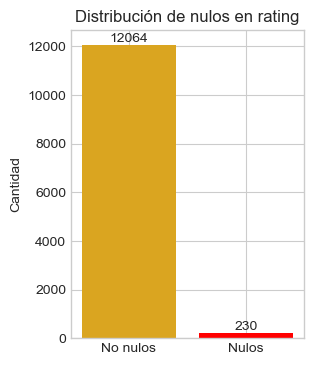

In [10]:
graficar_nulos(df, 'rating')

    Se observa que el vector objetivo presenta 230 valores nulos. Estos serán separados del dataframe original y se utilizarán más adelante como muestra a predecir una vez se haya encontrado un modelo eficaz.
    En etapas posteriores se realizará este proceso.

##### <span style="color:orange"> Estadísticas descriptivas del vector objetivo

In [11]:
df['rating'].describe()

count    12064.000000
mean         6.473902
std          1.026746
min          1.670000
25%          5.880000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

### <span style="color:#87CEEB"> 3.3.- Comportamiento de los atributos

#### <span style="color:#87CEEB"> 3.3.1.- Variable 'name'

##### <span style="color:orange"> Cantidad de nombres de anime

In [12]:
# Cantidad de nombres de anime
print('Cantidad total de observaciones en name:', len(df['name']))
print('Cantidad de valores únicos en name:', len(df['name'].unique()))
df['name'].value_counts()

Cantidad total de observaciones en name: 12294
Cantidad de valores únicos en name: 12292


Shi Wan Ge Leng Xiaohua                           2
Saru Kani Gassen                                  2
Bakabon Osomatsu no Karee wo Tazunete Sansenri    1
Backkom Meogeujan Yeohaeng                        1
Backkom Mission Impossible                        1
                                                 ..
Yoroiden Samurai Troopers Kikoutei Densetsu       1
Yuu☆Yuu☆Hakusho: Mu Mu Hakusho                    1
3-gatsu no Lion meets Bump of Chicken             1
Bannou Bunka Neko-Musume                          1
Yasuji no Pornorama: Yacchimae!!                  1
Name: name, Length: 12292, dtype: int64

In [13]:
display(df[df['name'] == 'Shi Wan Ge Leng Xiaohua'])
display(df[df['name'] == 'Saru Kani Gassen'])

anime_id                     name  \
10193     33193  Shi Wan Ge Leng Xiaohua   
10194     33195  Shi Wan Ge Leng Xiaohua   

                                            genre   type episodes  rating  \
10193                              Comedy, Parody    ONA       12    6.67   
10194  Action, Adventure, Comedy, Fantasy, Parody  Movie        1    7.07   

       members  
10193      114  
10194      110

anime_id              name  genre   type episodes  rating  members
10140     22399  Saru Kani Gassen   Kids    OVA        1    5.23       62
10141     30059  Saru Kani Gassen  Drama  Movie        1    4.75       76

    Se observa que 'Shi Wan Ge Leng Xiaohua' y 'Saru Kani Gassen' tienen dos observaciones cada uno, pero se diferencian en el tipo de anime. Debido a esto el atributo 'name' tiene una cantidad total de 12294 observaciones pero 12292 valores únicos.

##### <span style="color:orange"> Cantidad de nulos en 'name'

In [14]:
# cantidad de datos nulos en 'name'
nulos_en_variable(df, 'name')

Cantidad:
 False    12294
Name: name, dtype: int64 
 ------------------------------
Porcentaje:
 False    100.0
Name: name, dtype: float64


    No existen datos nulos en la variable 'name'.

#### <span style="color:#87CEEB"> 3.3.2.- Variable 'genre'

##### <span style="color:orange"> Géneros únicos de anime

In [15]:
df['genre'].str.get_dummies(', ').columns

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dark Fantasy', 'Dementia',
       'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Idol', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Sclice of Life', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen',
       'Shounen Ai', 'Slice of Life', 'Space', 'Sports', 'Super Power',
       'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object')

    Al separar de manera independiente todos los géneros existentes, se observa que existe una discrepancia para 'Slice of Life'. Es por esto que se implementa una recodificación para corregir este error.

In [16]:
# recodificación de 'Slice of Life'
df['genre'] = df['genre'].str.replace('Sclice of Life', 'Slice of Life')

# Comprobación de correcta recodificación
df['genre'].str.get_dummies(', ').columns

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dark Fantasy', 'Dementia',
       'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Idol', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery', 'Parody',
       'Police', 'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Vampire', 'Yaoi', 'Yuri'],
      dtype='object')

##### <span style="color:orange"> Combinaciones de géneros de anime

In [17]:
# cantidad de combinaciones de géneros
print('Cantidad de combinaciones de géneros:\n', len(df['genre'].value_counts()))
df['genre'].value_counts()

Cantidad de combinaciones de géneros:
 3271


Hentai                                                    823
Comedy                                                    523
Music                                                     302
Kids                                                      199
Comedy, Slice of Life                                     179
                                                         ... 
Historical, Mystery                                         1
Drama, Fantasy, Mystery, Romance, Supernatural              1
Comedy, Magic, Parody, Police, Sci-Fi, Shounen, Space       1
Action, Comedy, Fantasy, Martial Arts, Shounen, Sports      1
Hentai, Slice of Life                                       1
Name: genre, Length: 3271, dtype: int64

##### <span style="color:orange"> Cantidad de nulos en 'genre'

In [18]:
# cantidad de datos nulos en 'genre'
nulos_en_variable(df, 'genre')

Cantidad:
 False    12247
True        47
Name: genre, dtype: int64 
 ------------------------------
Porcentaje:
 False    99.62
True      0.38
Name: genre, dtype: float64


    Existen 47 datos nulos en 'genre' lo que equivale a 0.38% del total de datos.

#### <span style="color:orange"> Distribución de nulos en 'genre'

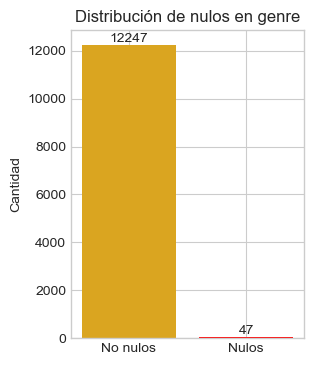

In [19]:
graficar_nulos(df, 'genre')

#### <span style="color:#87CEEB"> 3.3.3.- Variable 'type'

##### <span style="color:orange"> Tipos únicos de anime

In [20]:
df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan], dtype=object)

##### <span style="color:orange"> Cantidad de tipos de anime

In [21]:
df['type'].value_counts()

TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: type, dtype: int64

##### <span style="color:orange"> Cantidad de nulos en 'type'

In [22]:
# cantidad de datos nulos en 'type'
nulos_en_variable(df, 'type')

Cantidad:
 False    12269
True        25
Name: type, dtype: int64 
 ------------------------------
Porcentaje:
 False    99.8
True      0.2
Name: type, dtype: float64


    Existen 25 datos nulos en 'type' lo que equivale a 0.2% del total de datos.

#### <span style="color:orange"> Distribución de nulos en 'type'

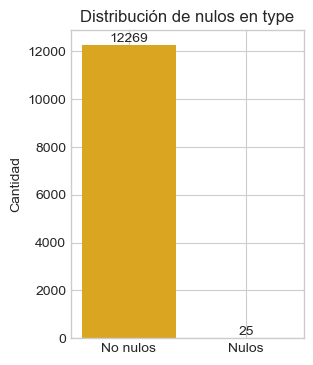

In [23]:
graficar_nulos(df, 'type')

#### <span style="color:#87CEEB"> 3.3.4.- Variable 'episodes'

##### <span style="color:orange"> Tipo de dato de 'episodes'

In [24]:
display(df['episodes'].dtype)
df['episodes'].unique()

dtype('O')

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

In [25]:
df['episodes'][df['episodes'] == 'Unknown'].value_counts()

Unknown    340
Name: episodes, dtype: int64

    Se observó que el tipo de dato es 'str' y que además existe el valor 'Unknown'. Dado lo anterior se procede a cambiar el tipo de dato y recodificar los valores 'Unknown' como np.nan

In [26]:
# Recodificación de 'Unknown' y transformación del tipo de dato
df['episodes'] = np.where(df['episodes'] == 'Unknown', np.nan, df['episodes'])
df['episodes'] = df['episodes'].astype(float)

##### <span style="color:orange"> Estadísticas descriptivas de 'episodes'

In [27]:
df['episodes'].describe().round(2)

count    11954.00
mean        12.38
std         46.87
min          1.00
25%          1.00
50%          2.00
75%         12.00
max       1818.00
Name: episodes, dtype: float64

##### <span style="color:orange"> Frecuencia de cantidad de episodios de anime

In [28]:
df['episodes'].value_counts()

1.0      5677
2.0      1076
12.0      816
13.0      572
26.0      514
         ... 
330.0       1
291.0       1
276.0       1
120.0       1
125.0       1
Name: episodes, Length: 186, dtype: int64

##### <span style="color:orange"> Cantidad de nulos en 'episodes'

In [29]:
# cantidad de datos nulos en 'episodes'
nulos_en_variable(df, 'episodes')

Cantidad:
 False    11954
True       340
Name: episodes, dtype: int64 
 ------------------------------
Porcentaje:
 False    97.23
True      2.77
Name: episodes, dtype: float64


#### <span style="color:orange"> Distribución de nulos en 'episodes'

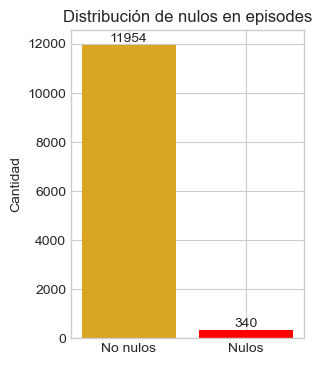

In [30]:
graficar_nulos(df, 'episodes')

#### <span style="color:#87CEEB"> 3.3.5.- Variable 'members'

##### <span style="color:orange"> Tipo de dato de 'members'

In [31]:
display(df['members'].dtype)
df['members'].unique()

dtype('int64')

array([200630, 793665, 114262, ...,  27411,  57355,    652], dtype=int64)

##### <span style="color:orange"> Estadísticas descriptivas de 'members'

In [32]:
df['members'].describe().round(2)

count      12294.00
mean       18071.34
std        54820.68
min            5.00
25%          225.00
50%         1550.00
75%         9437.00
max      1013917.00
Name: members, dtype: float64

##### <span style="color:orange"> Cantidad de nulos en 'members'

In [33]:
# cantidad de datos nulos en 'members'
nulos_en_variable(df, 'members')

Cantidad:
 False    12294
Name: members, dtype: int64 
 ------------------------------
Porcentaje:
 False    100.0
Name: members, dtype: float64


## <span style="color:#87CEEB"> **4.- Tratamiento de datos nulos**

### <span style="color:#87CEEB"> 4.1.- Imputación de nulos

#### <span style="color:#87CEEB"> 4.1.1.- Porcentaje de nulos en el dataset

In [34]:
# porcentaje de filas con nulos en el dataframe
porcentaje_nulos_en_df(df, df.columns)

Porcentaje de nulos:
----------------------------
anime_id: No contiene nulos
name: No contiene nulos
genre: 0.3823 %
type: 0.2034 %
episodes: 2.7656 %
rating: 1.8708 %
members: No contiene nulos
---------------------------- 
Porcentaje de filas con nulos en el dataset: 3.7742 %


##### <span style="color:orange"> Visualización de nulos

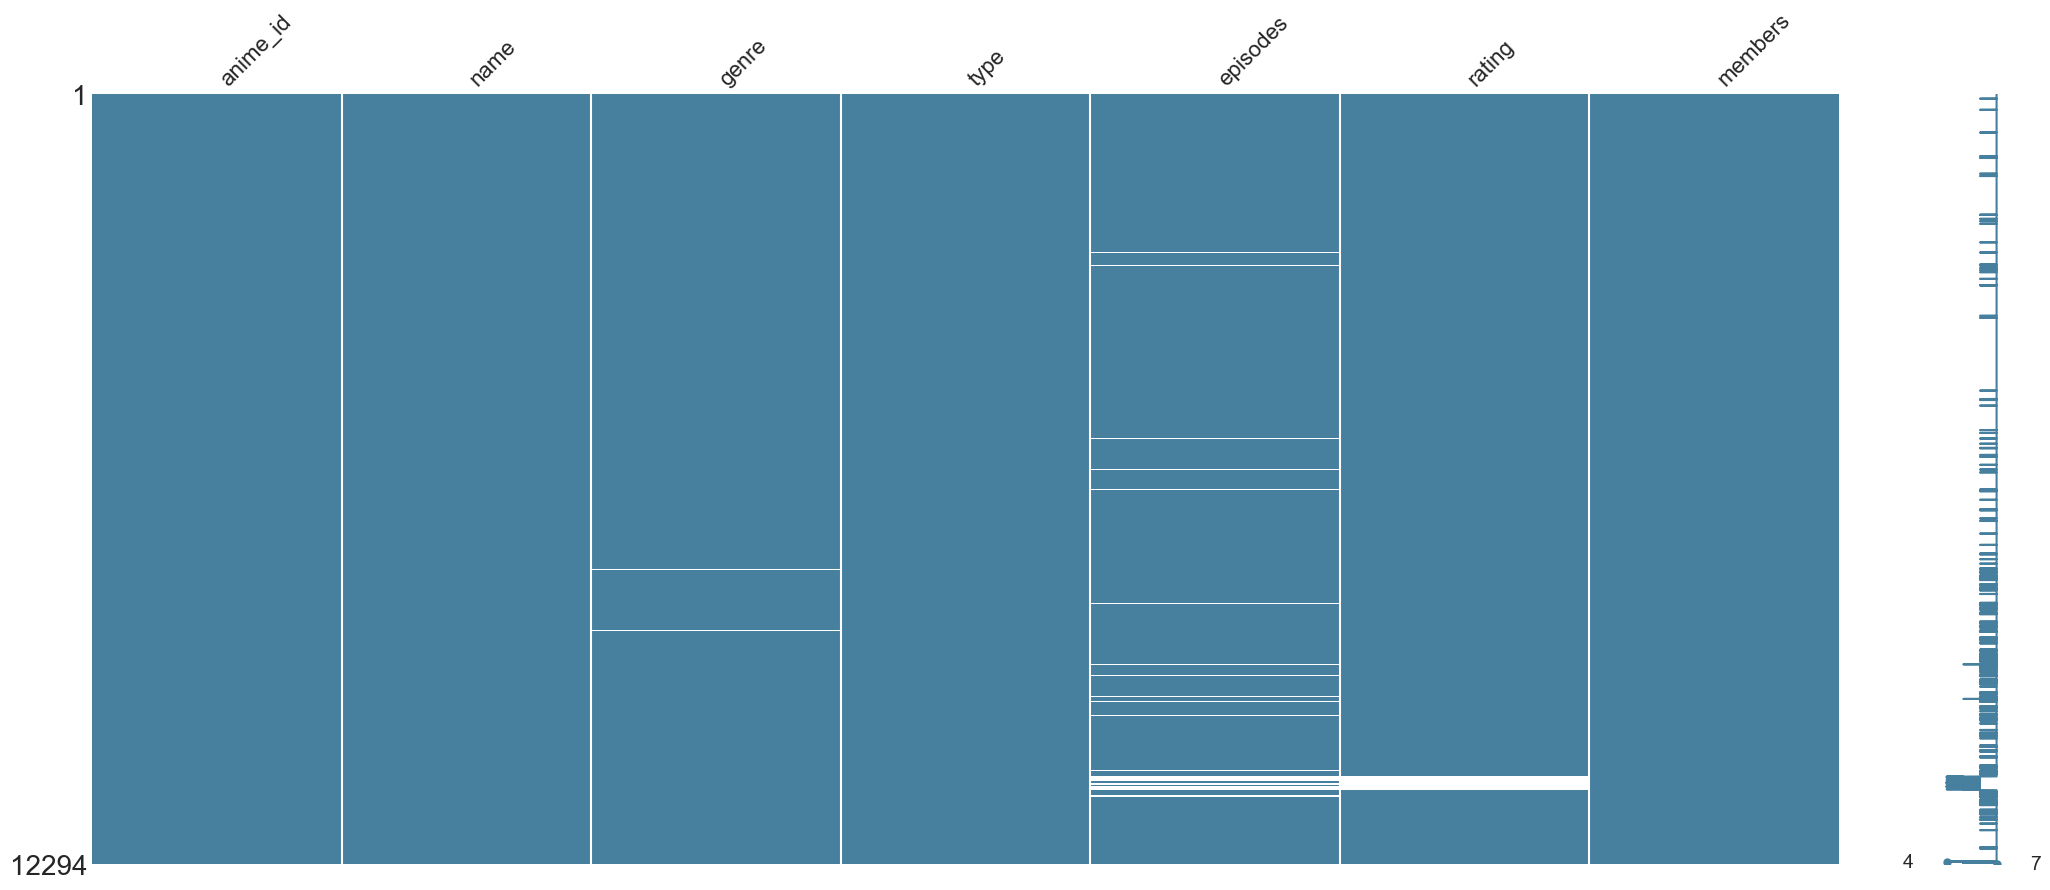

In [35]:
msngo.matrix(df, color=(0.28, 0.5, 0.62))
plt.show()

    Con este gráfico es posible observar que lo mostrado anteriormente concuerda con lo calculado. La variable 'episodes' y el vector objetivo 'rating' presentan mayor cantidad de nulos.

#### <span style="color:#87CEEB"> 4.1.2.- Imputación de nulos por la moda o más frecuente.

In [36]:
df_tmp, imputer_fit = imputar_nulos(df.drop('rating', axis=1))
df_imputado = pd.concat([df_tmp, df['rating']], axis=1)
del df_tmp
df_imputado.tail(10)

anime_id                                               name  \
12284     26031                                 Super Erotic Anime   
12285     34399                                   Taimanin Asagi 3   
12286     10368                                Teleclub no Himitsu   
12287      9352                             Tenshi no Habataki Jun   
12288      5541                                   The Satisfaction   
12289      9316       Toushindai My Lover: Minami tai Mecha-Minami   
12290      5543                                        Under World   
12291      5621                     Violence Gekiga David no Hoshi   
12292      6133  Violence Gekiga Shin David no Hoshi: Inma Dens...   
12293     26081                   Yasuji no Pornorama: Yacchimae!!   

                              genre   type  episodes  members  rating  
12284                        Hentai    OVA       2.0      118    4.45  
12285  Demons, Hentai, Supernatural    OVA       1.0      485     NaN  
12286                        Hentai    OVA       2.0      148    4.67  
12287                        Hentai    OVA       1.0      201    4.33  
12288                        Hentai    OVA       1.0      166    4.37  
12289                        Hentai    OVA       1.0      211    4.15  
12290                        Hentai    OVA       1.0      183    4.28  
12291                        Hentai    OVA       4.0      219    4.88  
12292                        Hentai    OVA       1.0      175    4.98  
12293                        Hentai  Movie       1.0      142    5.46

In [37]:
# verificación de correcta imputación
porcentaje_nulos_en_df(df_imputado, df.columns)

Porcentaje de nulos:
----------------------------
anime_id: No contiene nulos
name: No contiene nulos
genre: No contiene nulos
type: No contiene nulos
episodes: No contiene nulos
rating: 1.8708 %
members: No contiene nulos
---------------------------- 
Porcentaje de filas con nulos en el dataset: 1.8708 %


In [38]:
df_imputado.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes    float64
members       int64
rating      float64
dtype: object

##### <span style="color:orange"> Visualización de nulos post imputación

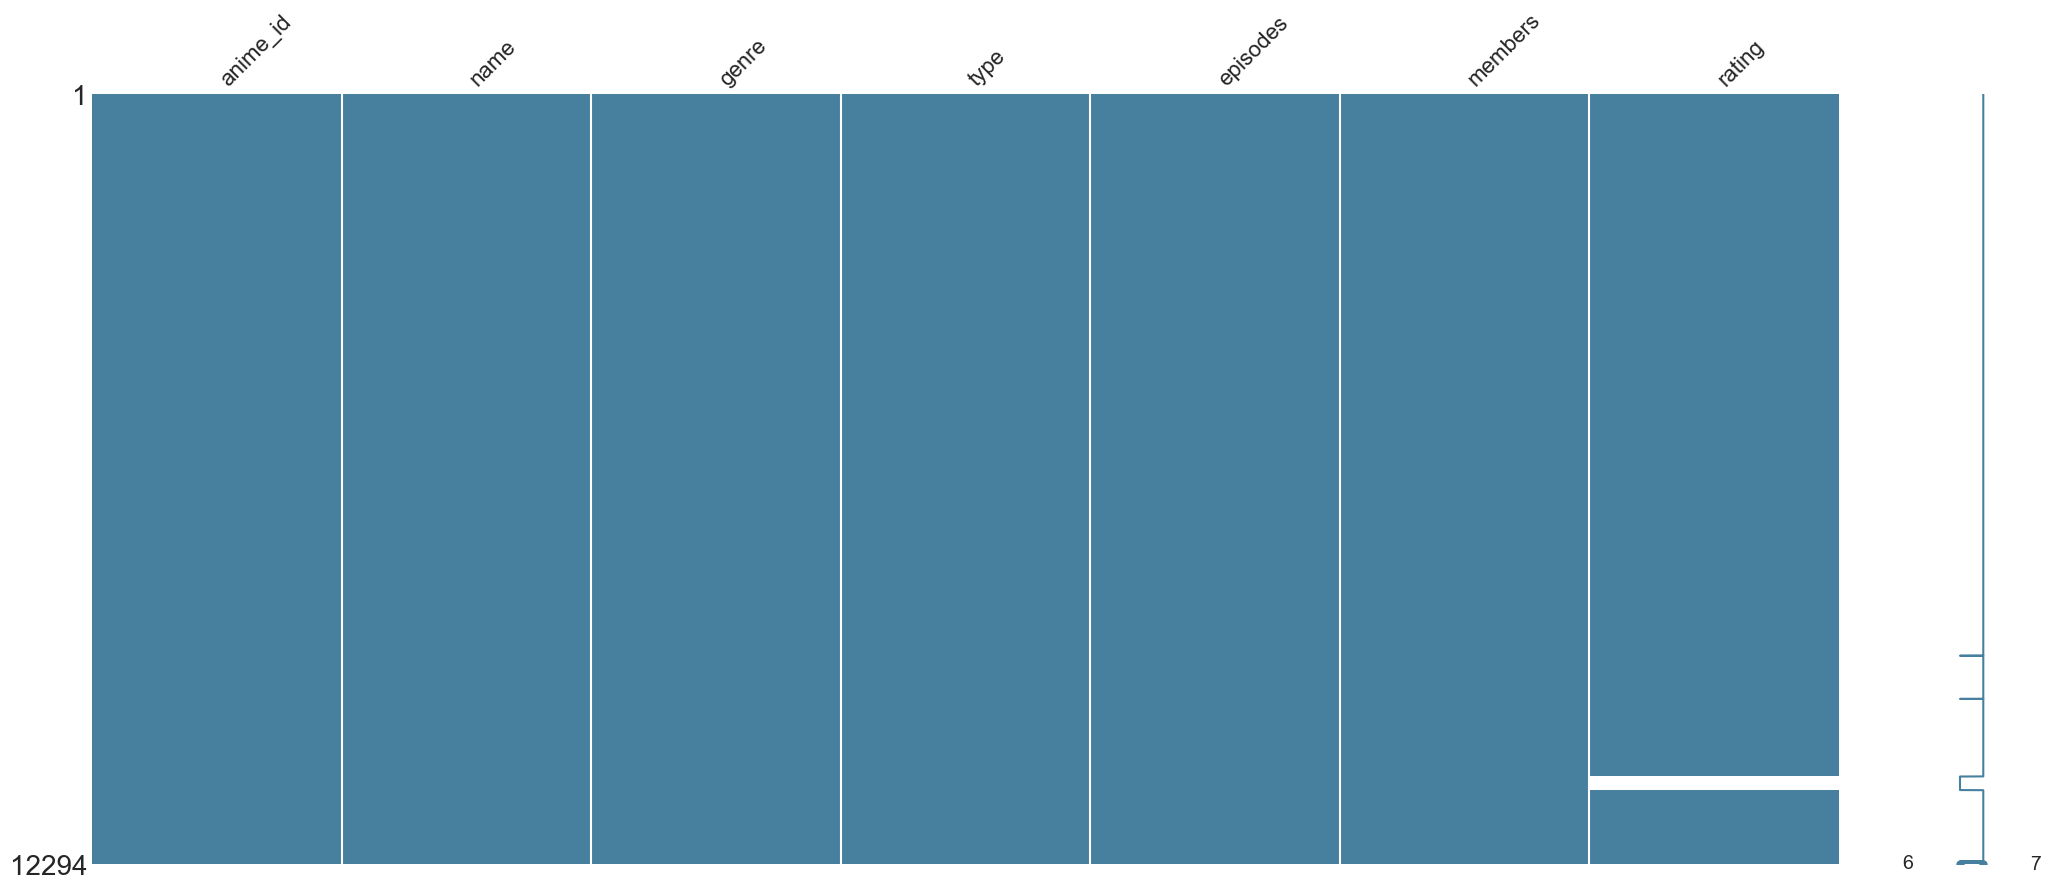

In [39]:
msngo.matrix(df_imputado, color=(0.28, 0.5, 0.62))
plt.show()

    Se corrobora visualmente que la imputación de nulos se realizó de manera correcta para los atributos.

### <span style="color:#87CEEB"> 4.2.- Separación de nulos en el vector objetivo

In [40]:
df_test_nulos = df_imputado[df_imputado['rating'].isna()].drop('anime_id', axis=1)
display(df_test_nulos.columns)
df_test_nulos.shape

Index(['name', 'genre', 'type', 'episodes', 'members', 'rating'], dtype='object')

(230, 6)

    'df_test_nulos' contiene todas las columnas pero solo considera aquellas observaciones en que el vector objetivo contiene datos nulos.

    Estos datos serán usados como validación una vez se tengan los mejores modelos.

### <span style="color:#87CEEB"> 4.3.- Eliminación de datos nulos

In [41]:
df_clean = df_imputado.dropna().reset_index(drop=True).drop('anime_id', axis=1)

    Se eliminan los datos nulos y se deja de lado la variable 'anime_id', dado que consideramos que no aporta información relevante al entregar un número identificador.

### <span style="color:#87CEEB"> 4.4.- Guardado de dataframe imputado en archivo .csv

In [42]:
df_clean.to_csv('anime_clean.csv', index=False)

## <span style="color:#87CEEB"> **5.- Preprocesamiento dataframe imputado**

### <span style="color:#87CEEB"> 5.1.- Medidas de tendencia central

    Medidas de Tendencia Central: Media, Mediana.
    Indicador estadístico: percentiles.
    Medidas de Dispersión: Desv. estd.
    Graficar distribución de atributos categóricos.
    Comportamiento y outliers: Boxplot.
    Definir medidas:
    Eliminar (máximo 1,2%).
    Estandarizar.
    Evaluar sesgos: over sampling.
    Graficar correlaciones entre V.O. y atributos continuos.


##### <span style="color:orange"> Creación de diccionario para guardar Dataframes

In [43]:
# diccionario para guardar dataframes
diccionario_dataframes = {}

# se agrega df_clean a diccionario_dataframes
diccionario_dataframes['df_clean'] = df_clean

mostrar_estandarizacion(df_clean)

name  \
0                    Kimi no Na wa.   
1  Fullmetal Alchemist: Brotherhood   
2                          Gintama°   

                                               genre   type  episodes  \
0               Drama, Romance, School, Supernatural  Movie       1.0   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV      64.0   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV      51.0   

   members  rating  
0   200630    9.37  
1   793665    9.26  
2   114262    9.25

(12064, 6)

In [44]:
var_continuas = ['episodes', 'members', 'rating']

In [45]:
df_clean[var_continuas].describe(percentiles=[.25,.50,.75,.80,.90, .95]).round()

episodes    members   rating
count   12064.0    12064.0  12064.0
mean       12.0    18280.0      6.0
std        47.0    55276.0      1.0
min         1.0       12.0      2.0
25%         1.0      221.0      6.0
50%         2.0     1539.0      7.0
75%        12.0     9486.0      7.0
80%        13.0    15114.0      7.0
90%        26.0    45838.0      8.0
95%        51.0    94363.0      8.0
max      1818.0  1013917.0     10.0

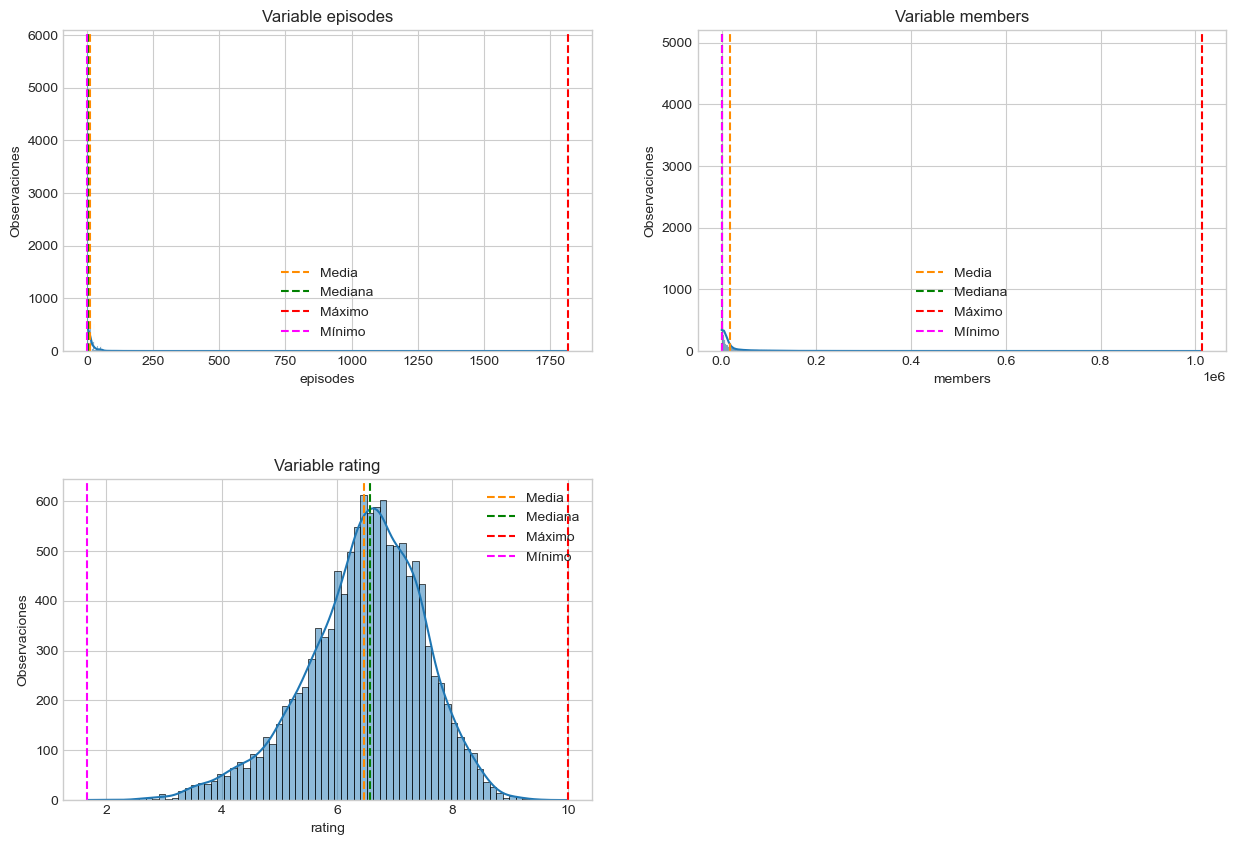

In [46]:
graficar_cont(df_clean, var_continuas,
            figura=(15,10), sep_plot=0.4, cols=2)

    Rating
    * Se observa una distribución de las valoraciones similar a la normal, con una leve tendencia a puntajes sobre la media.
    
    Members
    * Se observa una gran presencia de outliers, y sesgo a los valores bajos. Se ahondará en su comportamiento mediante boxplots


### <span style="color:#87CEEB"> 5.2.- Estandarización

In [47]:
var_a_escalar = ['episodes','members']
var_sin_escalar = ['name', 'genre', 'type', 'rating']

    Para los gráficos mostrados a continuación, el vector objetivo 'rating' tendrá la misma distribución dado que se estandarizaron los atributos continuos.

#### <span style="color:#87CEEB"> 5.2.1.- Estandarización con StandardScaler()

In [48]:
df_standard, std_scaler = dataframe_scaler(df_clean, StandardScaler(), var_a_escalar, var_sin_escalar)

# se agrega df_standard a diccionario_dataframes
diccionario_dataframes['df_standard'] = df_standard

mostrar_estandarizacion(df_standard)

name  \
0                    Kimi no Na wa.   
1  Fullmetal Alchemist: Brotherhood   
2                          Gintama°   

                                               genre   type  episodes  \
0               Drama, Romance, School, Supernatural  Movie -0.241496   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV  1.108613   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV  0.830019   

     members  rating  
0   3.299058    9.37  
1  14.028161    9.26  
2   1.736501    9.25

(12064, 6)

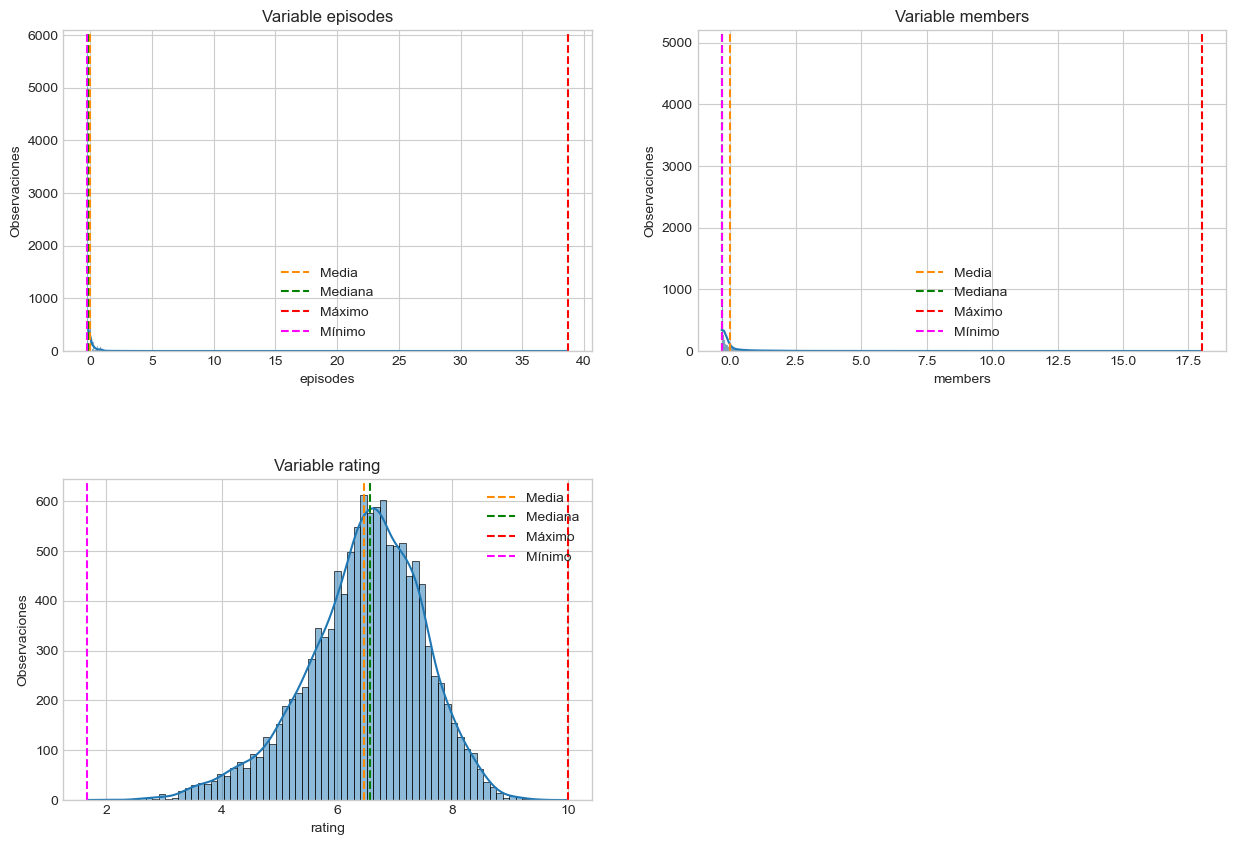

In [49]:
graficar_cont(df_standard, var_continuas,
            figura=(15,10), sep_plot=0.4, cols=2)

#### <span style="color:#87CEEB"> 5.2.2.- Estandarización con RobustScaler()

In [50]:
df_robust, rbst_scaler = dataframe_scaler(df_clean, RobustScaler(), var_a_escalar, var_sin_escalar)

# se agrega df_robust a diccionario_dataframes
diccionario_dataframes['df_robust'] = df_robust

mostrar_estandarizacion(df_robust)

name  \
0                    Kimi no Na wa.   
1  Fullmetal Alchemist: Brotherhood   
2                          Gintama°   

                                               genre   type  episodes  \
0               Drama, Romance, School, Supernatural  Movie -0.090909   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV  5.636364   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV  4.454545   

     members  rating  
0  21.489665    9.37  
1  85.501214    9.26  
2  12.167197    9.25

(12064, 6)

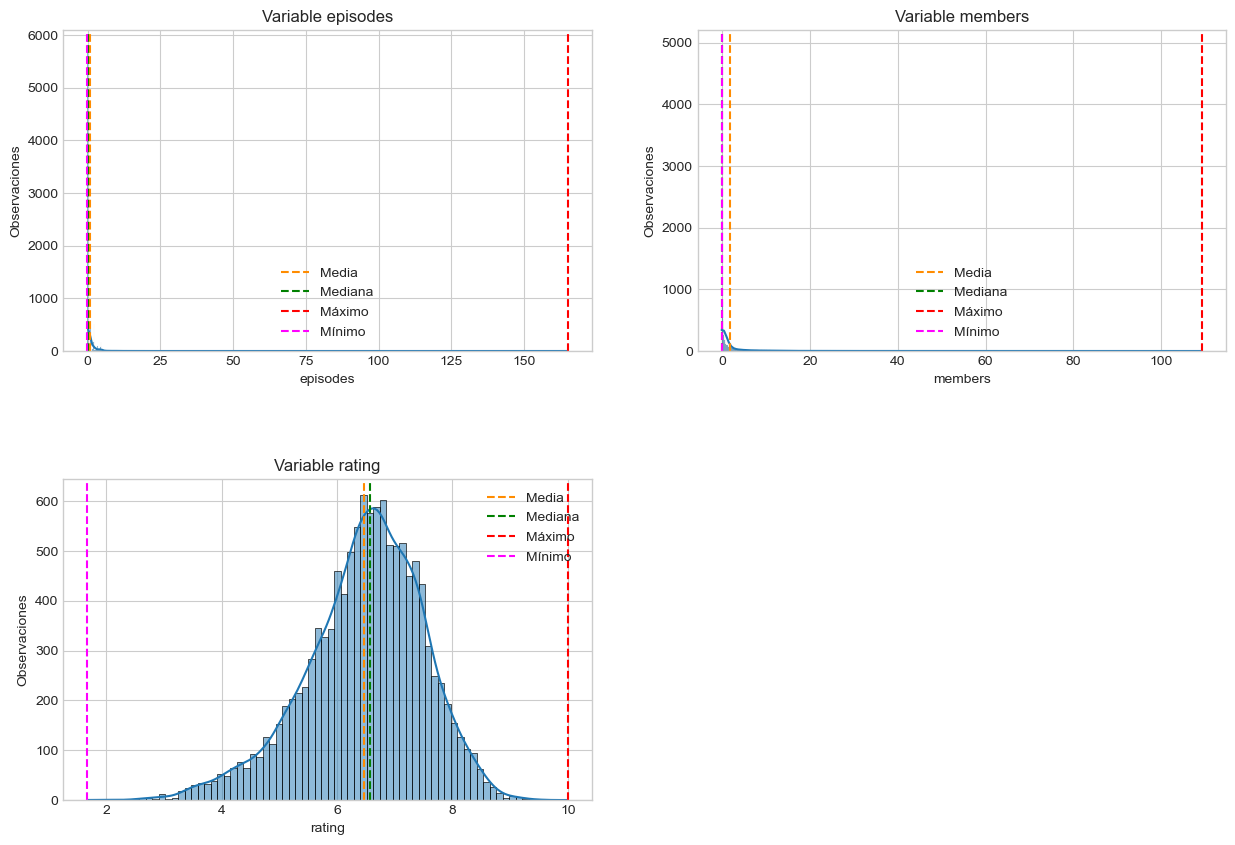

In [51]:
graficar_cont(df_robust, var_continuas,
            figura=(15,10), sep_plot=0.4, cols=2)

    Para las estandarizaciones con StandardScaler y RobustScaler la distribución de los atributos continuos es similar. En estas se observan mayores concentraciones hacia los valores bajos. Esto se ve reflejado en los valores de la media y la mediana que también se encuentran en estos valores.
    
    Al comparar con el dataframe original (df_clean) la diferencia más notoria radica en la disminución en el rango de las variables, no así en su distribución.

#### <span style="color:#87CEEB"> 5.2.3.- Estandarización con logaritmo

In [52]:
df_log = dataframe_scaler(df_clean, np.log, var_a_escalar, var_sin_escalar)

# se agrega df_log a diccionario_dataframes
diccionario_dataframes['df_log'] = df_log

mostrar_estandarizacion(df_log)

name  \
0                    Kimi no Na wa.   
1  Fullmetal Alchemist: Brotherhood   
2                          Gintama°   

                                               genre   type  episodes  \
0               Drama, Romance, School, Supernatural  Movie  0.001000   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV  4.158899   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV  3.931845   

     members  rating  
0  12.209218    9.37  
1  13.584417    9.26  
2  11.646249    9.25

(12064, 6)

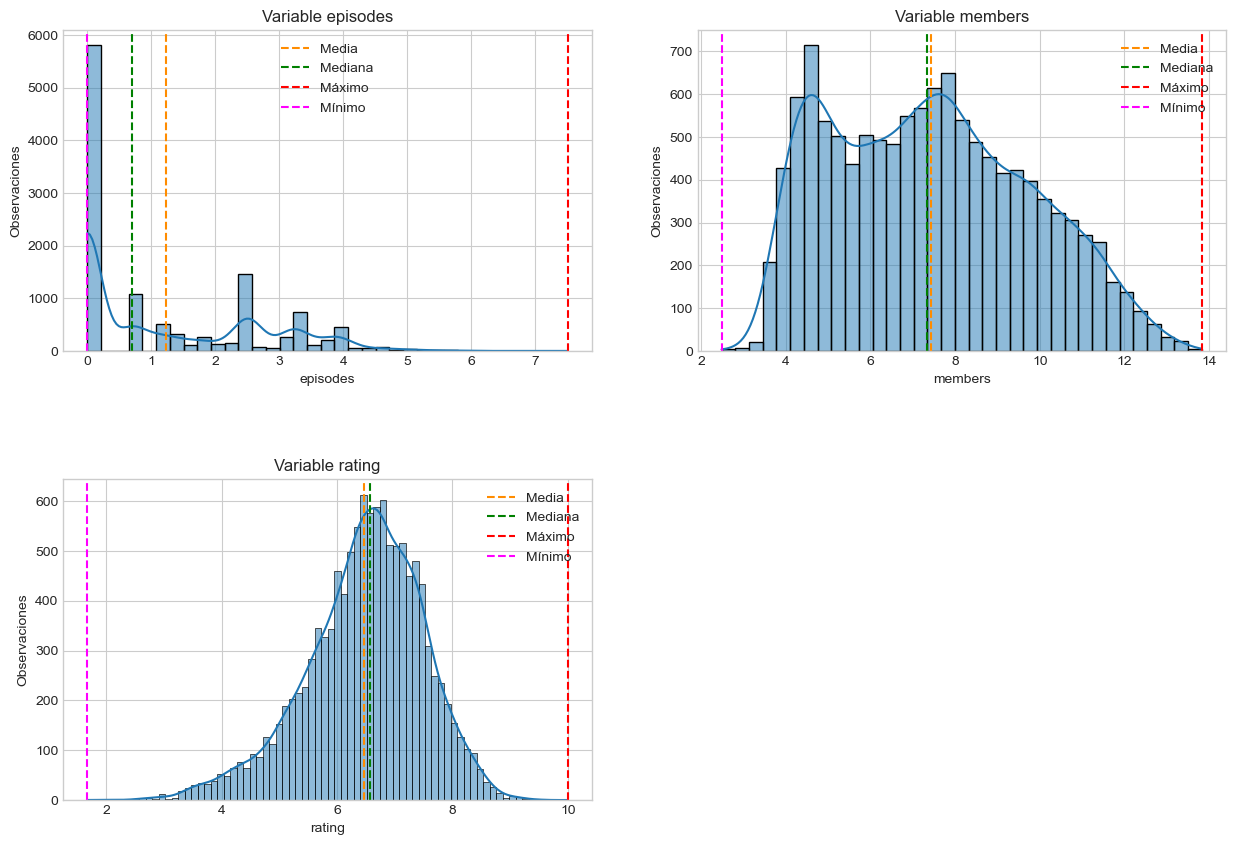

In [53]:
graficar_cont(df_log, var_continuas,
            figura=(15,10), sep_plot=0.4, cols=2)

    Al aplicar logaritmo a las variables continuas, se observa un cambio notorio en la distribución de estas al compararlas con las estandarizaciones anteriores.
    En este caso el rango es mucho más acotado para ambas variables y es posible apreciar de mejor manera el comportamiento que estas tienen.
    En el caso de la variable episodes se observa una alta concentración de observaciones para valores entre 0 y 1.
    Para la variable members, se observan dos máximos; el primero entre 4 y 5, y el segundo cercano a 8.

    Recordar:
    Como se aplicó logaritmo la escala de los datos es menor.

#### <span style="color:#87CEEB"> 5.2.4.- Estandarización con raíz cuadrada

In [54]:
df_sqrt = dataframe_scaler(df_clean, np.sqrt, var_a_escalar, var_sin_escalar)

# se agrega df_sqrt a diccionario_dataframes
diccionario_dataframes['df_sqrt'] = df_sqrt

mostrar_estandarizacion(df_sqrt)

name  \
0                    Kimi no Na wa.   
1  Fullmetal Alchemist: Brotherhood   
2                          Gintama°   

                                               genre   type  episodes  \
0               Drama, Romance, School, Supernatural  Movie  1.000500   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV  8.000062   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV  7.141498   

      members  rating  
0  447.917404    9.37  
1  890.878780    9.26  
2  338.026628    9.25

(12064, 6)

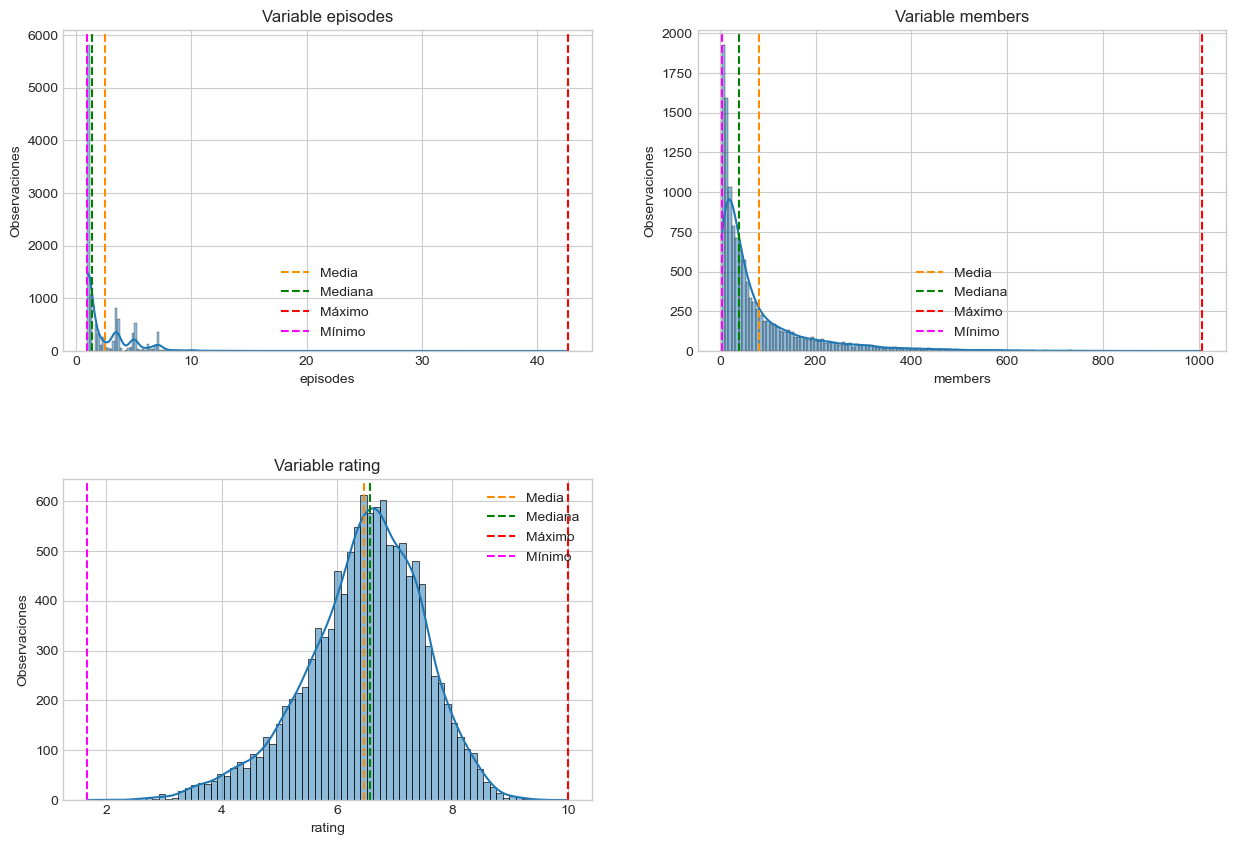

In [55]:
graficar_cont(df_sqrt, var_continuas,
            figura=(15,10), sep_plot=0.4, cols=2)

    Al aplicar raíz cuadrada a las variables continuas, y de manera similar a lo ocurrido con logaritmo, se observa un cambio notorio en la distribución de estas al compararlas con las estandarizaciones StandardScaler y RobustScaler. Sin embargo, en este caso la distribución es diferente a sus predecesores.
    En ambas variables se observa una alta concentración de observaciones en valores bajos, la que va disminuyendo parcialmente a medida que se avanza en el rango.

### <span style="color:#87CEEB"> 5.3.- Drop Outliers

    Aproximadamente el 68% de los datos se encuentran dentro de una desviación estándar de la media.
    Aproximadamente el 95% de los datos se encuentran dentro de dos desviaciones estándar de la media.
    Aproximadamente el 99.7% de los datos se encuentran dentro de tres desviaciones estándar de la media.

    Se utilizan 3 desviaciones estándar como criterio de selección.

#### <span style="color:#87CEEB"> 5.3.1.- Dataframe limpio (df_clean)

In [56]:
df_clean_sin_out = dataframe_sin_outliers(df_clean)

# se agrega df_clean_sin_out a diccionario_dataframes
diccionario_dataframes['df_clean_sin_out'] = df_clean_sin_out

df_clean_sin_out.shape

(11741, 6)

#### <span style="color:#87CEEB"> 5.3.2.- Dataframe con StandarScaler (df_standard_scaler)

In [57]:
df_std_sin_out = dataframe_sin_outliers(df_standard)

# se agrega df_std_sin_out a diccionario_dataframes
diccionario_dataframes['df_std_sin_out'] = df_std_sin_out
df_std_sin_out.shape

(11741, 6)

#### <span style="color:#87CEEB"> 5.3.3.- Dataframe con RobustScaler (df_robust)

In [58]:
df_robust_sin_out = dataframe_sin_outliers(df_robust)

# se agrega df_robust_sin_out a diccionario_dataframes
diccionario_dataframes['df_robust_sin_out'] = df_robust_sin_out

df_robust_sin_out.shape

(11741, 6)

#### <span style="color:#87CEEB"> 5.3.4.- Dataframe con Logaritmo (df_log)

In [59]:
df_log_sin_out = dataframe_sin_outliers(df_log)

# se agrega df_log_sin_out a diccionario_dataframes
diccionario_dataframes['df_log_sin_out'] = df_log_sin_out

df_log_sin_out.shape

(12033, 6)

#### <span style="color:#87CEEB"> 5.3.5.- Dataframe con Raíz cuadrada (df_sqrt)

In [60]:
df_sqrt_sin_out = dataframe_sin_outliers(df_sqrt)

# se agrega df_sqrt_sin_out a diccionario_dataframes
diccionario_dataframes['df_sqrt_sin_out'] = df_sqrt_sin_out

df_sqrt_sin_out.shape

(11608, 6)

In [61]:
# visualizaicón de dataframes guardados en diccionario_dataframes
for key in diccionario_dataframes.keys():
    print(key)

df_clean
df_standard
df_robust
df_log
df_sqrt
df_clean_sin_out
df_std_sin_out
df_robust_sin_out
df_log_sin_out
df_sqrt_sin_out


    Los dataframes mostrados serán con los que se implementarán los modelos listados posteriormente.

## <span style="color:#87CEEB"> **6.- Análisis descriptivo**

### <span style="color:#87CEEB"> 6.1.- Gráficos por atributos

https://public.tableau.com/app/profile/walther2215/viz/Anime-Anlisisdedatosbasecompleta/ProyectoDataScienceAnime1

### <span style="color:#87CEEB"> 6.2.- Análisis univariado

#### <span style="color:#87CEEB"> 6.2.1.- Dataframe limpio (df_clean) con y sin tratamiendo de outliers

In [62]:
df_clean.describe(percentiles=[.975])

episodes       members        rating
count  12064.000000  1.206400e+04  12064.000000
mean      12.268899  1.827952e+04      6.473902
std       46.664839  5.527578e+04      1.026746
min        1.000000  1.200000e+01      1.670000
50%        2.000000  1.539000e+03      6.570000
97.5%     59.425000  1.616732e+05      8.250000
max     1818.000000  1.013917e+06     10.000000

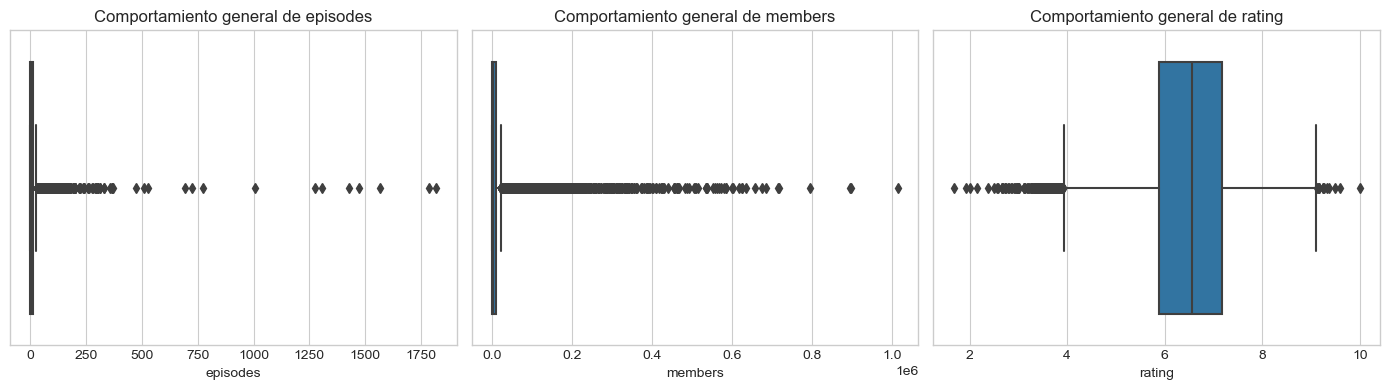

In [63]:
dataframe_behaviour_univariate(df_clean)

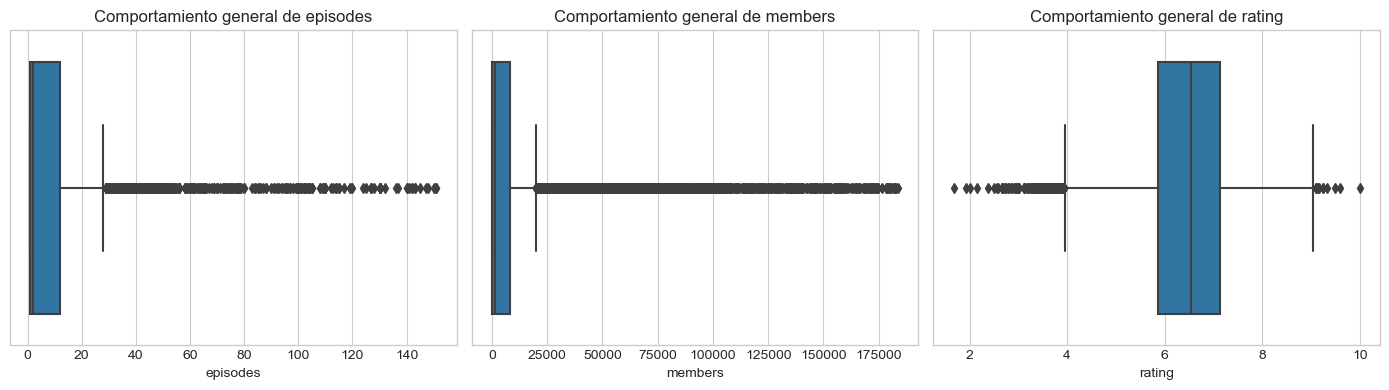

In [64]:
dataframe_behaviour_univariate(df_clean_sin_out)

    Se observa una leve mejora con respecto a la mediana, sin embargo aún persiste el alto sesgo y presencia de outliers en la muestra. Esto se debe a que mediante este criterio se elimina un bajo porcentaje de ellos.

#### <span style="color:#87CEEB"> 6.2.2.- Dataframe con StandarScaler (df_standard_scaler) con y sin tratamiendo de outliers

In [65]:
df_standard.describe(percentiles=[.975])

episodes       members        rating
count  1.206400e+04  1.206400e+04  12064.000000
mean  -4.476231e-17  1.884729e-17      6.473902
std    1.000041e+00  1.000041e+00      1.026746
min   -2.414959e-01 -3.304934e-01      1.670000
50%   -2.200656e-01 -3.028671e-01      6.570000
97.5%  1.010569e+00  2.594258e+00      8.250000
max    3.869736e+01  1.801293e+01     10.000000

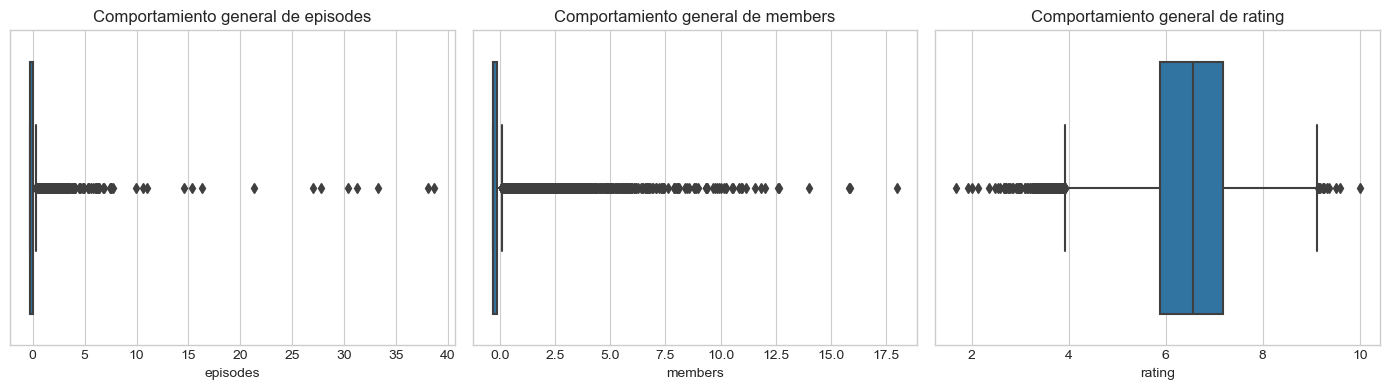

In [66]:
dataframe_behaviour_univariate(df_standard)

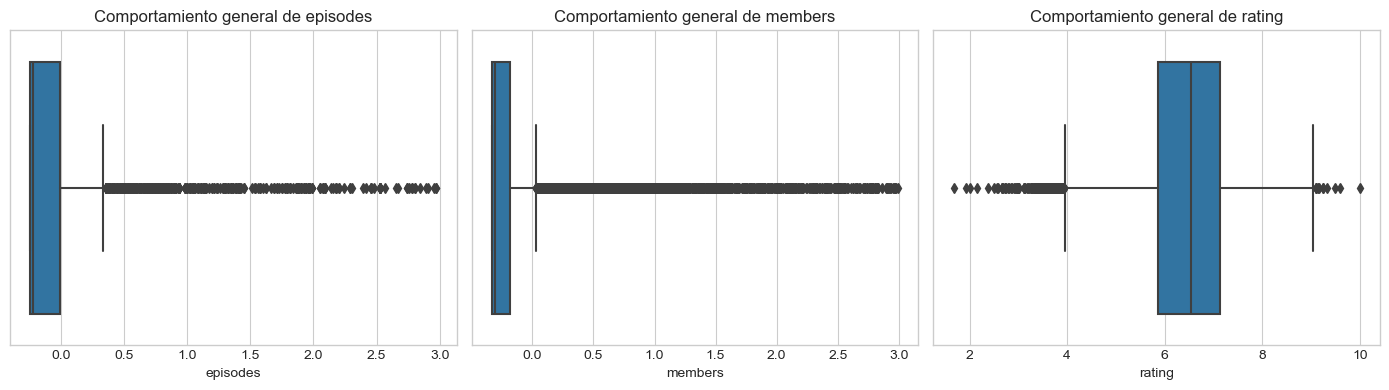

In [67]:
dataframe_behaviour_univariate(df_std_sin_out)

    Se observa una leve mejora con respecto a la mediana, sin embargo aún persiste el alto sesgo y presencia de outliers en la muestra. Esto se debe a que mediante este criterio se elimina un bajo porcentaje de ellos.

#### <span style="color:#87CEEB"> 6.2.3.- Dataframe con RobustScaler (df_robust) con y sin tratamiendo de outliers

In [68]:
df_robust.describe(percentiles=[.975])

episodes       members        rating
count  12064.000000  12064.000000  12064.000000
mean       0.933536      1.806954      6.473902
std        4.242258      5.966408      1.026746
min       -0.090909     -0.164823      1.670000
50%        0.000000      0.000000      6.570000
97.5%      5.220455     17.284716      8.250000
max      165.090909    109.274974     10.000000

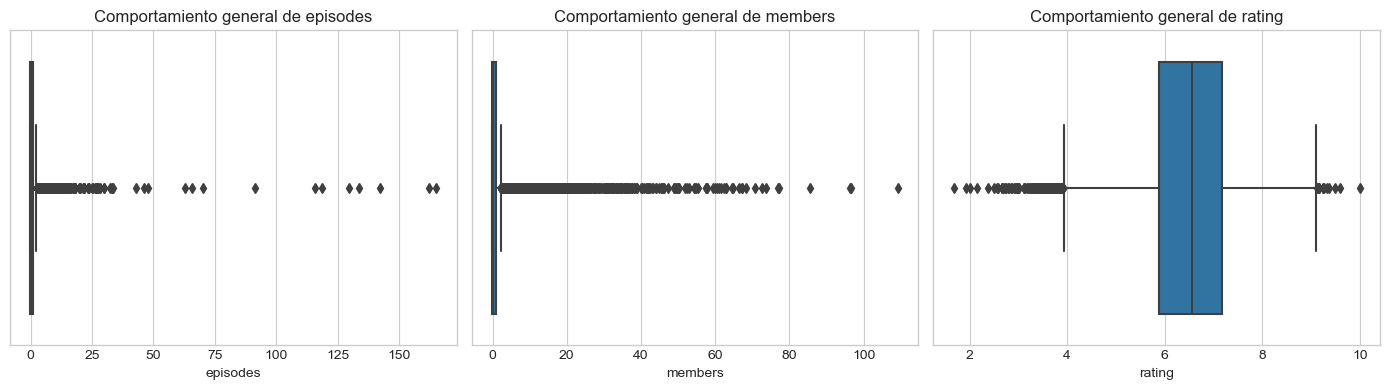

In [69]:
dataframe_behaviour_univariate(df_robust)

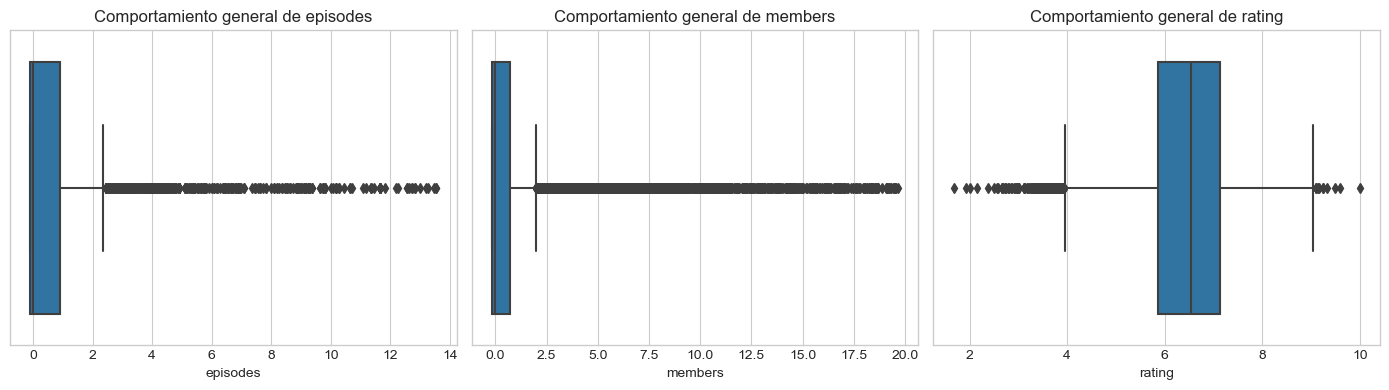

In [70]:
dataframe_behaviour_univariate(df_robust_sin_out)

    Se observa una leve mejora con respecto a la mediana, sin embargo aún persiste el alto sesgo y presencia de outliers en la muestra. Esto se debe a que mediante este criterio se elimina un bajo porcentaje de ellos.

#### <span style="color:#87CEEB"> 6.2.4.- Dataframe con Logaritmo (df_log) con y sin tratamiendo de outliers

In [71]:
df_log.describe(percentiles=[.975])

episodes       members        rating
count  12064.000000  12064.000000  12064.000000
mean       1.225730      7.420719      6.473902
std        1.453203      2.333655      1.026746
min        0.001000      2.484990      1.670000
50%        0.693647      7.338889      6.570000
97.5%      4.084697     11.993320      8.250000
max        7.505493     13.829332     10.000000

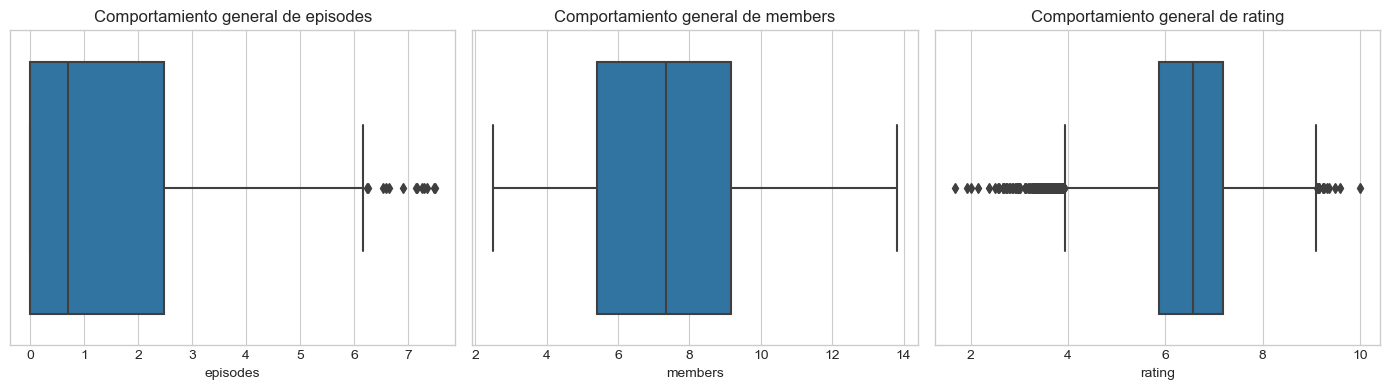

In [72]:
dataframe_behaviour_univariate(df_log)

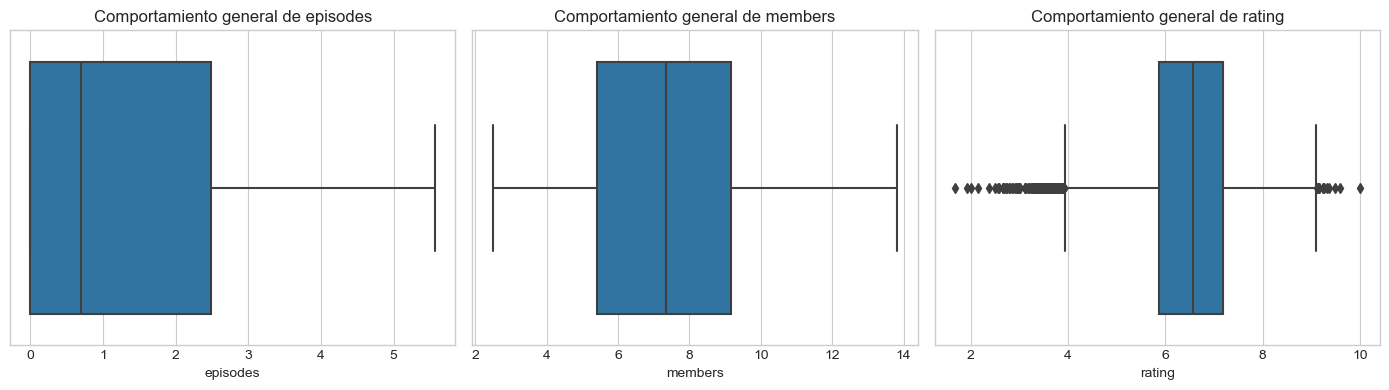

In [73]:
dataframe_behaviour_univariate(df_log_sin_out)

    La transformación logarítmica logra afectar de manera considerable la presencia de outliers.

#### <span style="color:#87CEEB"> 6.2.5.- Dataframe con Raíz cuadrada (df_sqrt) con y sin tratamiendo de outliers

In [74]:
df_sqrt.describe(percentiles=[.975])

episodes       members        rating
count  12064.000000  12064.000000  12064.000000
mean       2.504690     80.811230      6.473902
std        2.448862    108.397621      1.026746
min        1.000500      3.464246      1.670000
50%        1.414567     39.230103      6.570000
97.5%      7.708760    402.084846      8.250000
max       42.638023   1006.934457     10.000000

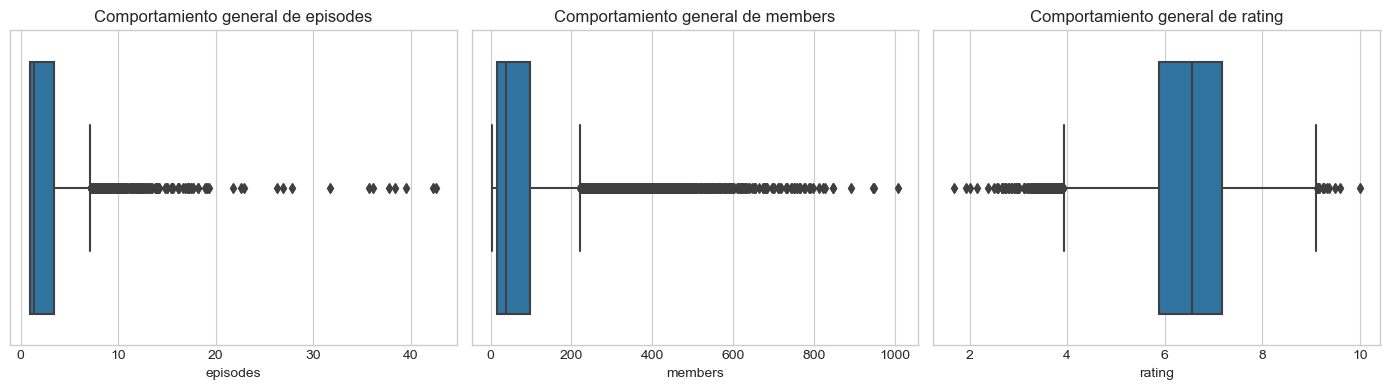

In [75]:
dataframe_behaviour_univariate(df_sqrt)

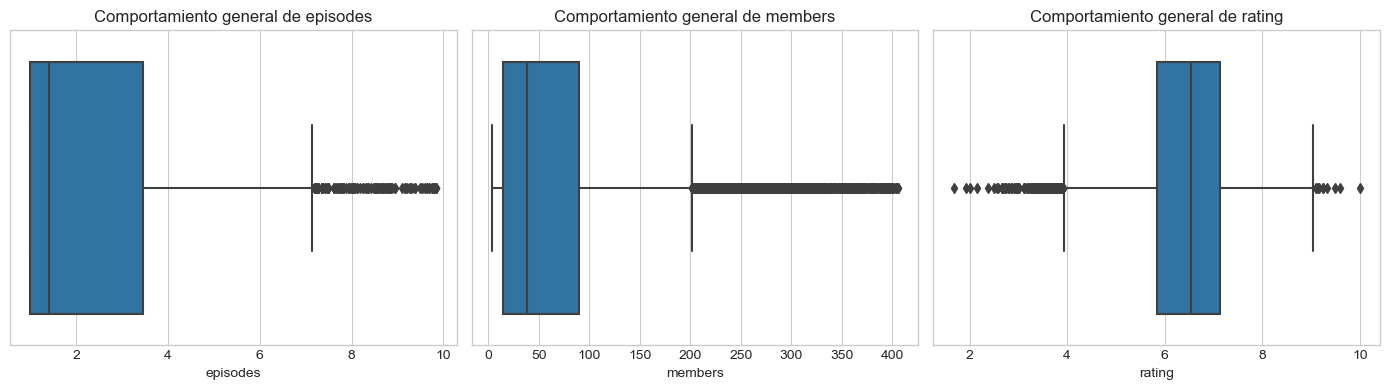

In [76]:
dataframe_behaviour_univariate(df_sqrt_sin_out)

    En la transformación mediante la raíz cuadrada, si bien mejora, no es tan efectiva como el resultado obtenido mediante la transformación logarítmica respecto a los outliers.

### <span style="color:#87CEEB"> 6.3.- Análisis multivariable

#### <span style="color:#87CEEB"> 6.3.1.- Dataframe limpio (df_clean) con y sin tratamiendo de outliers

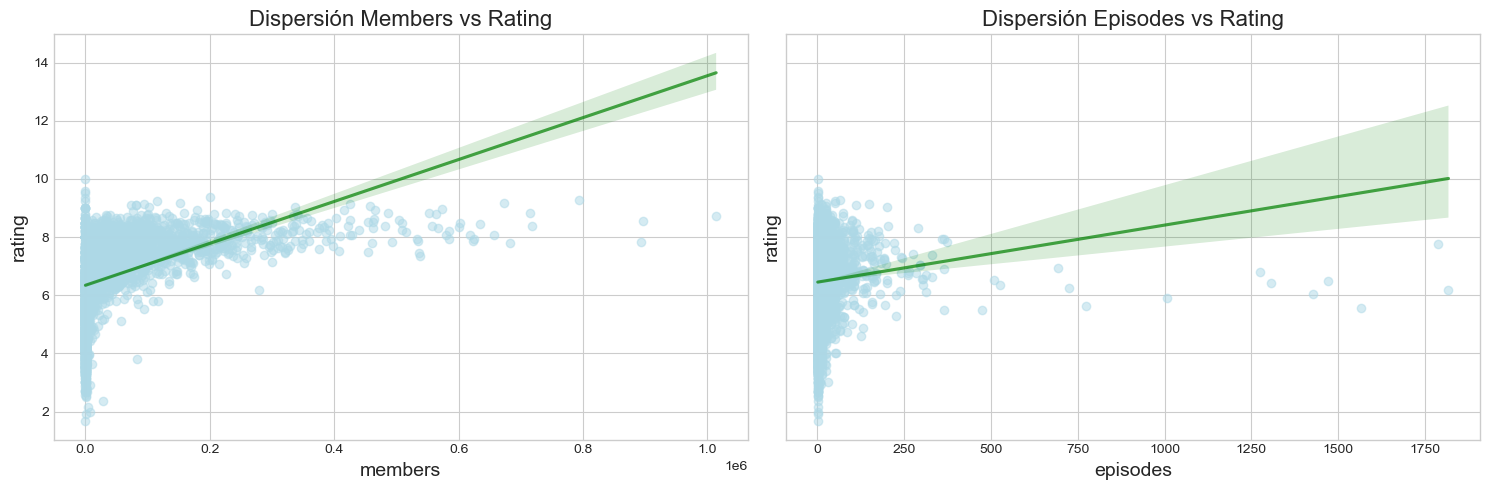

In [77]:
graficar_dispersion(df_clean)

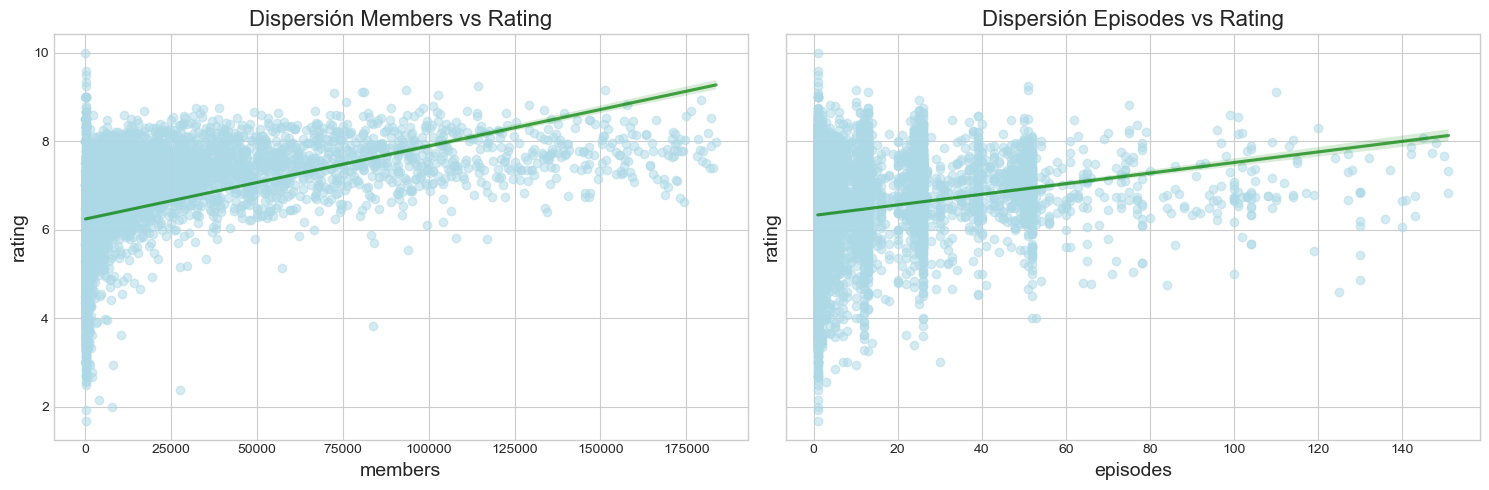

In [78]:
graficar_dispersion(df_clean_sin_out)

    Se observa correlación positiva en ambos casos, en cuanto a la tendencia se ajusta de mejor manera luego de eliminar los outliers, dado que la recta capta mejor la distribución de los datos.

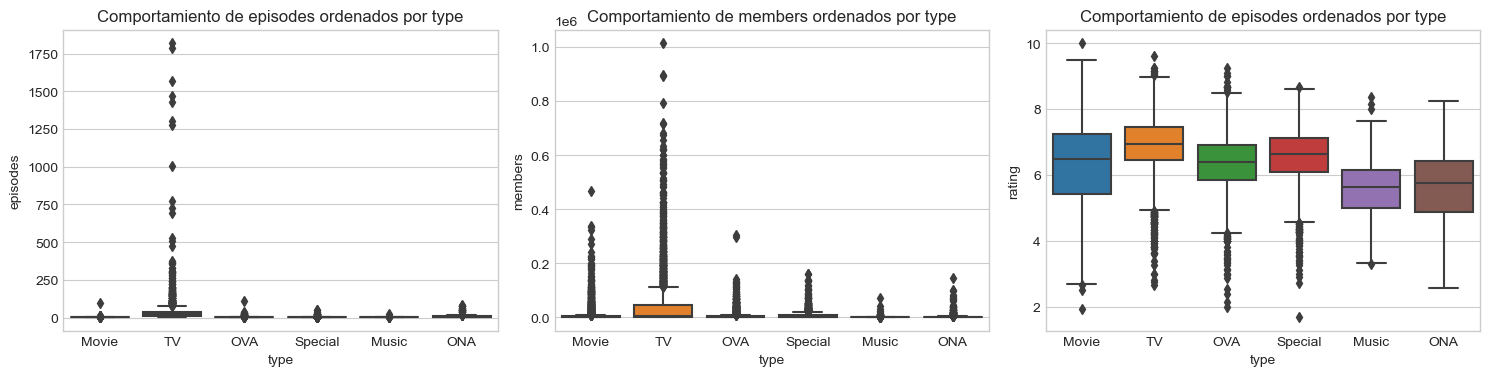

In [79]:
dataframe_behaviour_multivariate(df_clean)

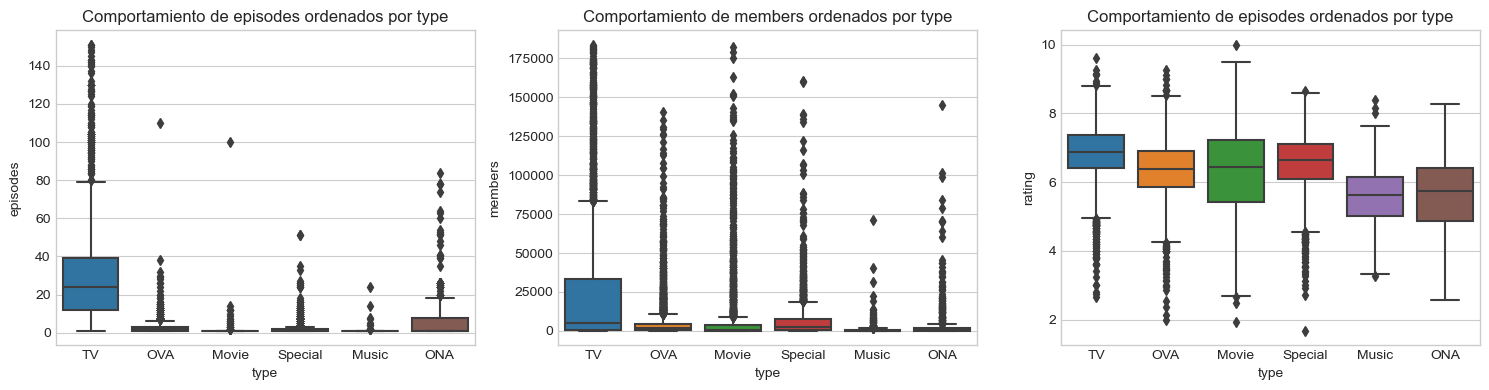

In [80]:
dataframe_behaviour_multivariate(df_clean_sin_out)

    Se observa una leve mejora con respecto a la mediana, sin embargo aún persiste el alto sesgo y presencia de outliers en la muestra. Esto se debe a que mediante este criterio se elimina un bajo porcentaje de ellos.

#### <span style="color:#87CEEB"> 6.3.2.- Dataframe con StandarScaler (df_standard_scaler) con y sin tratamiendo de outliers

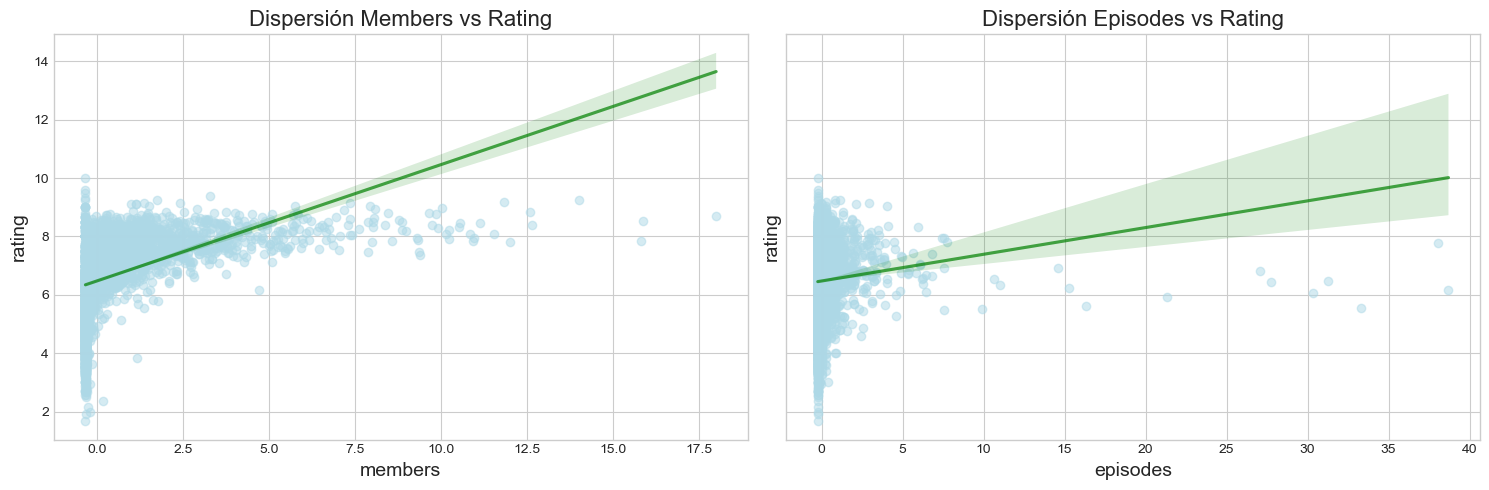

In [81]:
graficar_dispersion(df_standard)

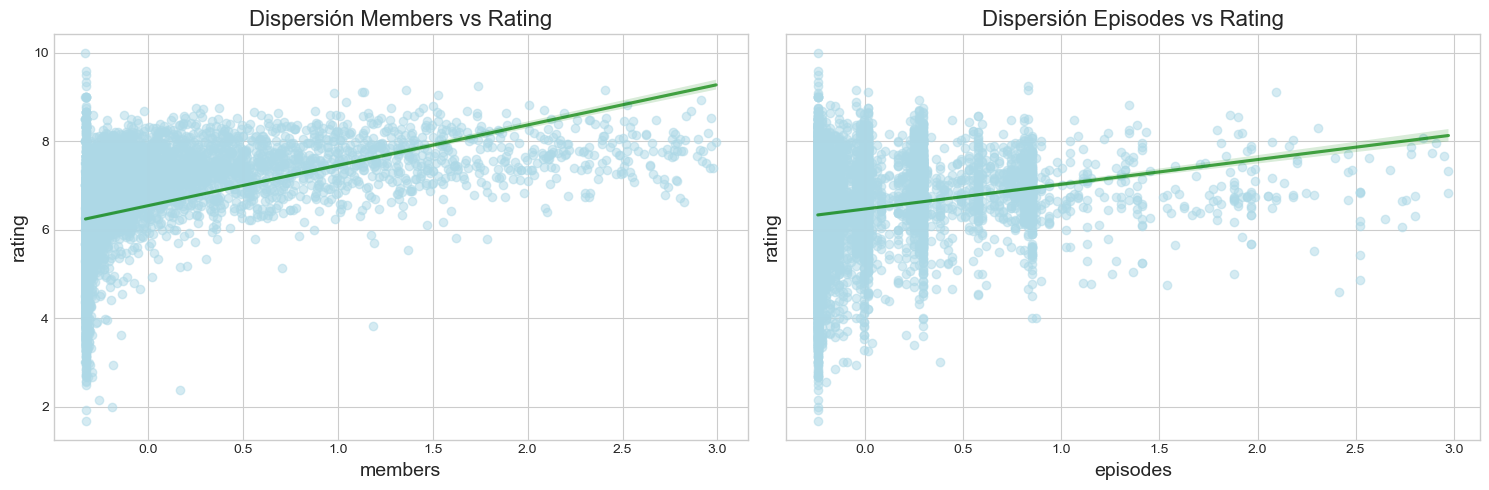

In [82]:
graficar_dispersion(df_std_sin_out)

    Se observa correlación positiva en ambos casos, en cuanto a la tendencia se ajusta de mejor manera luego de eliminar los outliers, dado que la recta capta mejor la distribución de los datos.

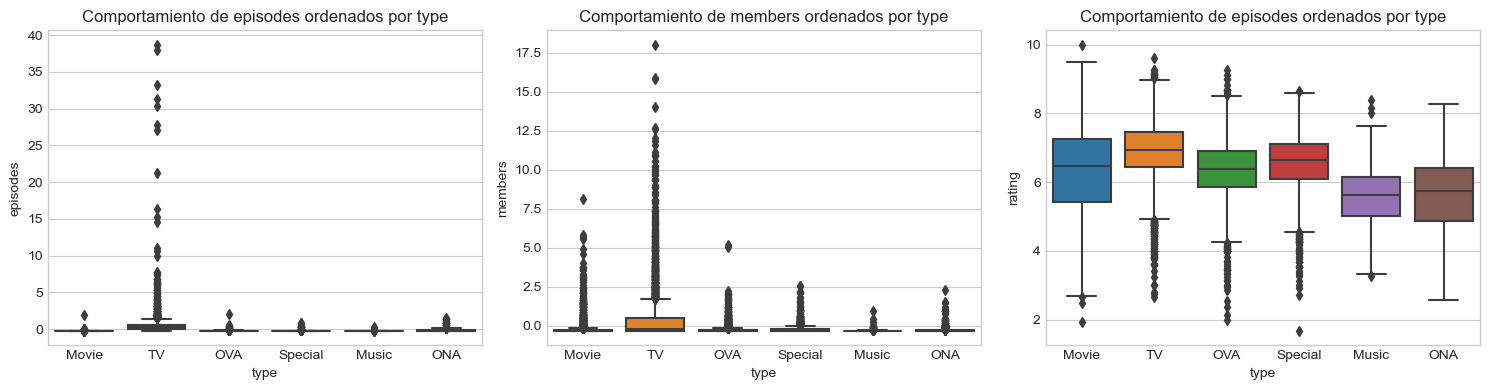

In [83]:
dataframe_behaviour_multivariate(df_standard)

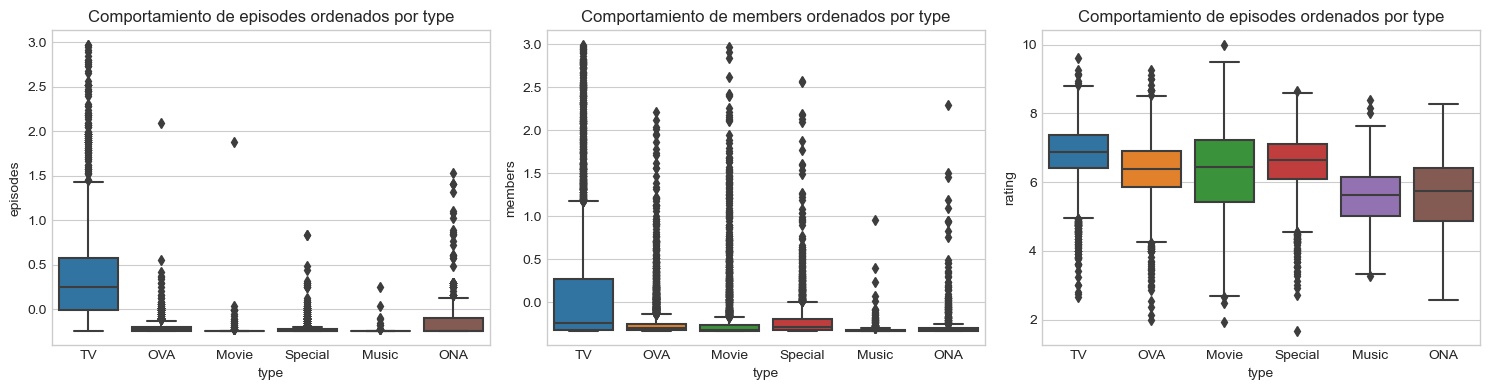

In [84]:
dataframe_behaviour_multivariate(df_std_sin_out)

    Se observa una leve mejora con respecto a la mediana, sin embargo aún persiste el alto sesgo y presencia de outliers en la muestra. Esto se debe a que mediante este criterio se elimina un bajo porcentaje de ellos.

#### <span style="color:#87CEEB"> 6.3.3.- Dataframe con RobustScaler (df_robust) con y sin tratamiendo de outliers

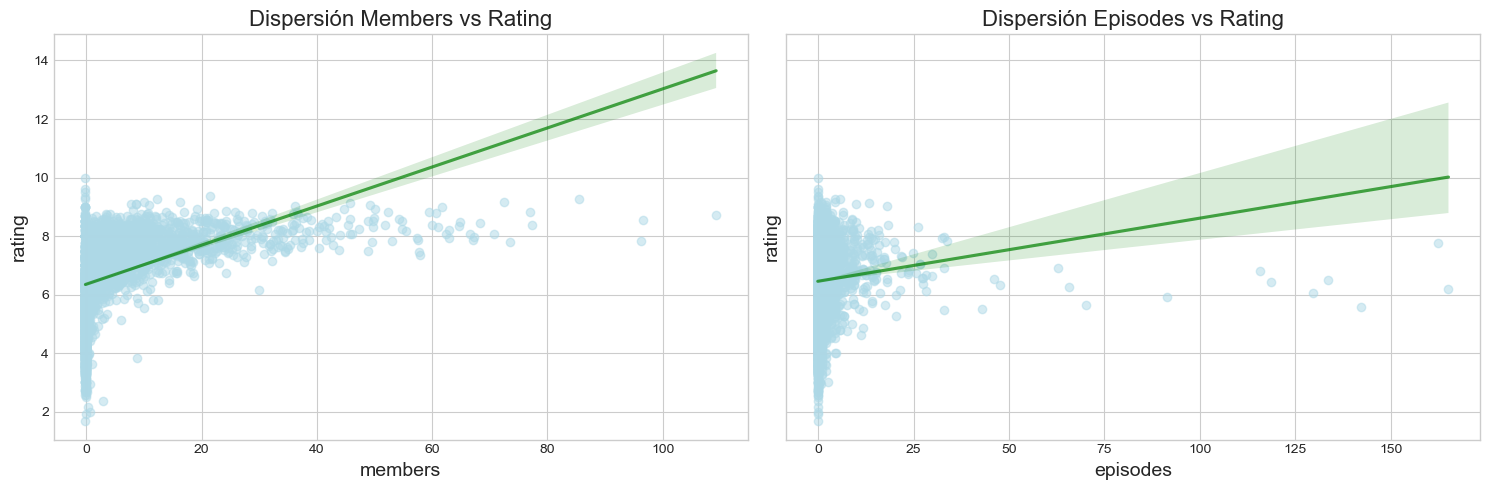

In [85]:
graficar_dispersion(df_robust)

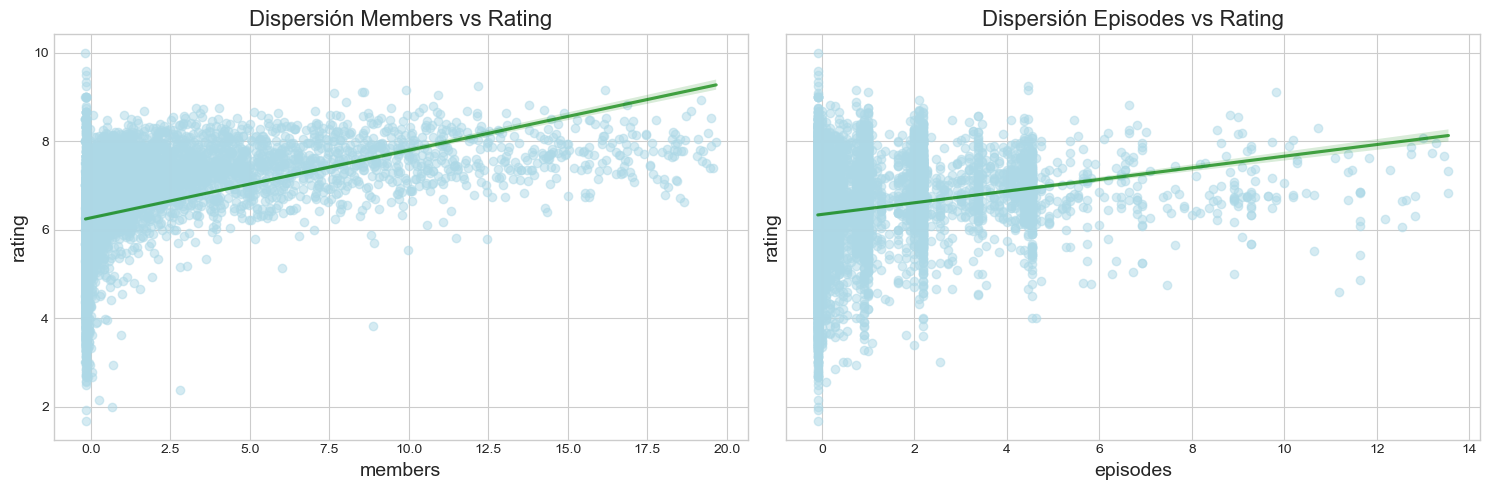

In [86]:
graficar_dispersion(df_robust_sin_out)

    Se observa correlación positiva en ambos casos, en cuanto a la tendencia se ajusta de mejor manera luego de eliminar los outliers, dado que la recta capta mejor la distribución de los datos.

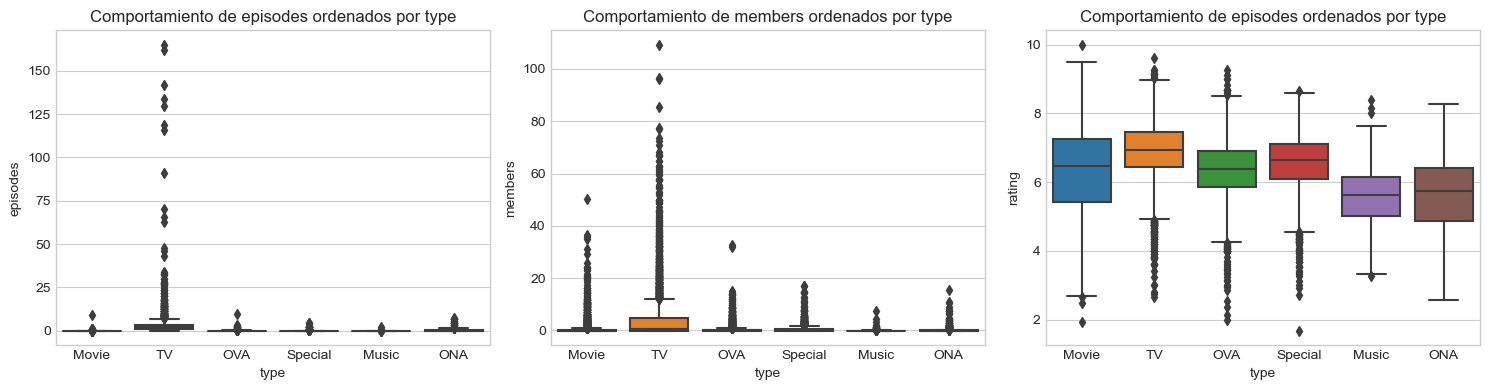

In [87]:
dataframe_behaviour_multivariate(df_robust)

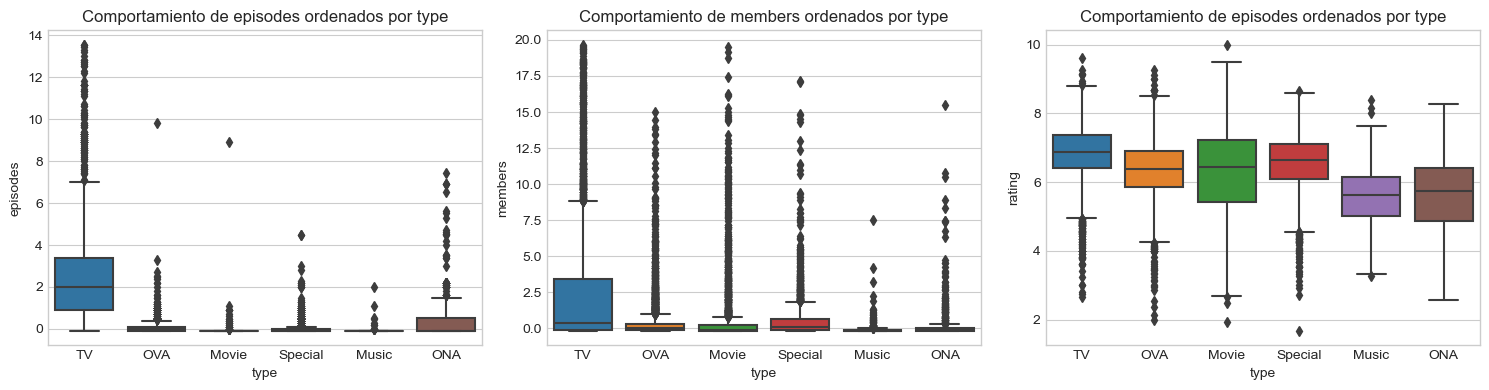

In [88]:
dataframe_behaviour_multivariate(df_robust_sin_out)

    Se observa una leve mejora con respecto a la mediana, sin embargo aún persiste el alto sesgo y presencia de outliers en la muestra. Esto se debe a que mediante este criterio se elimina un bajo porcentaje de ellos.

#### <span style="color:#87CEEB"> 6.3.4.- Dataframe con Logaritmo (df_log) con y sin tratamiendo de outliers

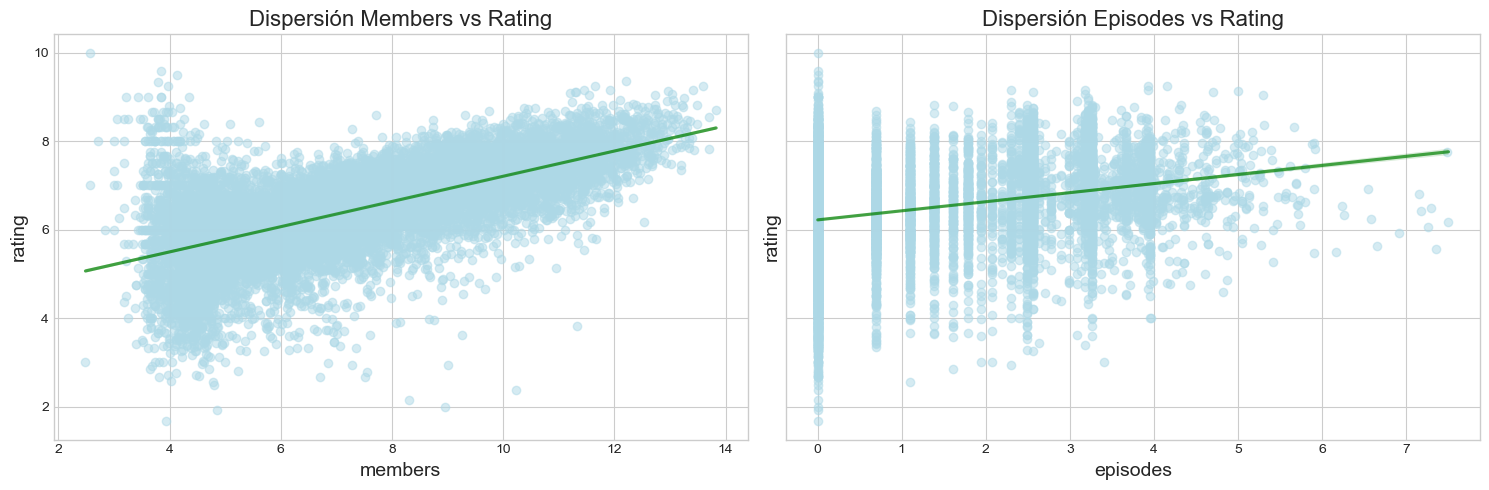

In [89]:
graficar_dispersion(df_log)

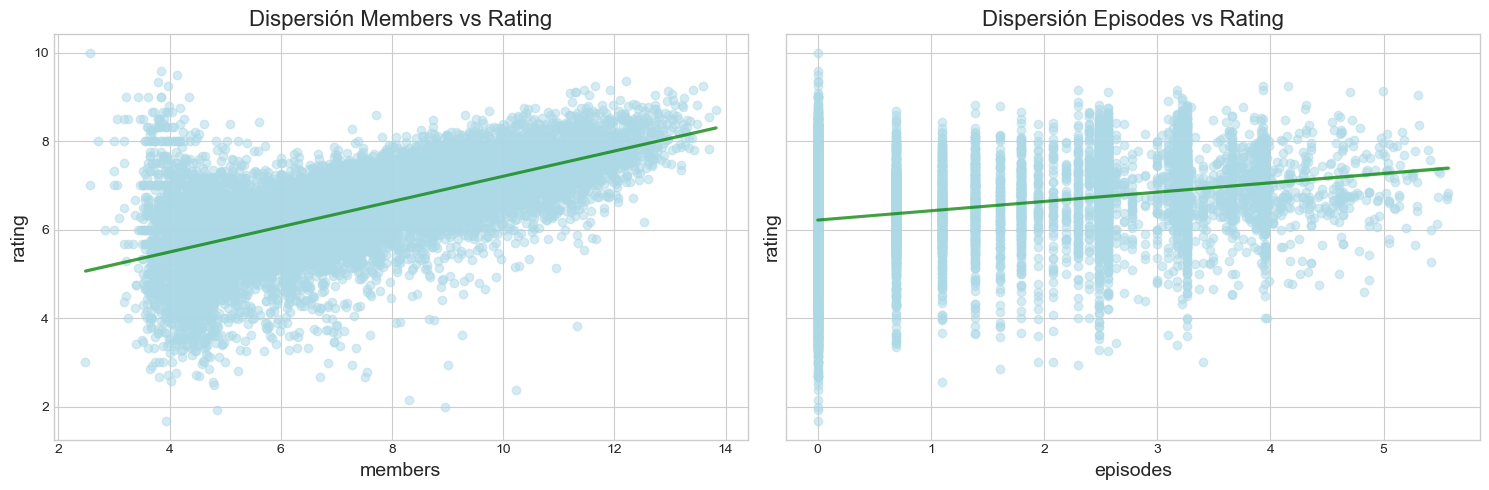

In [90]:
graficar_dispersion(df_log_sin_out)

    Se observa correlación positiva en ambos casos, en cuanto a la tendencia se ajusta de mejor manera luego de eliminar los outliers, dado que la recta capta mejor la distribución de los datos.

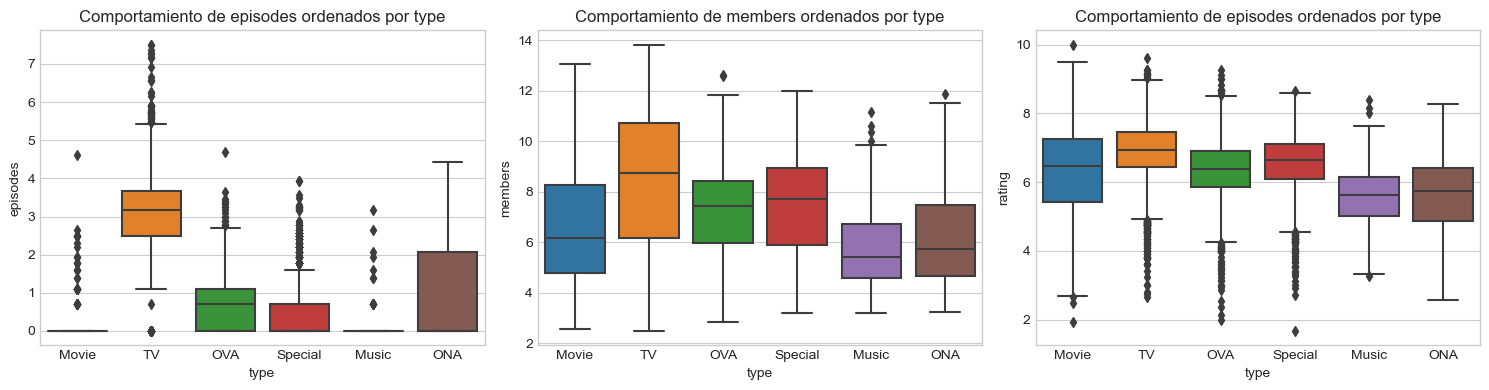

In [91]:
dataframe_behaviour_multivariate(df_log)

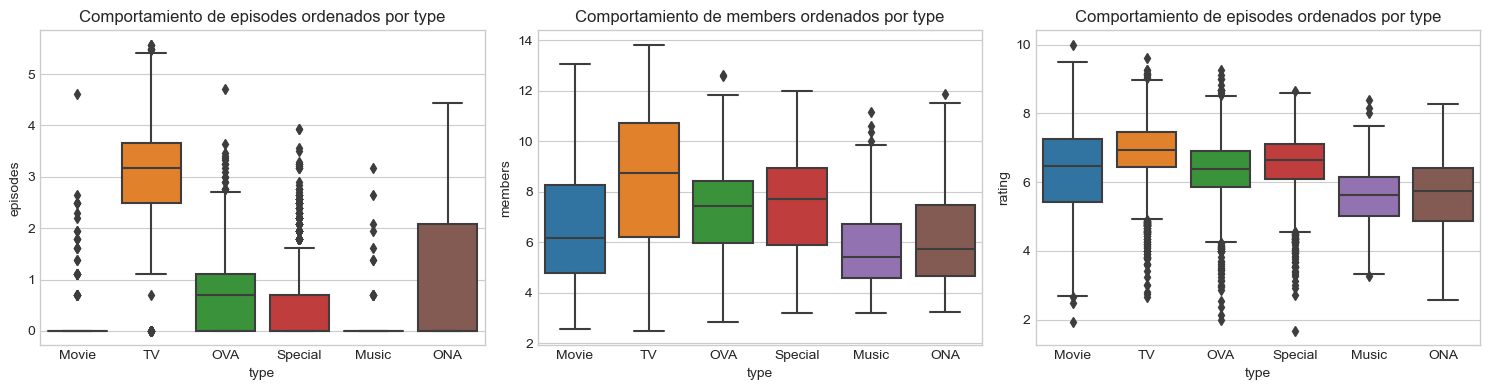

In [92]:
dataframe_behaviour_multivariate(df_log_sin_out)

    Se observa una clara mejora en la mediana de la muestra, para todas las categorías. La transformación logarítmica logra afectar de manera considerable la presencia de outliers.

#### <span style="color:#87CEEB"> 6.3.5.- Dataframe con Raíz cuadrada (df_sqrt) con y sin tratamiendo de outliers

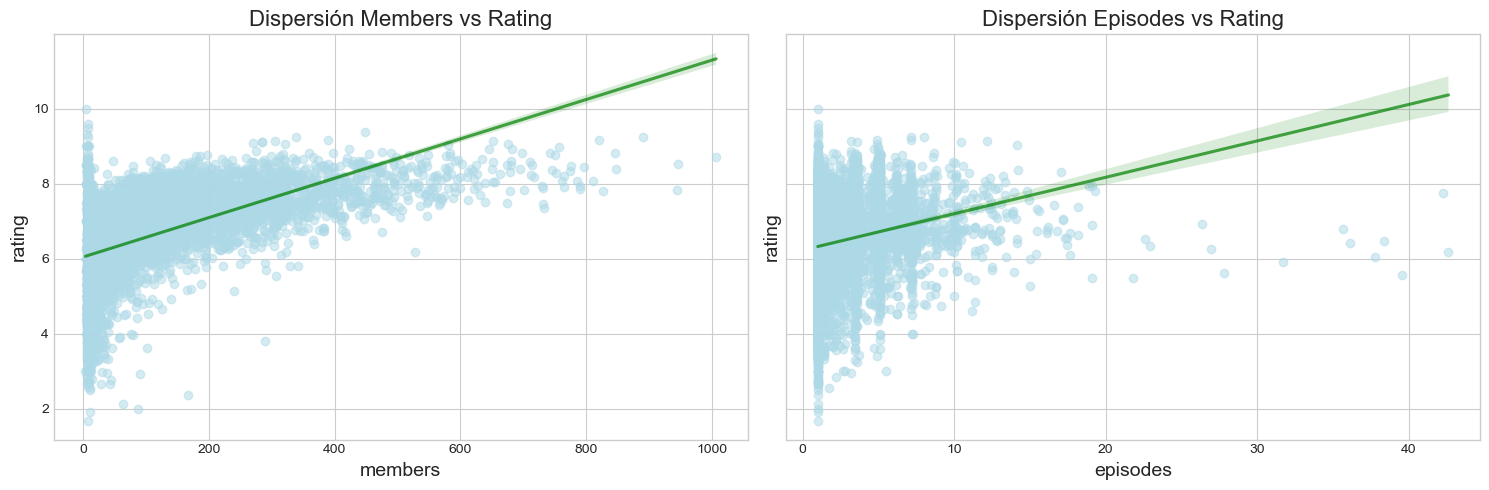

In [93]:
graficar_dispersion(df_sqrt)

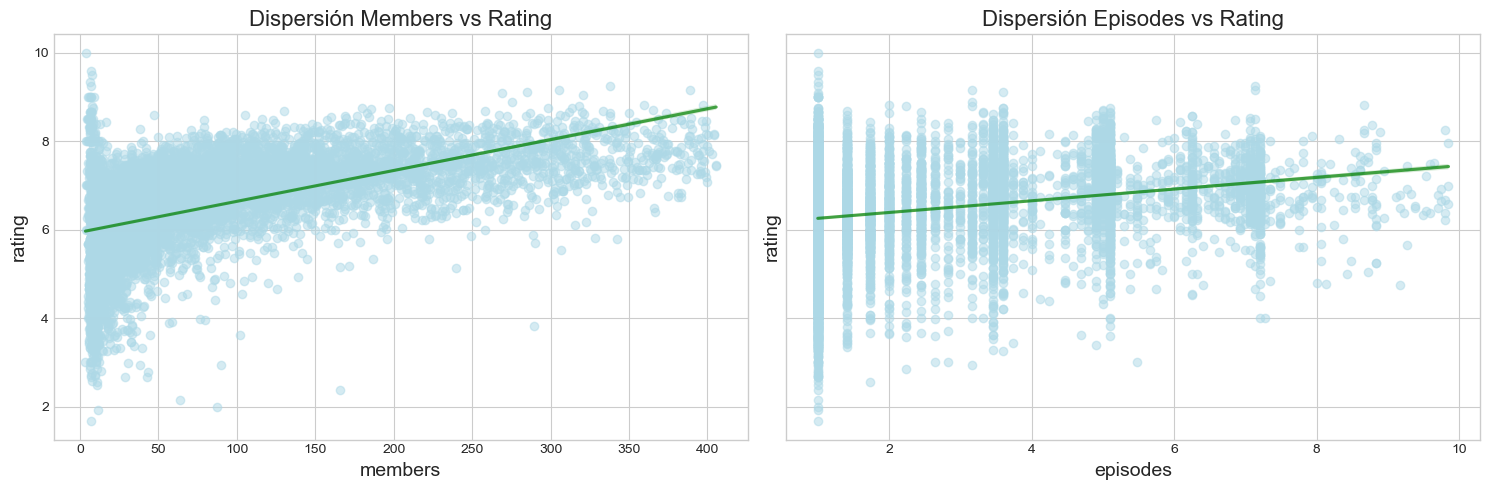

In [94]:
graficar_dispersion(df_sqrt_sin_out)

    Se observa correlación positiva en ambos casos, en cuanto a la tendencia se ajusta de mejor manera luego de eliminar los outliers, dado que la recta capta mejor la distribución de los datos.

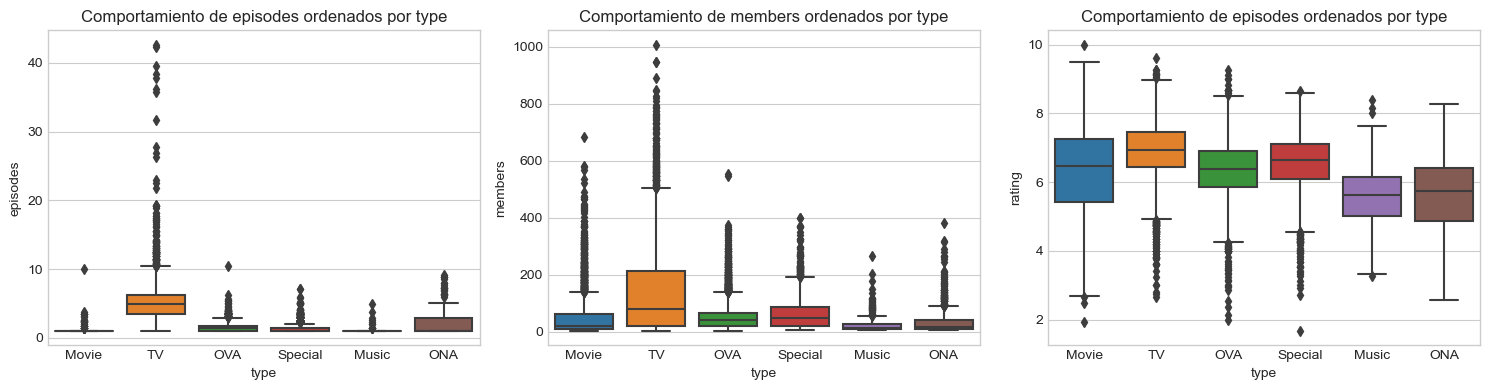

In [95]:
dataframe_behaviour_multivariate(df_sqrt)

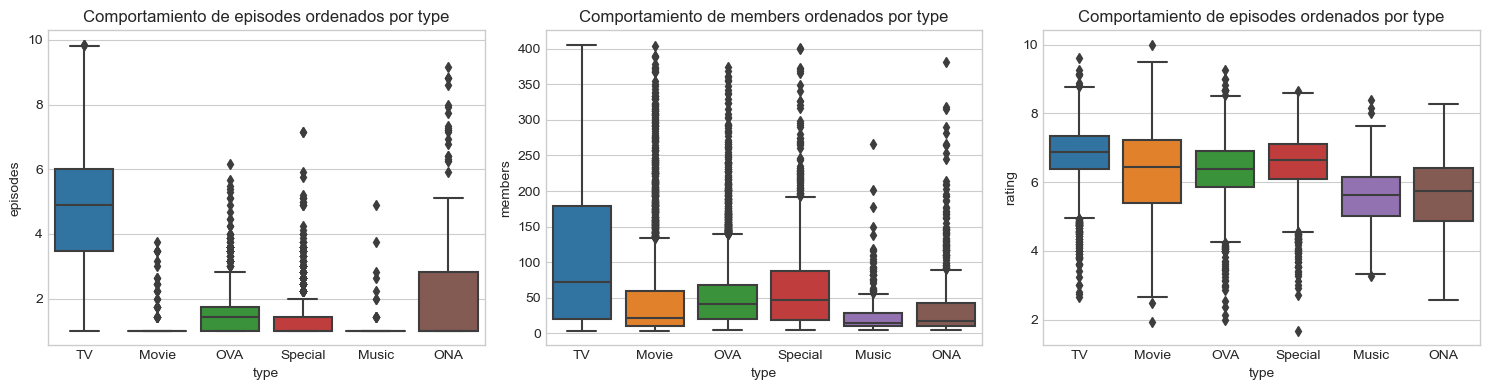

In [96]:
dataframe_behaviour_multivariate(df_sqrt_sin_out)

    Se observa una mejora en la mediana de la muestra, para todas las categorías. La transformación mediante la raiz cuadrada, si bien mejora, no es tan efectiva como el resultado obtenido mediante la transformación logarítmica.

### <span style="color:#87CEEB"> 6.4.- Correlaciones

#### <span style="color:#87CEEB"> 6.4.1.- Correlaciones Dataframe limpio (df_clean) con y sin tratamiendo de outliers

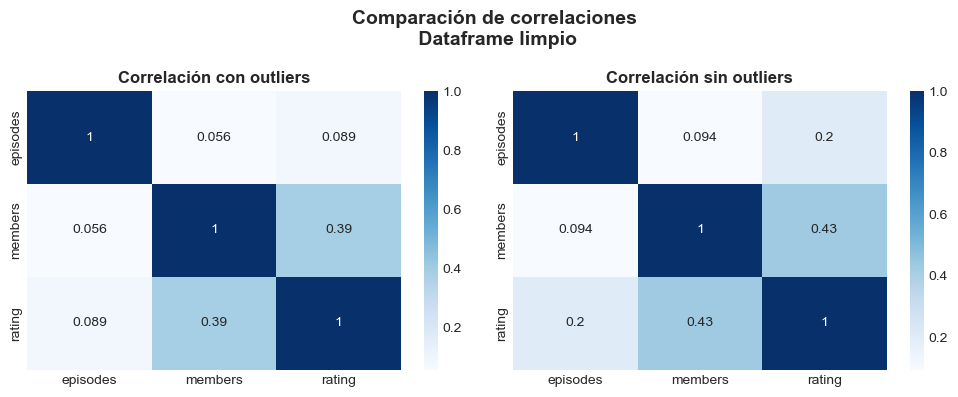

In [97]:
comparacion_correlaciones(df_clean, df_clean_sin_out, 'Dataframe limpio')

    - Se aprecia una correlación moderada entre las variables members y rating.
    - Las demás correlaciones, entre members y episodes; y entre rating y episodes, se observa una asociación particularmente débil.
    - Si comparamos los dataframes, vemos una gran diferencia en el coeficiente de correlación con respecto a rating y episodes.

#### <span style="color:#87CEEB"> 6.4.2.- Correlaciones Dataframe con StandarScaler (df_standard_scaler) con y sin tratamiendo de outliers

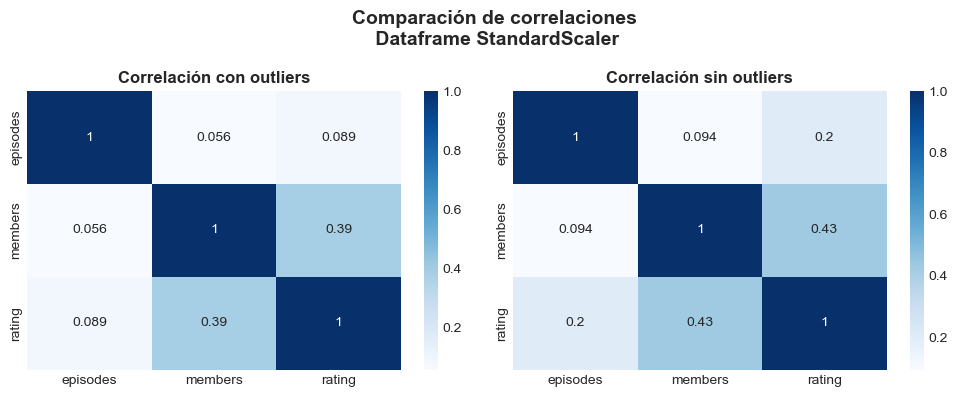

In [98]:
comparacion_correlaciones(df_standard, df_std_sin_out, 'Dataframe StandardScaler')

    - Se aprecia una correlación moderada entre las variables members y rating.
    - Las demás correlaciones, entre members y episodes; y entre rating y episodes, se observa una asociación particularmente débil.
    - Si comparamos los dataframes, vemos una gran diferencia en el coeficiente de correlación con respecto a rating y episodes.
    - Se llega a observar que los coeficientes de correlación entre el dataframe sin estandarizar y los dataframes estandarizados con "StandarScaler" y "RobustScaler" dan las mismas asociaciones- Se aprecia una correlación moderada entre las variables members y rating.
    - Las demás correlaciones, entre members y episodes; y entre rating y episodes, se observa una asociación particularmente débil.
    - Si comparamos los dataframes, vemos una gran diferencia en el coeficiente de correlación con respecto a rating y episodes.

#### <span style="color:#87CEEB"> 6.4.3.- Correlaciones Dataframe con RobustScaler (df_robust) con y sin tratamiendo de outliers

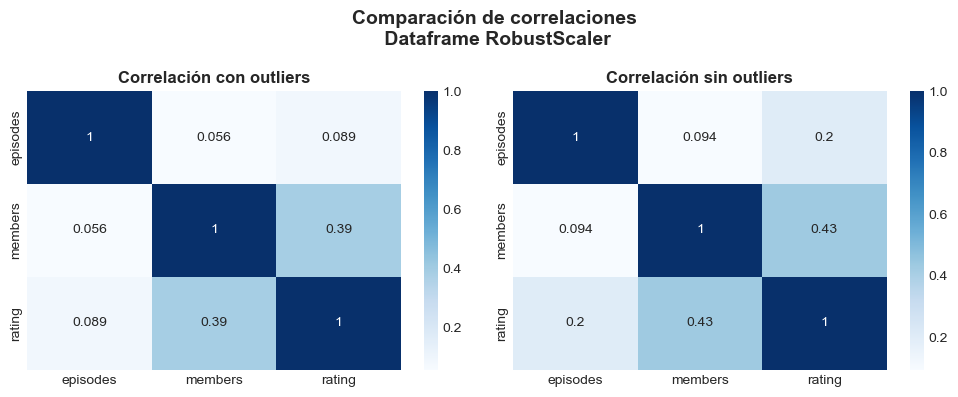

In [99]:
comparacion_correlaciones(df_robust, df_robust_sin_out, 'Dataframe RobustScaler')

    - Se aprecia una correlación moderada entre las variables members y rating.
    - Las demás correlaciones, entre members y episodes; y entre rating y episodes, se observa una asociación particularmente débil.
    - Si comparamos el dataframe que tiene tratamiento de outliers con el que no, vemos una gran diferencia en el coeficiente de correlación con respecto a rating y episodes.
    - Se llega a observar que los coeficientes de correlación entre el dataframe sin estandarizar y los dataframes estandarizados con "StandarScaler" y "RobustScaler" dan las mismas asociaciones.

#### <span style="color:#87CEEB"> 6.4.4.- Correlaciones Dataframe con Logaritmo (df_log) con y sin tratamiendo de outliers

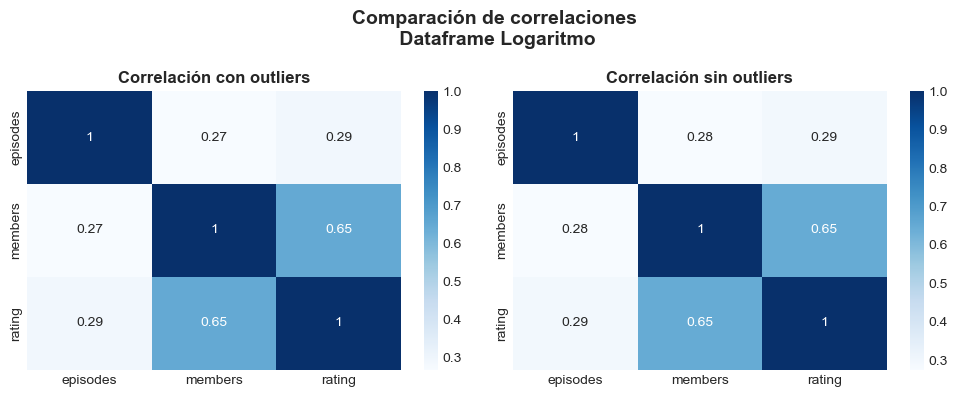

In [100]:
comparacion_correlaciones(df_log, df_log_sin_out, 'Dataframe Logaritmo')

    - Se aprecia una fuerte correlación entre las variables members y rating.
    - Se observa una correlación débil entre las variables members y episodes.
    - No se aprecia una diferencia de los coeficientes de correlación con respecto al dataframe que tiene outliers con el que tiene un tratamiento de outliers.
    - De todos los coeficientes de correlación, particularmente de este dataframe, es el que las variables members y rating están más asociados.

#### <span style="color:#87CEEB"> 6.4.5.- Correlaciones Dataframe con Raíz cuadrada (df_sqrt) con y sin tratamiendo de outliers

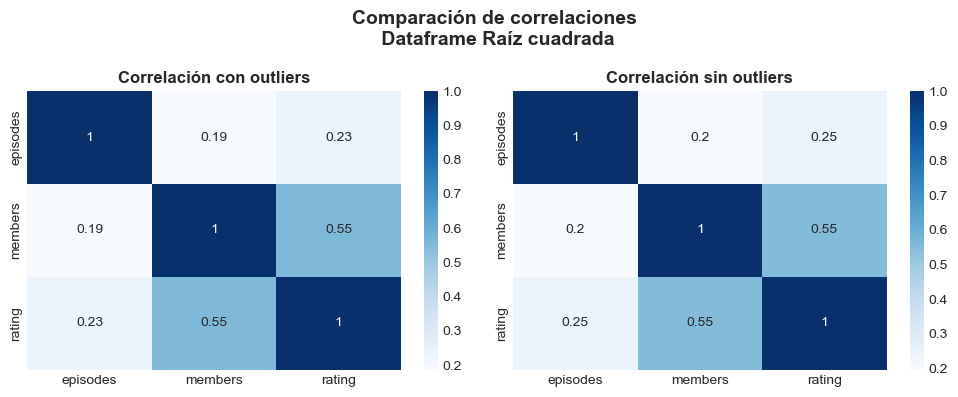

In [101]:
comparacion_correlaciones(df_sqrt, df_sqrt_sin_out, 'Dataframe Raíz cuadrada')

    - Se observa una correlación importante entre las variables members y rating
    - Se observa una correlación débil entre las variables members y episodes
    - No se aprecia una diferencia grande de los coeficientes de relación con respecto al dataframe que tiene outliers con el que tiene un tratamiento de outliers

## <span style="color:#87CEEB"> **7.- Creación de datasets para modelar**

### <span style="color:#87CEEB"> 7.1.- One-Hot Encoding (OHE) para atributos 'genre' y 'type'

##### <span style="color:orange"> Visualización simple de dataframes en 'diccionario_dataframes'

In [102]:
# Visualización simple de dataframes en 'diccionario_dataframes'
for _, values in enumerate(diccionario_dataframes):
    print(values)
    display(diccionario_dataframes[values].shape)
    display(diccionario_dataframes[values].head(1))

df_clean


(12064, 6)

name                                 genre   type  episodes  \
0  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie       1.0   

   members  rating  
0   200630    9.37

df_standard


(12064, 6)

name                                 genre   type  episodes  \
0  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie -0.241496   

    members  rating  
0  3.299058    9.37

df_robust


(12064, 6)

name                                 genre   type  episodes  \
0  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie -0.090909   

     members  rating  
0  21.489665    9.37

df_log


(12064, 6)

name                                 genre   type  episodes  \
0  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie     0.001   

     members  rating  
0  12.209218    9.37

df_sqrt


(12064, 6)

name                                 genre   type  episodes  \
0  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie    1.0005   

      members  rating  
0  447.917404    9.37

df_clean_sin_out


(11741, 6)

name                                              genre type  episodes  \
0  Gintama°  Action, Comedy, Historical, Parody, Samurai, S...   TV      51.0   

   members  rating  
0   114262    9.25

df_std_sin_out


(11741, 6)

name                                              genre type  episodes  \
0  Gintama°  Action, Comedy, Historical, Parody, Samurai, S...   TV  0.830019   

    members  rating  
0  1.736501    9.25

df_robust_sin_out


(11741, 6)

name                                              genre type  episodes  \
0  Gintama°  Action, Comedy, Historical, Parody, Samurai, S...   TV  4.454545   

     members  rating  
0  12.167197    9.25

df_log_sin_out


(12033, 6)

name                                 genre   type  episodes  \
0  Kimi no Na wa.  Drama, Romance, School, Supernatural  Movie     0.001   

     members  rating  
0  12.209218    9.37

df_sqrt_sin_out


(11608, 6)

name                                              genre type  episodes  \
0  Gintama°  Action, Comedy, Historical, Parody, Samurai, S...   TV  7.141498   

      members  rating  
0  338.026628    9.25

##### <span style="color:orange"> OHE y concatenación

In [103]:
# OHE y concatenación 
dict_df_para_modelacion = {}  # diccionario que guarda los dataframes con dummies para modelar
for data in diccionario_dataframes.items():
    tmp_dummies = pd.get_dummies(data[1][['genre', 'type']])
    tmp_dummies.columns = tmp_dummies.columns.str.replace('genre_', '')  # quitar el prefijo 'genre'
    tmp_ep_mem = data[1].loc[:, ['episodes', 'members', 'rating']]
    tmp_modelo = pd.concat([tmp_ep_mem, tmp_dummies], axis=1)
    dict_df_para_modelacion[f'{data[0]}_modelacion'] = tmp_modelo

##### <span style="color:orange"> Visualización simple de dataframes post-OHE

In [104]:
# Visualización simple de dataframes post-OHE
for _, values in enumerate(dict_df_para_modelacion):
    print(values)
    display(dict_df_para_modelacion[values].head(1))

df_clean_modelacion


episodes  members  rating  Action  Action, Adventure  \
0       1.0   200630    9.37       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  \
0                                0                          0   

   Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi  \
0                                                  0                                   

   ...  Supernatural  Thriller  Vampire  Yaoi  type_Movie  type_Music  \
0  ...             0         0        0     0           1           0   

   type_ONA  type_OVA  type_Special  type_TV  
0         0         0             0        0  

[1 rows x 3238 columns]

df_standard_modelacion


episodes   members  rating  Action  Action, Adventure  \
0 -0.241496  3.299058    9.37       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  \
0                                0                          0   

   Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi  \
0                                                  0                                   

   ...  Supernatural  Thriller  Vampire  Yaoi  type_Movie  type_Music  \
0  ...             0         0        0     0           1           0   

   type_ONA  type_OVA  type_Special  type_TV  
0         0         0             0        0  

[1 rows x 3238 columns]

df_robust_modelacion


episodes    members  rating  Action  Action, Adventure  \
0 -0.090909  21.489665    9.37       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  \
0                                0                          0   

   Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi  \
0                                                  0                                   

   ...  Supernatural  Thriller  Vampire  Yaoi  type_Movie  type_Music  \
0  ...             0         0        0     0           1           0   

   type_ONA  type_OVA  type_Special  type_TV  
0         0         0             0        0  

[1 rows x 3238 columns]

df_log_modelacion


episodes    members  rating  Action  Action, Adventure  \
0     0.001  12.209218    9.37       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  \
0                                0                          0   

   Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi  \
0                                                  0                                   

   ...  Supernatural  Thriller  Vampire  Yaoi  type_Movie  type_Music  \
0  ...             0         0        0     0           1           0   

   type_ONA  type_OVA  type_Special  type_TV  
0         0         0             0        0  

[1 rows x 3238 columns]

df_sqrt_modelacion


episodes     members  rating  Action  Action, Adventure  \
0    1.0005  447.917404    9.37       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  \
0                                0                          0   

   Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi  \
0                                                  0                                   

   ...  Supernatural  Thriller  Vampire  Yaoi  type_Movie  type_Music  \
0  ...             0         0        0     0           1           0   

   type_ONA  type_OVA  type_Special  type_TV  
0         0         0             0        0  

[1 rows x 3238 columns]

df_clean_sin_out_modelacion


episodes  members  rating  Action  Action, Adventure  \
0      51.0   114262    9.25       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  \
0                                0                          0   

   Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi  \
0                                                  0                                   

   ...  Supernatural  Thriller  Vampire  Yaoi  type_Movie  type_Music  \
0  ...             0         0        0     0           0           0   

   type_ONA  type_OVA  type_Special  type_TV  
0         0         0             0        1  

[1 rows x 3146 columns]

df_std_sin_out_modelacion


episodes   members  rating  Action  Action, Adventure  \
0  0.830019  1.736501    9.25       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  \
0                                0                          0   

   Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi  \
0                                                  0                                   

   ...  Supernatural  Thriller  Vampire  Yaoi  type_Movie  type_Music  \
0  ...             0         0        0     0           0           0   

   type_ONA  type_OVA  type_Special  type_TV  
0         0         0             0        1  

[1 rows x 3146 columns]

df_robust_sin_out_modelacion


episodes    members  rating  Action  Action, Adventure  \
0  4.454545  12.167197    9.25       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  \
0                                0                          0   

   Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi  \
0                                                  0                                   

   ...  Supernatural  Thriller  Vampire  Yaoi  type_Movie  type_Music  \
0  ...             0         0        0     0           0           0   

   type_ONA  type_OVA  type_Special  type_TV  
0         0         0             0        1  

[1 rows x 3146 columns]

df_log_sin_out_modelacion


episodes    members  rating  Action  Action, Adventure  \
0     0.001  12.209218    9.37       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  \
0                                0                          0   

   Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi  \
0                                                  0                                   

   ...  Supernatural  Thriller  Vampire  Yaoi  type_Movie  type_Music  \
0  ...             0         0        0     0           1           0   

   type_ONA  type_OVA  type_Special  type_TV  
0         0         0             0        0  

[1 rows x 3236 columns]

df_sqrt_sin_out_modelacion


episodes     members  rating  Action  Action, Adventure  \
0  7.141498  338.026628    9.25       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  \
0                                0                          0   

   Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi  \
0                                                  0                                   

   ...  Supernatural  Thriller  Vampire  Yaoi  type_Movie  type_Music  \
0  ...             0         0        0     0           0           0   

   type_ONA  type_OVA  type_Special  type_TV  
0         0         0             0        1  

[1 rows x 3128 columns]

## <span style="color:#87CEEB"> **8.- Modelación**

### <span style="color:#87CEEB"> 8.1.- Modelos a implementar

In [105]:
# lista de modelos a implementar
models_list = [
    ElasticNetCV(),
    LinearRegression(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),  
    AdaBoostRegressor(),
    GradientBoostingRegressor()
]

### <span style="color:#87CEEB"> 8.2.- Adición de dataframes transformados con V.O incluido.

In [106]:
var_a_escalar = ['episodes','members', 'rating']
var_sin_escalar = ['name', 'genre', 'type']

# Dataframes transformados, incluido el V.O
df_rating_log = dataframe_scaler(df_clean, np.log, var_a_escalar, var_sin_escalar)
df_rating_sqrt = dataframe_scaler(df_clean, np.sqrt, var_a_escalar, var_sin_escalar)

# Dataframes mixtos con eliminación de outliers
df_rating_log_sin_out = dataframe_sin_outliers(df_rating_log)
df_rating_sqrt_sin_out = dataframe_sin_outliers(df_rating_sqrt)

# se actualiza diccionario_dataframes con estos nuevos dataframes
diccionario_dataframes['df_rating_log'] = df_rating_log
diccionario_dataframes['df_rating_sqrt'] = df_rating_sqrt
diccionario_dataframes['df_rating_log_sin_out'] = df_rating_log_sin_out
diccionario_dataframes['df_rating_sqrt_sin_out'] = df_rating_sqrt_sin_out

# diccionario que contiene los nuevos dataframes
dict_rating_transformado = {
                        'df_rating_log': df_rating_log,
                        'df_rating_log_sin_out': df_rating_log_sin_out,
                        'df_rating_sqrt': df_rating_sqrt,                        
                        'df_rating_sqrt_sin_out': df_rating_sqrt_sin_out
                        }

##### <span style="color:orange"> OHE y concatenación para nuevos dataframes

In [107]:
# OHE y concatenación 
for data in dict_rating_transformado.items():
    tmp_dummies = pd.get_dummies(data[1][['genre', 'type']])
    tmp_dummies.columns = tmp_dummies.columns.str.replace('genre_', '')  # quitar el prefijo 'genre_'
    tmp_ep_mem = data[1].loc[:, ['episodes', 'members', 'rating']]
    tmp_modelo = pd.concat([tmp_ep_mem, tmp_dummies], axis=1)

    # se agregan a diccionario los nuevos dataframes con OHE
    dict_df_para_modelacion[f'{data[0]}_modelacion'] = tmp_modelo

In [108]:
# verificación de correcta actualización de diccionario
diccionario_dataframes.keys()

dict_keys(['df_clean', 'df_standard', 'df_robust', 'df_log', 'df_sqrt', 'df_clean_sin_out', 'df_std_sin_out', 'df_robust_sin_out', 'df_log_sin_out', 'df_sqrt_sin_out', 'df_rating_log', 'df_rating_sqrt', 'df_rating_log_sin_out', 'df_rating_sqrt_sin_out'])

In [109]:
# verificación de correcta actualización de diccionario
dict_df_para_modelacion.keys()

dict_keys(['df_clean_modelacion', 'df_standard_modelacion', 'df_robust_modelacion', 'df_log_modelacion', 'df_sqrt_modelacion', 'df_clean_sin_out_modelacion', 'df_std_sin_out_modelacion', 'df_robust_sin_out_modelacion', 'df_log_sin_out_modelacion', 'df_sqrt_sin_out_modelacion', 'df_rating_log_modelacion', 'df_rating_log_sin_out_modelacion', 'df_rating_sqrt_modelacion', 'df_rating_sqrt_sin_out_modelacion'])

### <span style="color:#87CEEB"> 8.3.- Generación de Dataframe con jerarquía en variable 'type'.

In [110]:
# Separar Dataframes para jerarquizar type
df_log_jerarquia = dataframe_scaler(df_clean, np.log, var_a_escalar, var_sin_escalar)
df_sqrt_jerarquia = dataframe_scaler(df_clean, np.sqrt, var_a_escalar, var_sin_escalar)

##### <span style="color:orange"> Criterio para definir orden jerárquico en recodificación

In [111]:
# Estudiar comportamiento y generar criterio de recodificación
orden_jerarquico = df_clean.groupby(['type']).agg({'rating':[np.mean],
                                'name':[np.size],
                                    'members':[np.mean],
                                    'episodes':[np.mean]}).sort_values(by=[('rating', 'mean')], ascending=False)
orden_jerarquico

rating  name       members   episodes
             mean  size          mean       mean
type                                            
TV       6.902299  3671  43774.971670  35.007355
Special  6.523501  1671   7691.870138   2.561341
OVA      6.375221  3285   6013.899543   2.405784
Movie    6.318058  2297  10392.398346   1.104484
ONA      5.643298   652   4150.253067   6.484663
Music    5.588996   488   1311.840164   1.131148

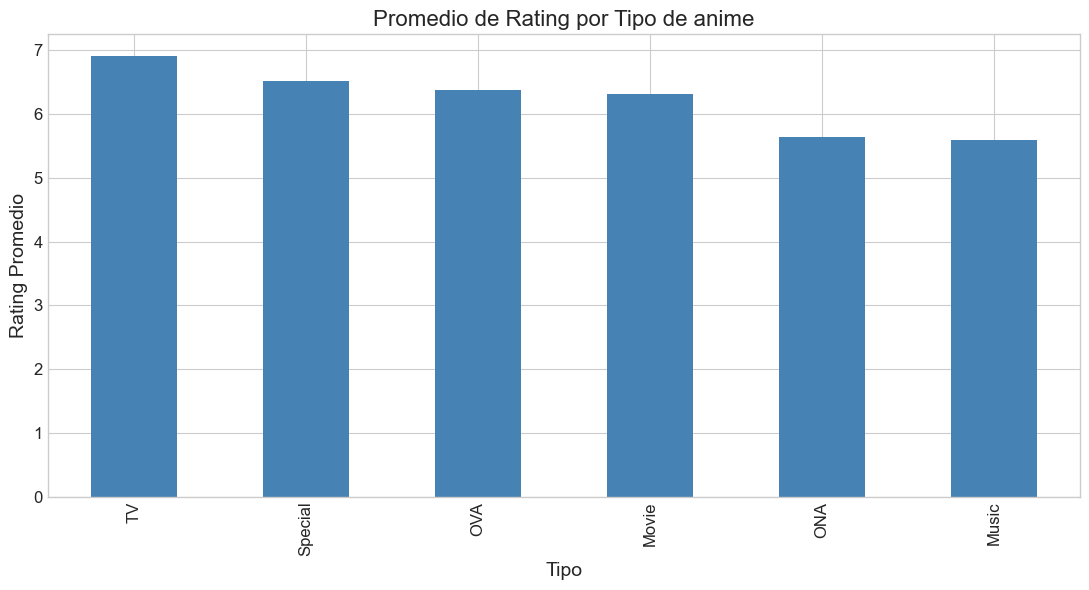

In [112]:
fig, ax = plt.subplots(figsize=(11, 6))
orden_jerarquico[('rating', 'mean')].plot(kind='bar', ax=ax, color='steelblue')
ax.set_ylabel('Rating Promedio', fontsize=14)
ax.set_xlabel('Tipo', fontsize=14)
ax.set_title('Promedio de Rating por Tipo de anime', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.tight_layout()
plt.show()

In [113]:
# Definir recodificación
type_recod = {
    'Movie': 4,
    'TV': 1,
    'OVA': 3,
    'Special': 2,
    'Music': 6,
    'ONA': 5
}

    Se utiliza como criterio la valoración dada por rating

##### <span style="color:orange">  Recodificación para transformación logarítmica

In [114]:
# Recodificar
df_log_jerarquia['type_recod'] = df_log_jerarquia['type'].map(type_recod)

df_log_jerarquia = df_log_jerarquia.drop(columns='type', axis=1)
diccionario_dataframes['df_log_jerarquia'] = df_log_jerarquia
display(df_log_jerarquia['type_recod'].unique())
display(df_log_jerarquia.shape)
display(df_log_jerarquia.head(1))

array([4, 1, 3, 2, 6, 5], dtype=int64)

(12064, 6)

name                                 genre  episodes    members  \
0  Kimi no Na wa.  Drama, Romance, School, Supernatural     0.001  12.209218   

    rating  type_recod  
0  2.23762           4

In [115]:
# OHE y concatenación para logaritmo
tmp_dummies = pd.get_dummies(df_log_jerarquia[['genre']])
tmp_dummies.columns = tmp_dummies.columns.str.replace('genre_', '')  # quitar el prefijo 'genre_'
tmp_ep_mem = df_log_jerarquia.loc[:, ['type_recod','episodes', 'members', 'rating']]
df_log_jerarquia_modelacion = pd.concat([tmp_ep_mem, tmp_dummies], axis=1)

# se agregan a diccionario el dataframe con OHE
dict_df_para_modelacion['df_log_jerarquia_modelacion'] = df_log_jerarquia_modelacion 

##### <span style="color:orange">  Recodificación para transformación raíz cuadrada

In [116]:
# Recodificar
df_sqrt_jerarquia['type_recod'] = df_sqrt_jerarquia['type'].map(type_recod)

df_sqrt_jerarquia = df_sqrt_jerarquia.drop(columns='type', axis=1)
diccionario_dataframes['df_sqrt_jerarquia'] = df_sqrt_jerarquia
display(df_sqrt_jerarquia['type_recod'].unique())
display(df_sqrt_jerarquia.shape)
display(df_sqrt_jerarquia.head(1))

array([4, 1, 3, 2, 6, 5], dtype=int64)

(12064, 6)

name                                 genre  episodes     members  \
0  Kimi no Na wa.  Drama, Romance, School, Supernatural    1.0005  447.917404   

     rating  type_recod  
0  3.061209           4

In [117]:
# OHE y concatenación para raíz cuadrada
tmp_dummies = pd.get_dummies(df_sqrt_jerarquia[['genre']])
tmp_dummies.columns = tmp_dummies.columns.str.replace('genre_', '')  # Quitar el prefijo "genre_"
tmp_ep_mem = df_sqrt_jerarquia.loc[:, ['type_recod','episodes', 'members', 'rating']]
df_sqrt_jerarquia_modelacion = pd.concat([tmp_ep_mem, tmp_dummies], axis=1)

# se agregan a diccionario el dataframe con OHE
dict_df_para_modelacion['df_sqrt_jerarquia_modelacion'] = df_sqrt_jerarquia_modelacion 

##### <span style="color:orange"> Guardado de dict_df_para_modelacion en archivo .pkl

In [118]:
pickle.dump(dict_df_para_modelacion, open('dict_df_para_modelacion.pkl', 'wb')) # contiene los df con dummies

### <span style="color:#87CEEB"> 8.4.- Modelación dataframes estandarizados y transformados

In [119]:
# Modelación y guardado de valores de MAPE, MAE y R2
mapes_iteracion_1, maes_iteracion_1, r2s_iteracion_1 = {}, {}, {}
for data in dict_df_para_modelacion.items():
    print(data[0])
    for model in models_list:
        mapes_iteracion_1[f'{data[0]}_{model}'], maes_iteracion_1[f'{data[0]}_{model}'], r2s_iteracion_1[f'{data[0]}_{model}']  = probar_modelos(model, data[1].drop(columns='rating', axis=1), data[1]['rating'], imprime=False, gen_modelacion=False)

df_clean_modelacion
df_standard_modelacion
df_robust_modelacion
df_log_modelacion
df_sqrt_modelacion
df_clean_sin_out_modelacion
df_std_sin_out_modelacion
df_robust_sin_out_modelacion
df_log_sin_out_modelacion
df_sqrt_sin_out_modelacion
df_rating_log_modelacion
df_rating_log_sin_out_modelacion
df_rating_sqrt_modelacion
df_rating_sqrt_sin_out_modelacion
df_log_jerarquia_modelacion
df_sqrt_jerarquia_modelacion


##### <span style="color:orange"> Guardado de metricas_iteracion_1 en archivo .pkl

In [120]:
# guardado en archivo .pkl
pickle.dump((mapes_iteracion_1,
            maes_iteracion_1,
            r2s_iteracion_1,
            ), open('metricas_iteracion_1_pre_eliminacion.pkl', 'wb'))

##### <span style="color:orange"> Eliminación de modelos deficientes

In [121]:
# modelos a eliminar de diccionarios
drop_linear = [ 'df_clean_modelacion_LinearRegression()',
                'df_standard_modelacion_LinearRegression()',
                'df_robust_modelacion_LinearRegression()',
                'df_log_modelacion_LinearRegression()',
                'df_sqrt_modelacion_LinearRegression()',
                'df_clean_sin_out_modelacion_LinearRegression()',
                'df_std_sin_out_modelacion_LinearRegression()',
                'df_robust_sin_out_modelacion_LinearRegression()',
                'df_log_sin_out_modelacion_LinearRegression()',
                'df_sqrt_sin_out_modelacion_LinearRegression()',
                'df_rating_log_modelacion_LinearRegression()',
                'df_rating_log_sin_out_modelacion_LinearRegression()',
                'df_rating_sqrt_modelacion_LinearRegression()',
                'df_rating_sqrt_sin_out_modelacion_LinearRegression()',
                'df_log_jerarquia_modelacion_LinearRegression()',
                'df_sqrt_jerarquia_modelacion_LinearRegression()'
                ]

    Esta lista muestra los modelos que dieron pésimas métricas, por lo que se eliminan de los diccionarios 'mapes_iteracion_1', 'maes_iteracion_1', 'r2s_iteracion_1'.

In [122]:
for elemento in drop_linear:
    mapes_iteracion_1.pop(elemento)
    maes_iteracion_1.pop(elemento)
    r2s_iteracion_1.pop(elemento)

##### <span style="color:orange"> Guardado de métricas en dataframe y posterior guardado en archivo .pkl

In [123]:
df_metricas_iteracion_1 = pd.DataFrame({"MAPE":mapes_iteracion_1, "MAE": maes_iteracion_1, "R2": r2s_iteracion_1}).sort_values(by='MAE')

# guardado en archivo .pkl
pickle.dump((df_metricas_iteracion_1), open('df_metricas_iteracion_1_post_eliminacion.pkl', 'wb'))

### <span style="color:#87CEEB"> 8.5.- Búsqueda de los mejores modelos.

In [124]:
df_metricas_iteracion_1['id_df'] = df_metricas_iteracion_1.index.str.split('_').str[:-1]
df_metricas_iteracion_1['id_df'] = df_metricas_iteracion_1['id_df'].apply(convertir_a_string)
df_metricas_iteracion_1['id_df'] = df_metricas_iteracion_1['id_df'].str.replace(', ', '_')
df_metricas_iteracion_1

MAPE       MAE  \
df_rating_log_modelacion_SVR()                      0.046363  0.080282   
df_log_jerarquia_modelacion_SVR()                   0.046800  0.081032   
df_rating_log_modelacion_RandomForestRegressor()    0.047398  0.081966   
df_log_jerarquia_modelacion_RandomForestRegress...  0.047444  0.081968   
df_rating_log_sin_out_modelacion_SVR()              0.047359  0.082232   
...                                                      ...       ...   
df_log_modelacion_AdaBoostRegressor()               0.110137  0.674002   
df_clean_modelacion_AdaBoostRegressor()             0.110788  0.681512   
df_clean_sin_out_modelacion_AdaBoostRegressor()     0.115428  0.697928   
df_clean_sin_out_modelacion_ElasticNetCV()          0.124519  0.711607   
df_clean_modelacion_ElasticNetCV()                  0.124338  0.729289   

                                                          R2  \
df_rating_log_modelacion_SVR()                      0.553403   
df_log_jerarquia_modelacion_SVR()                   0.543406   
df_rating_log_modelacion_RandomForestRegressor()    0.496771   
df_log_jerarquia_modelacion_RandomForestRegress...  0.493859   
df_rating_log_sin_out_modelacion_SVR()              0.537104   
...                                                      ...   
df_log_modelacion_AdaBoostRegressor()               0.316413   
df_clean_modelacion_AdaBoostRegressor()             0.307976   
df_clean_sin_out_modelacion_AdaBoostRegressor()     0.288866   
df_clean_sin_out_modelacion_ElasticNetCV()          0.190195   
df_clean_modelacion_ElasticNetCV()                  0.145788   

                                                                               id_df  
df_rating_log_modelacion_SVR()                              df_rating_log_modelacion  
df_log_jerarquia_modelacion_SVR()                        df_log_jerarquia_modelacion  
df_rating_log_modelacion_RandomForestRegressor()            df_rating_log_modelacion  
df_log_jerarquia_modelacion_RandomForestRegress...       df_log_jerarquia_modelacion  
df_rating_log_sin_out_modelacion_SVR()              df_rating_log_sin_out_modelacion  
...                                                                              ...  
df_log_modelacion_AdaBoostRegressor()                              df_log_modelacion  
df_clean_modelacion_AdaBoostRegressor()                          df_clean_modelacion  
df_clean_sin_out_modelacion_AdaBoostRegressor()          df_clean_sin_out_modelacion  
df_clean_sin_out_modelacion_ElasticNetCV()               df_clean_sin_out_modelacion  
df_clean_modelacion_ElasticNetCV()                               df_clean_modelacion  

[96 rows x 4 columns]

In [125]:
metric_sort = df_metricas_iteracion_1.groupby('id_df').agg({'MAPE': [np.min], 'R2': [np.max]}).sort_values(by=('MAPE','amin'), ascending=True)

In [126]:
display(metric_sort)
display(df_metricas_iteracion_1.loc[df_metricas_iteracion_1['id_df'] == 'df_sqrt_jerarquia_modelacion'])

MAPE        R2
                                       amin      amax
id_df                                                
df_sqrt_jerarquia_modelacion       0.041473  0.546202
df_rating_sqrt_modelacion          0.041528  0.548086
df_rating_sqrt_sin_out_modelacion  0.042923  0.491078
df_rating_log_modelacion           0.046363  0.553403
df_log_jerarquia_modelacion        0.046800  0.543406
df_rating_log_sin_out_modelacion   0.047359  0.537104
df_log_modelacion                  0.083702  0.569398
df_sqrt_modelacion                 0.084601  0.564050
df_standard_modelacion             0.084706  0.564284
df_robust_modelacion               0.084709  0.564299
df_clean_modelacion                0.084735  0.564018
df_log_sin_out_modelacion          0.085308  0.553235
df_sqrt_sin_out_modelacion         0.087673  0.501891
df_clean_sin_out_modelacion        0.088989  0.527042
df_std_sin_out_modelacion          0.089183  0.526940
df_robust_sin_out_modelacion       0.089217  0.526708

MAPE       MAE  \
df_sqrt_jerarquia_modelacion_RandomForestRegres...  0.041473  0.100673   
df_sqrt_jerarquia_modelacion_GradientBoostingRe...  0.041773  0.101547   
df_sqrt_jerarquia_modelacion_SVR()                  0.045136  0.109335   
df_sqrt_jerarquia_modelacion_DecisionTreeRegres...  0.050049  0.121679   
df_sqrt_jerarquia_modelacion_ElasticNetCV()         0.053109  0.129368   
df_sqrt_jerarquia_modelacion_AdaBoostRegressor()    0.059562  0.149550   

                                                          R2  \
df_sqrt_jerarquia_modelacion_RandomForestRegres...  0.516727   
df_sqrt_jerarquia_modelacion_GradientBoostingRe...  0.546202   
df_sqrt_jerarquia_modelacion_SVR()                  0.475369   
df_sqrt_jerarquia_modelacion_DecisionTreeRegres...  0.287601   
df_sqrt_jerarquia_modelacion_ElasticNetCV()         0.320880   
df_sqrt_jerarquia_modelacion_AdaBoostRegressor()    0.210484   

                                                                           id_df  
df_sqrt_jerarquia_modelacion_RandomForestRegres...  df_sqrt_jerarquia_modelacion  
df_sqrt_jerarquia_modelacion_GradientBoostingRe...  df_sqrt_jerarquia_modelacion  
df_sqrt_jerarquia_modelacion_SVR()                  df_sqrt_jerarquia_modelacion  
df_sqrt_jerarquia_modelacion_DecisionTreeRegres...  df_sqrt_jerarquia_modelacion  
df_sqrt_jerarquia_modelacion_ElasticNetCV()         df_sqrt_jerarquia_modelacion  
df_sqrt_jerarquia_modelacion_AdaBoostRegressor()    df_sqrt_jerarquia_modelacion

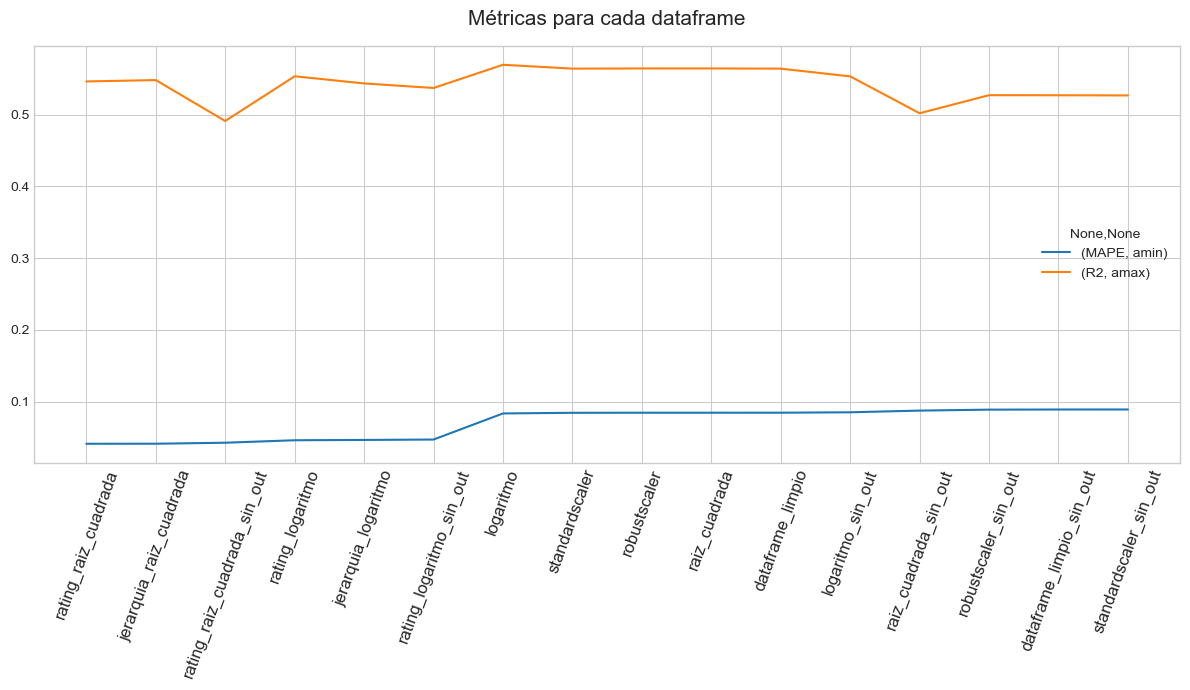

In [127]:
lista_nombres = ['rating_raiz_cuadrada', 'jerarquia_raiz_cuadrada', 'rating_raiz_cuadrada_sin_out',
                'rating_logaritmo', 'jerarquia_logaritmo', 'rating_logaritmo_sin_out', 'logaritmo',
                'standardscaler', 'robustscaler', 'raiz_cuadrada', 'dataframe_limpio', 'logaritmo_sin_out',
                'raiz_cuadrada_sin_out', 'robustscaler_sin_out', 'dataframe_limpio_sin_out', 'standardscaler_sin_out']

fig, ax1 = plt.subplots(figsize=(12, 7))
metric_sort.plot(kind='line', ax=ax1)
ax1.tick_params(axis='x', rotation=70, labelsize=12)
ax1.set_title('Métricas para cada dataframe', fontsize=15, pad=15)
ax1.set_xticks(range(len(metric_sort.index)))
ax1.set_xticklabels(lista_nombres)
ax1.set_xlabel('')
ax1.set_facecolor('none')

plt.tight_layout()
# guarda la imagen transparente
plt.savefig('imagen_df_metricas.png', transparent=True)
plt.show()

    En el gráfico se observa que el preprocesamiento de los datos jerarquia_raiz_cuadrada logra mejores resultados que los demás, alcanzando el mejor MAPE, sin embargo muestra un R2 ligeramente más bajo.
    En comparación al modelo basado en transformación logarítmica (logaritmo) no difiere en gran escala (-0.0229).

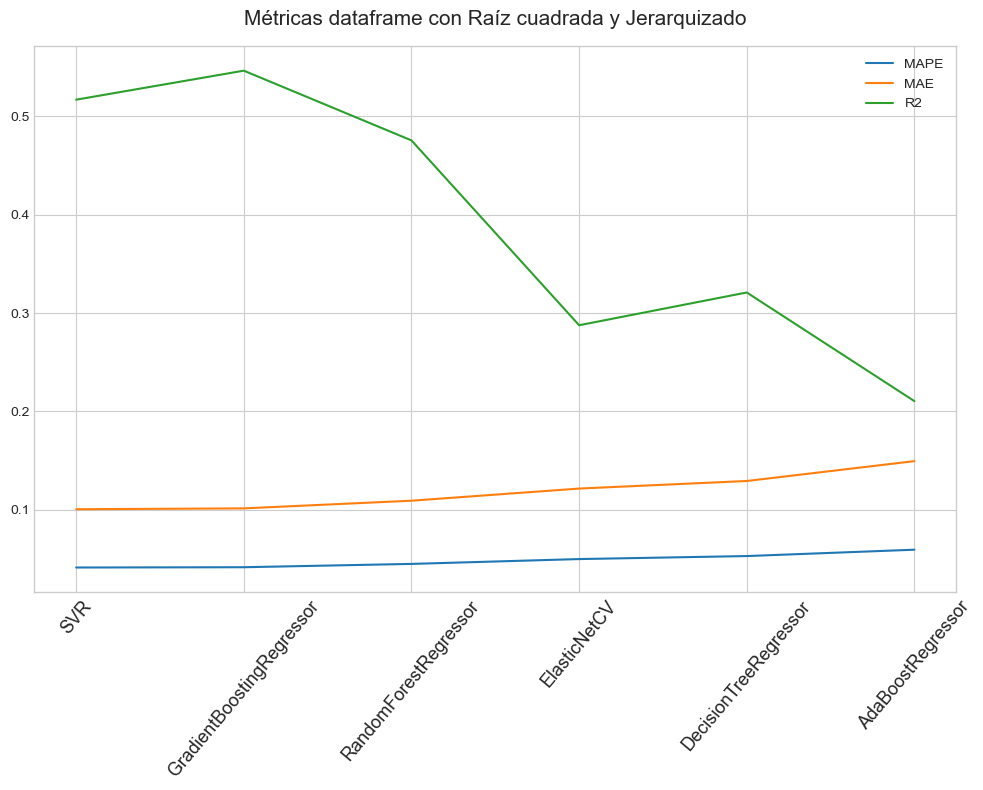

In [128]:
lista_modelos = ['','SVR', 'GradientBoostingRegressor', 'RandomForestRegressor',
                'ElasticNetCV','DecisionTreeRegressor', 'AdaBoostRegressor','']

fig, ax2 = plt.subplots(figsize=(10, 8))
df_metricas_iteracion_1.loc[df_metricas_iteracion_1['id_df'] == 'df_sqrt_jerarquia_modelacion'].plot(kind='line', ax=ax2)
ax2.tick_params(axis='x', rotation=50, labelsize=13)
ax2.set_title('Métricas dataframe con Raíz cuadrada y Jerarquizado', fontsize=15, pad=15)
ax2.set_xticklabels(lista_modelos)
ax2.set_facecolor('none')

plt.tight_layout()
# guarda la imagen transparente
plt.savefig('imagen_metricas_jerarquizado.png', transparent=True)
plt.show()

    Dentro de los modelos con transformación de raíz cuadrada y jerarquizado, los mejores son:
    - SVR
    - Gradient Boosting Regressor
    - Random Forest Regressor
    - Elastic Net

##### <span style="color:orange"> Guardado del mejor Dataframe en archivo .pkl

In [129]:
df_sqrt_jerarquia_modelacion = dict_df_para_modelacion['df_sqrt_jerarquia_modelacion']

# guardado en archivo .pkl
pickle.dump(df_sqrt_jerarquia_modelacion, open('df_sqrt_jerarquia_modelacion.pkl', 'wb'))

### <span style="color:#87CEEB"> 8.6.- Voting Regressor

In [130]:
estimadores = [
        ('SVR', SVR()),
        ('Gradient_Boosting_Regressor', GradientBoostingRegressor()),
        ('Random_Forest_Regressor', RandomForestRegressor()),
        ('Elastic_Net', ElasticNetCV())]

In [131]:
voting_model = VotingRegressor(estimators=estimadores,
                                verbose=True,
                                n_jobs=-1
                                )

In [132]:
_, _, _ = probar_modelos(voting_model,
                        df_sqrt_jerarquia_modelacion.drop(columns='rating', axis=1),
                        df_sqrt_jerarquia_modelacion['rating'], imprime=True, gen_modelacion=False)

VotingRegressor(estimators=[('SVR', SVR()),
                            ('Gradient_Boosting_Regressor',
                             GradientBoostingRegressor()),
                            ('Random_Forest_Regressor',
                             RandomForestRegressor()),
                            ('Elastic_Net', ElasticNetCV())],
                n_jobs=-1, verbose=True) 
 Métricas en train:
 MAPE train: 0.03786938929294248 
 MAE train: 0.09150823784425018 
 R2 train: 0.6382237878267716 
 -------------------------------------------------- 
Métricas en test:
 MAPE test: 0.04271156430583732 
 MAE test: 0.1035090705582567 
 R2 test: 0.5265239792278176 
 --------------------------------------------------


    Como se espera el comportamiento de Voting muestra ser similar a los modelos previamente testeados, por lo que se suma a la cartera de modelos a estudiar.

### <span style="color:#87CEEB"> 8.7.- Selección de modelos
    - SVR
    - Gradient Boost
    - Random Forest
    - Elastic Net
    - Voting Regressor

### <span style="color:#87CEEB"> 8.8.- Prueba de red neuronal

In [133]:
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD

X = df_sqrt_jerarquia_modelacion.drop(columns='rating', axis=1)
y = df_sqrt_jerarquia_modelacion['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=10)

In [134]:
# Definir la arquitectura de la red neuronal
model = Sequential()
model.add(Dense(32, input_dim=3232, activation='sigmoid'))  # Capa de entrada
model.add(Dense(16, activation='softsign'))  # Capa oculta
model.add(Dense(1))  # Capa de salida sin función de activación para regresión

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
264/264 [==============================] - 1s 2ms/step - loss: 0.1389 - mean_squared_error: 0.1389
Epoch 2/10
264/264 [==============================] - 1s 2ms/step - loss: 0.0241 - mean_squared_error: 0.0241
Epoch 3/10
264/264 [==============================] - 1s 2ms/step - loss: 0.0223 - mean_squared_error: 0.0223
Epoch 4/10
264/264 [==============================] - 1s 2ms/step - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 5/10
264/264 [==============================] - 1s 3ms/step - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 6/10
264/264 [==============================] - 1s 2ms/step - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 7/10
264/264 [==============================] - 1s 2ms/step - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 8/10
264/264 [==============================] - 1s 3ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 9/10
264/264 [==============================] - 1s 3ms/step - loss: 0.0169 - mean_squared_error: 0.0169
Epoch 10/1

In [135]:
# predicciones red neuronal
y_hat = model.predict(X_test)

  1/114 [..............................] - ETA: 12s

114/114 [==============================] - 0s 2ms/step


In [136]:
# métricas red neuronal
print(f'''red neuronal
MAPE: {mean_absolute_percentage_error(y_true=y_test, y_pred=y_hat)}
MAE: {mean_absolute_error(y_true=y_test, y_pred=y_hat)}
R2: {r2_score(y_true=y_test, y_pred=y_hat)}''')

red neuronal
MAPE: 0.041814898795045685
MAE: 0.10141678766515429
R2: 0.5417965727970245


## <span style="color:#87CEEB"> **9.- Segunda Iteración de modelos**

### <span style="color:#87CEEB"> 9.1- Importación Dataframe

In [137]:
''' Importación de dataframes para evitar correr la totalidad del jupyter notebook 
y causar demora para los integrantes del equipo de trabajo'''

# carga de archivo .pkl df_sqrt_jerarquia_modelacion
df_sqrt_jerarquia_modelacion = pickle.load(open('df_sqrt_jerarquia_modelacion.pkl', 'rb')) 

In [138]:
#  matriz de atributos
X = df_sqrt_jerarquia_modelacion.drop(columns='rating', axis=1)

# vector objetivo
y = df_sqrt_jerarquia_modelacion['rating']

# matriz escalada para SVR y ElasticNetCV
X_scaled = escalador_simple(X)

### <span style="color:#87CEEB"> 9.2- Modelación con Grillas

#### <span style="color:#87CEEB"> 9.2.1.- SVR

In [139]:
# Grilla hiperparámetros
param_grid_svr = {
                'kernel': ['rbf'], # valor por defecto
                'C': [10, 50, 100],
                'epsilon': [0.2, 0.5, 0.9],
                'gamma': ['auto'], # valor por defecto: 'scale'
                'shrinking': [True], #por defecto
                'cache_size': [100, 300]
}


# Guardado grilla
grid_svr = GridSearchCV(SVR(),
                        param_grid=param_grid_svr,
                        cv=5,
                        verbose=1,
                        n_jobs=-1)


# Entrenar modelo (est: 5 min)
modelacion_svr = probar_modelos(grid_svr, X_scaled, y, test_size=.3, random_state=10, imprime=True, gen_modelacion=True)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [10, 50, 100], 'cache_size': [100, 300],
                         'epsilon': [0.2, 0.5, 0.9], 'gamma': ['auto'],
                         'kernel': ['rbf'], 'shrinking': [True]},
             verbose=1) 
 Métricas en train:
 MAPE train: 0.04970075138422503 
 MAE train: 0.12295504550263321 
 R2 train: 0.4598399617116582 
 -------------------------------------------------- 
Métricas en test:
 MAPE test: 0.05254886255085324 
 MAE test: 0.13025144100766162 
 R2 test: 0.35548431445901696 
 --------------------------------------------------


In [140]:
# guardado en archivo .pkl
pickle.dump(modelacion_svr, open('modelacion_svr.pkl', 'wb'))

In [141]:
modelacion_svr['modelo_fit'].best_params_

{'C': 10,
 'cache_size': 100,
 'epsilon': 0.2,
 'gamma': 'auto',
 'kernel': 'rbf',
 'shrinking': True}

In [142]:
modelacion_svr['modelo_fit'].best_estimator_

SVR(C=10, cache_size=100, epsilon=0.2, gamma='auto')

##### <span style="color:orange"> Gráficos del error por rango para SVR

In [143]:
rangos_yhat_svr = creacion_rangos(modelacion_svr)

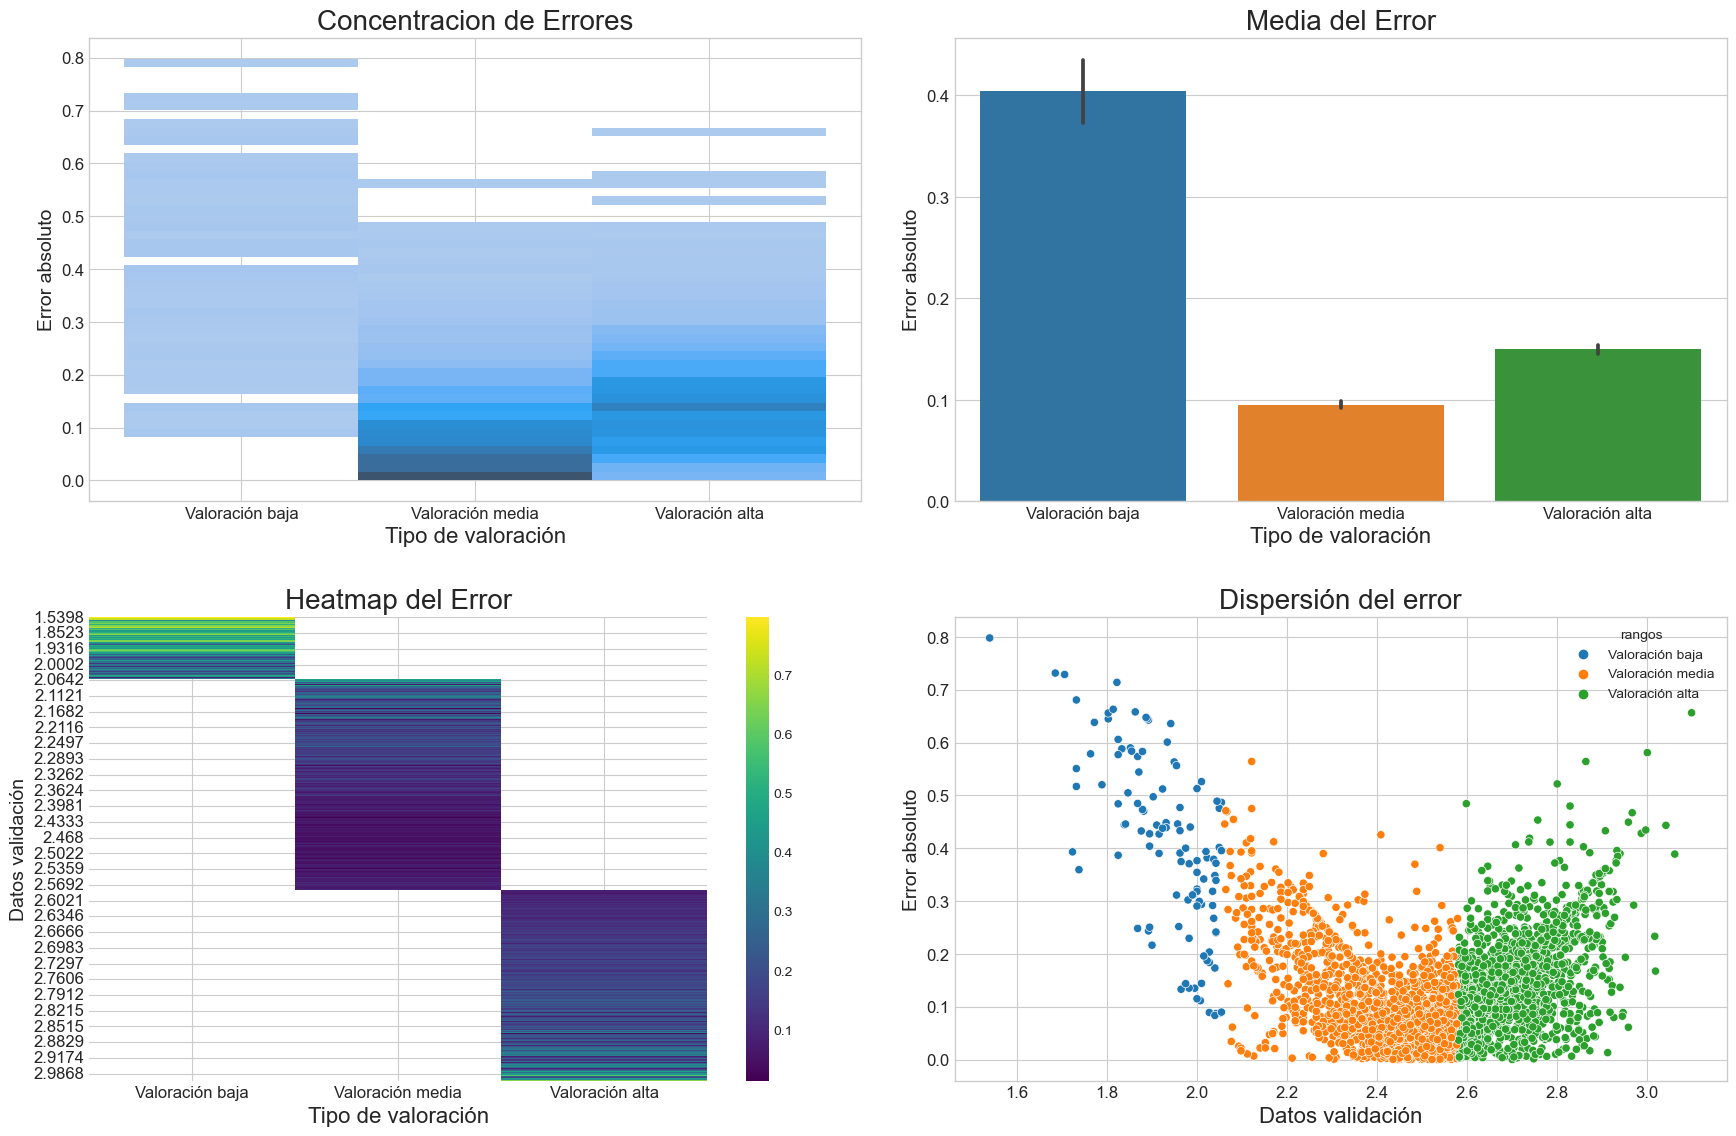

In [144]:
graficar_error(rangos_yhat_svr)

#### <span style="color:#87CEEB"> 9.2.2.- GRADIENT BOOSTING

In [145]:
# Grilla hiperparámetros
param_grid_gboost = {
    'n_estimators': [1, 10, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5, 1, 5, 10],
    'subsample': np.linspace(0.1, 1.0, 10, endpoint=True, dtype=float),
}
# Guardado Grilla
grid_gboost = GridSearchCV(GradientBoostingRegressor(random_state=10),
                            param_grid=param_grid_gboost,
                            cv=5,
                            verbose=1,
                            n_jobs=-1)

# Entrenar modelo (est: 13min)
modelacion_gboost = probar_modelos(grid_gboost, X, y, test_size=.3, random_state=10, imprime=True, gen_modelacion = True)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1, 5, 10],
                         'n_estimators': [1, 10, 50, 100],
                         'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             verbose=1) 
 Métricas en train:
 MAPE train: 0.03819631470451947 
 MAE train: 0.09311828829301044 
 R2 train: 0.6407254767854436 
 -------------------------------------------------- 
Métricas en test:
 MAPE test: 0.040826040417039994 
 MAE test: 0.09924255775499233 
 R2 test: 0.559839560655064 
 --------------------------------------------------


In [146]:
# guardado en archivo .pkl
pickle.dump(modelacion_gboost, open('modelacion_gboost.pkl', 'wb'))

In [147]:
modelacion_gboost['modelo_fit'].best_params_

{'learning_rate': 0.5, 'n_estimators': 100, 'subsample': 1.0}

In [148]:
modelacion_gboost['modelo_fit'].best_estimator_

GradientBoostingRegressor(learning_rate=0.5, random_state=10)

##### <span style="color:orange">  Gráficos del error por rango para Gradient Boosting

In [149]:
rangos_yhat_gboost = creacion_rangos(modelacion_gboost, funcion=np.square)

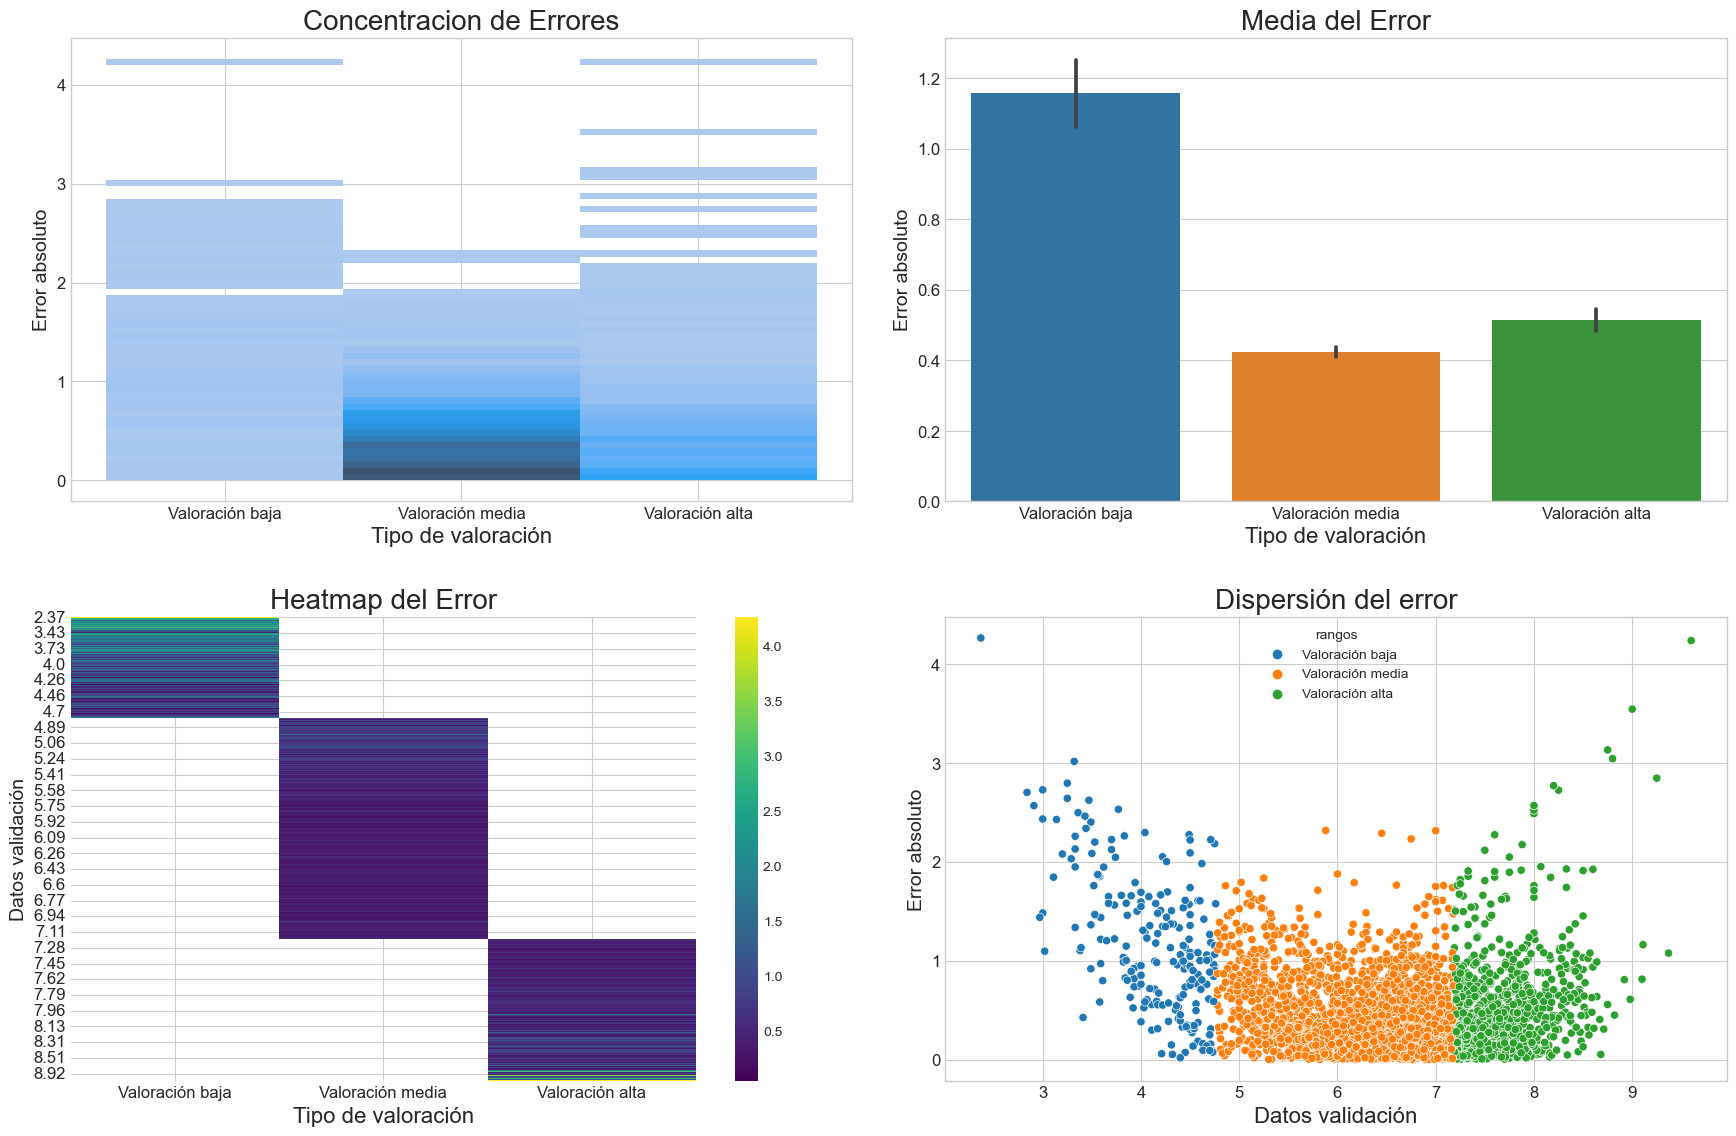

In [150]:
graficar_error(rangos_yhat_gboost)

##### <span style="color:orange"> Gráfico de importancia de variables Gradient Boosting

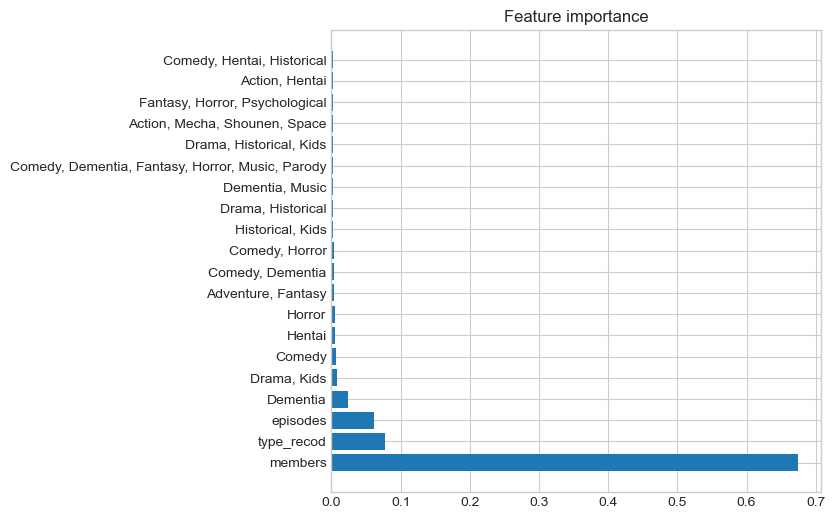

In [151]:
graficar_importancia(modelacion_gboost['modelo_fit'].best_estimator_, X.columns, nro_a_imprimir=20);
plt.savefig('imagen_feature_importance_gboost.png', bbox_inches='tight', transparent=True) 

#### <span style="color:#87CEEB"> 9.2.3.- Random Forest

In [152]:
# Grilla hiperparámetros
param_grid_rf = {
                'max_depth':[10, 100],
                'n_estimators':[1, 10],
                'min_samples_split':[0.001, 1],
                'min_samples_leaf':[0.001, 1],
}

# Guardado grilla
grid_rf = GridSearchCV(RandomForestRegressor(random_state=10, warm_start=True, max_features=None),
                        param_grid=param_grid_rf,
                        cv=5,
                        verbose=5,
                        n_jobs=-1)


# Entrenar modelo (est: 15 seg)
modelacion_rf = probar_modelos(grid_rf, X, y, test_size=.3, random_state=10, imprime=True, gen_modelacion=True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features=None, random_state=10,
                                             warm_start=True),
             n_jobs=-1,
             param_grid={'max_depth': [10, 100], 'min_samples_leaf': [0.001, 1],
                         'min_samples_split': [0.001, 1],
                         'n_estimators': [1, 10]},
             verbose=5) 
 Métricas en train:
 MAPE train: 0.03949786893732971 
 MAE train: 0.09614099059744644 
 R2 train: 0.6095567377083133 
 -------------------------------------------------- 
Métricas en test:
 MAPE test: 0.04137130719215193 
 MAE test: 0.10076908133641096 
 R2 test: 0.5435974147711499 
 --------------------------------------------------


In [153]:
# guardado en archivo .pkl
pickle.dump(modelacion_rf, open('modelacion_rf.pkl', 'wb'))

In [154]:
modelacion_rf['modelo_fit'].best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 0.001,
 'n_estimators': 10}

In [155]:
modelacion_rf['modelo_fit'].best_estimator_

RandomForestRegressor(max_depth=10, max_features=None, min_samples_split=0.001,
                      n_estimators=10, random_state=10, warm_start=True)

##### <span style="color:orange">  Gráficos del error por rango para Random Forest

In [156]:
rangos_yhat_random_forest = creacion_rangos(modelacion_rf)

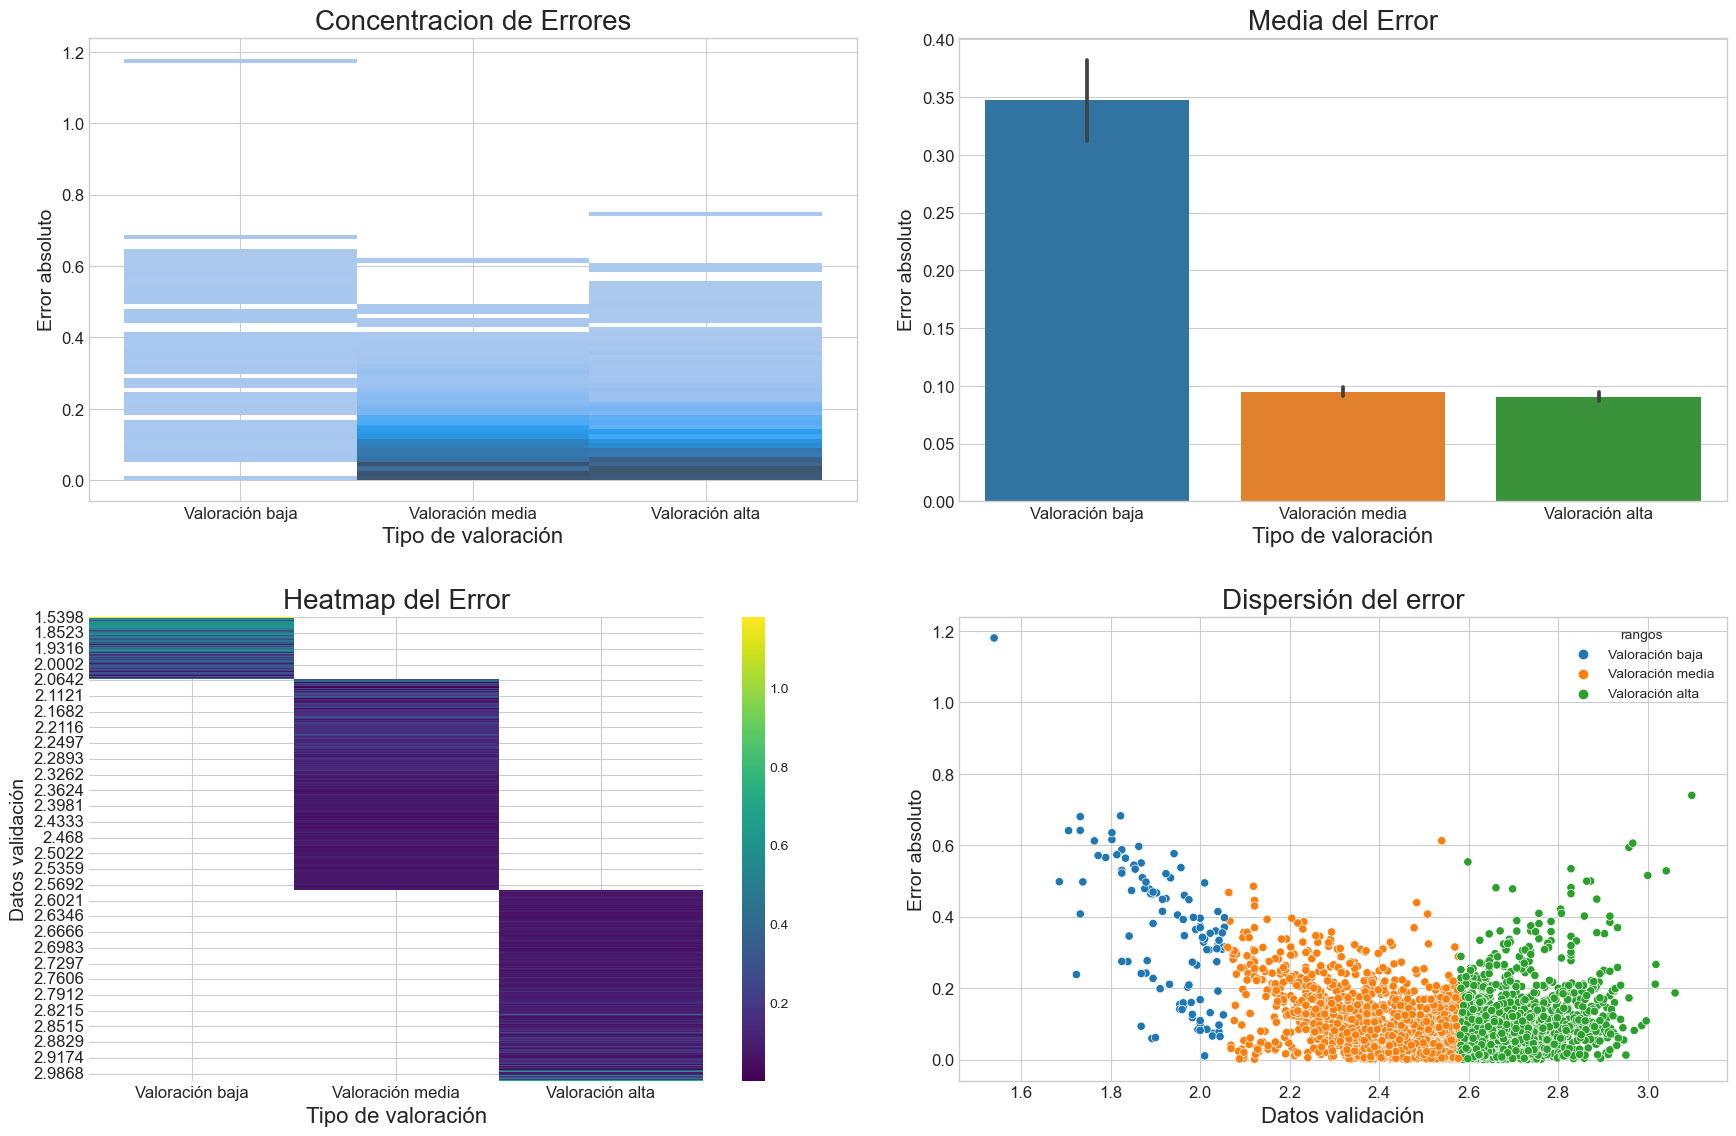

In [157]:
graficar_error(rangos_yhat_random_forest)

##### <span style="color:orange"> Gráfico de importancia de variables Random Forest

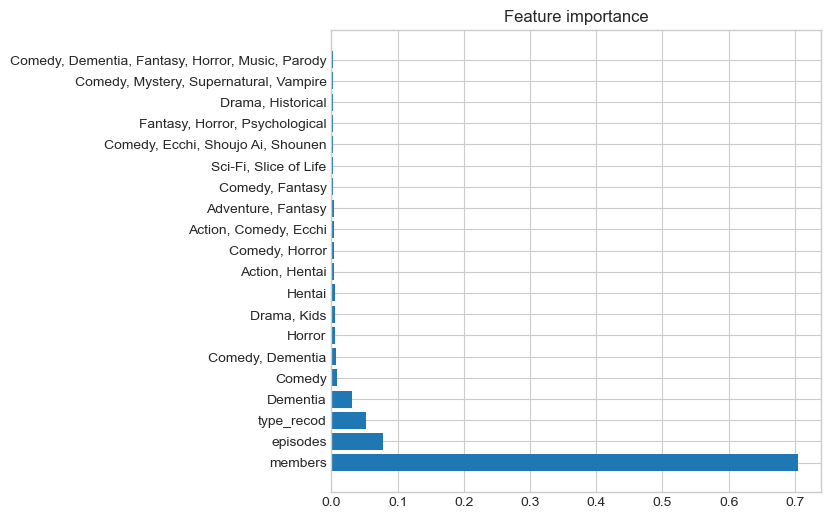

In [158]:
graficar_importancia(modelacion_rf['modelo_fit'].best_estimator_, X.columns, nro_a_imprimir=20);
plt.savefig('imagen_feature_importance_random_forest.png', bbox_inches='tight', transparent=True) 

#### <span style="color:#87CEEB"> 9.2.4.- ElasticNetCV

In [159]:
# Grilla hiperparámetros
param_grid_elasticnet = {
    'eps': [0.001, 0.01, 0.1],
    'fit_intercept': [True, False],
    'n_alphas': [100, 200, 300],   
    'selection': ['cyclic', 'random']
}

# Guardado Grilla
model_elasticnet = GridSearchCV(ElasticNetCV(random_state=10),
                                param_grid=param_grid_elasticnet,
                                cv=5,
                                verbose=1,
                                n_jobs=-1)


# Entrenar modelo (est: 81 min)
modelacion_elasticnet = probar_modelos(model_elasticnet, X_scaled, y, test_size=.3, random_state=10, imprime=True, gen_modelacion=True)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
GridSearchCV(cv=5, estimator=ElasticNetCV(random_state=10), n_jobs=-1,
             param_grid={'eps': [0.001, 0.01, 0.1],
                         'fit_intercept': [True, False],
                         'n_alphas': [100, 200, 300],
                         'selection': ['cyclic', 'random']},
             verbose=1) 
 Métricas en train:
 MAPE train: 0.04309187757839691 
 MAE train: 0.10461497712592126 
 R2 train: 0.5446297330680122 
 -------------------------------------------------- 
Métricas en test:
 MAPE test: 0.048178402260311275 
 MAE test: 0.11743287007471162 
 R2 test: 0.4284464418492935 
 --------------------------------------------------


In [160]:
# guardado en archivo .pkl
pickle.dump(modelacion_elasticnet, open('modelacion_elasticnet.pkl', 'wb'))

In [161]:
modelacion_elasticnet['modelo_fit'].best_params_

{'eps': 0.01, 'fit_intercept': True, 'n_alphas': 200, 'selection': 'cyclic'}

In [162]:
modelacion_elasticnet['modelo_fit'].best_estimator_

ElasticNetCV(eps=0.01, n_alphas=200, random_state=10)

##### <span style="color:orange">  Gráficos del error por rango para ElasticNetCV

In [163]:
rangos_yhat_elasticnet = creacion_rangos(modelacion_elasticnet)

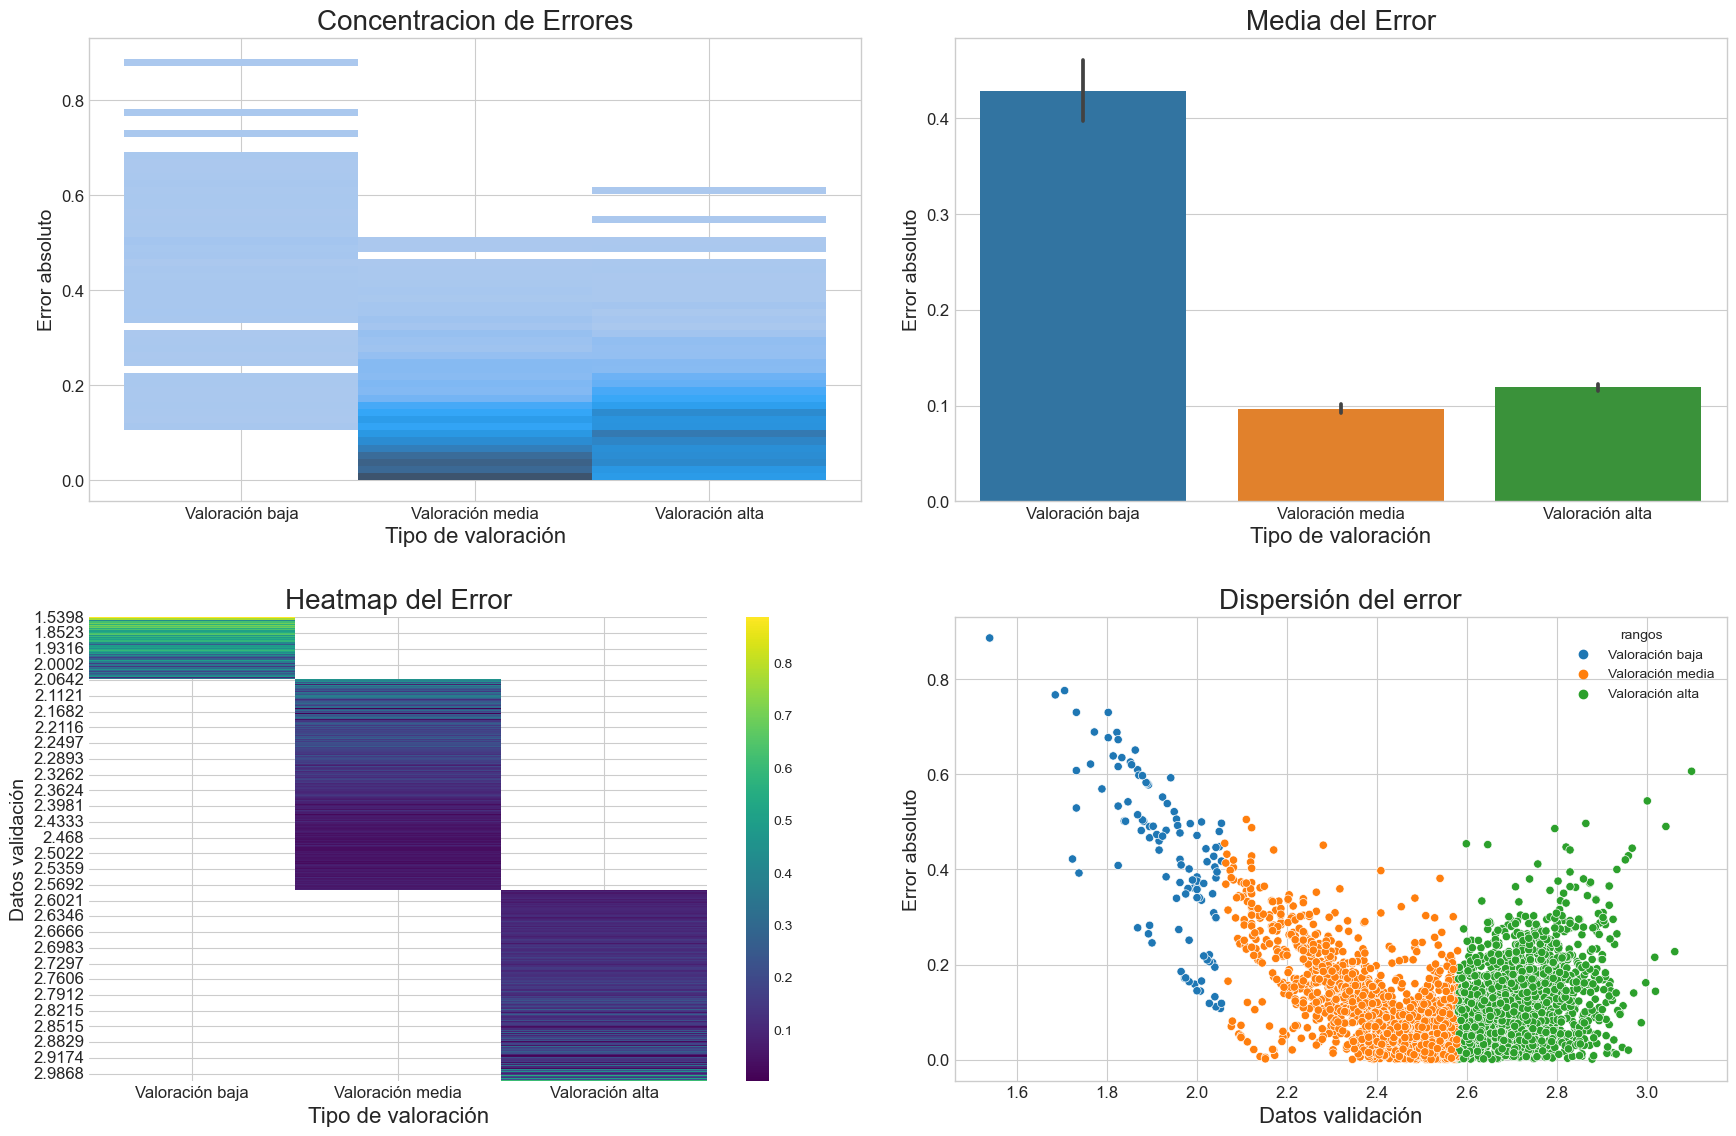

In [164]:
graficar_error(rangos_yhat_elasticnet)

#### <span style="color:#87CEEB"> 9.2.5.- Voting Regressor

In [165]:
estimadores = [
        ('SVR', modelacion_svr['modelo_fit'].best_estimator_),
        ('Gradient_Boosting_Regressor', modelacion_gboost['modelo_fit'].best_estimator_),
        ('Random_Forest_Regressor', modelacion_rf['modelo_fit'].best_estimator_),
        ('Elastic_Net', modelacion_elasticnet['modelo_fit'].best_estimator_)]

In [166]:
voting_model = VotingRegressor(estimators=estimadores,
                                verbose=True,
                                n_jobs=-1
                                )

In [167]:
modelacion_voting = probar_modelos(voting_model, X, y, random_state=10, imprime=True, gen_modelacion=True)

VotingRegressor(estimators=[('SVR',
                             SVR(C=10, cache_size=100, epsilon=0.2,
                                 gamma='auto')),
                            ('Gradient_Boosting_Regressor',
                             GradientBoostingRegressor(learning_rate=0.5,
                                                       random_state=10)),
                            ('Random_Forest_Regressor',
                             RandomForestRegressor(max_depth=10,
                                                   max_features=None,
                                                   min_samples_split=0.001,
                                                   n_estimators=10,
                                                   random_state=10,
                                                   warm_start=True)),
                            ('Elastic_Net',
                             ElasticNetCV(eps=0.01, n_alphas=200,
                                          random_state=1

In [168]:
rangos_yhat_voting = creacion_rangos(modelacion_voting)

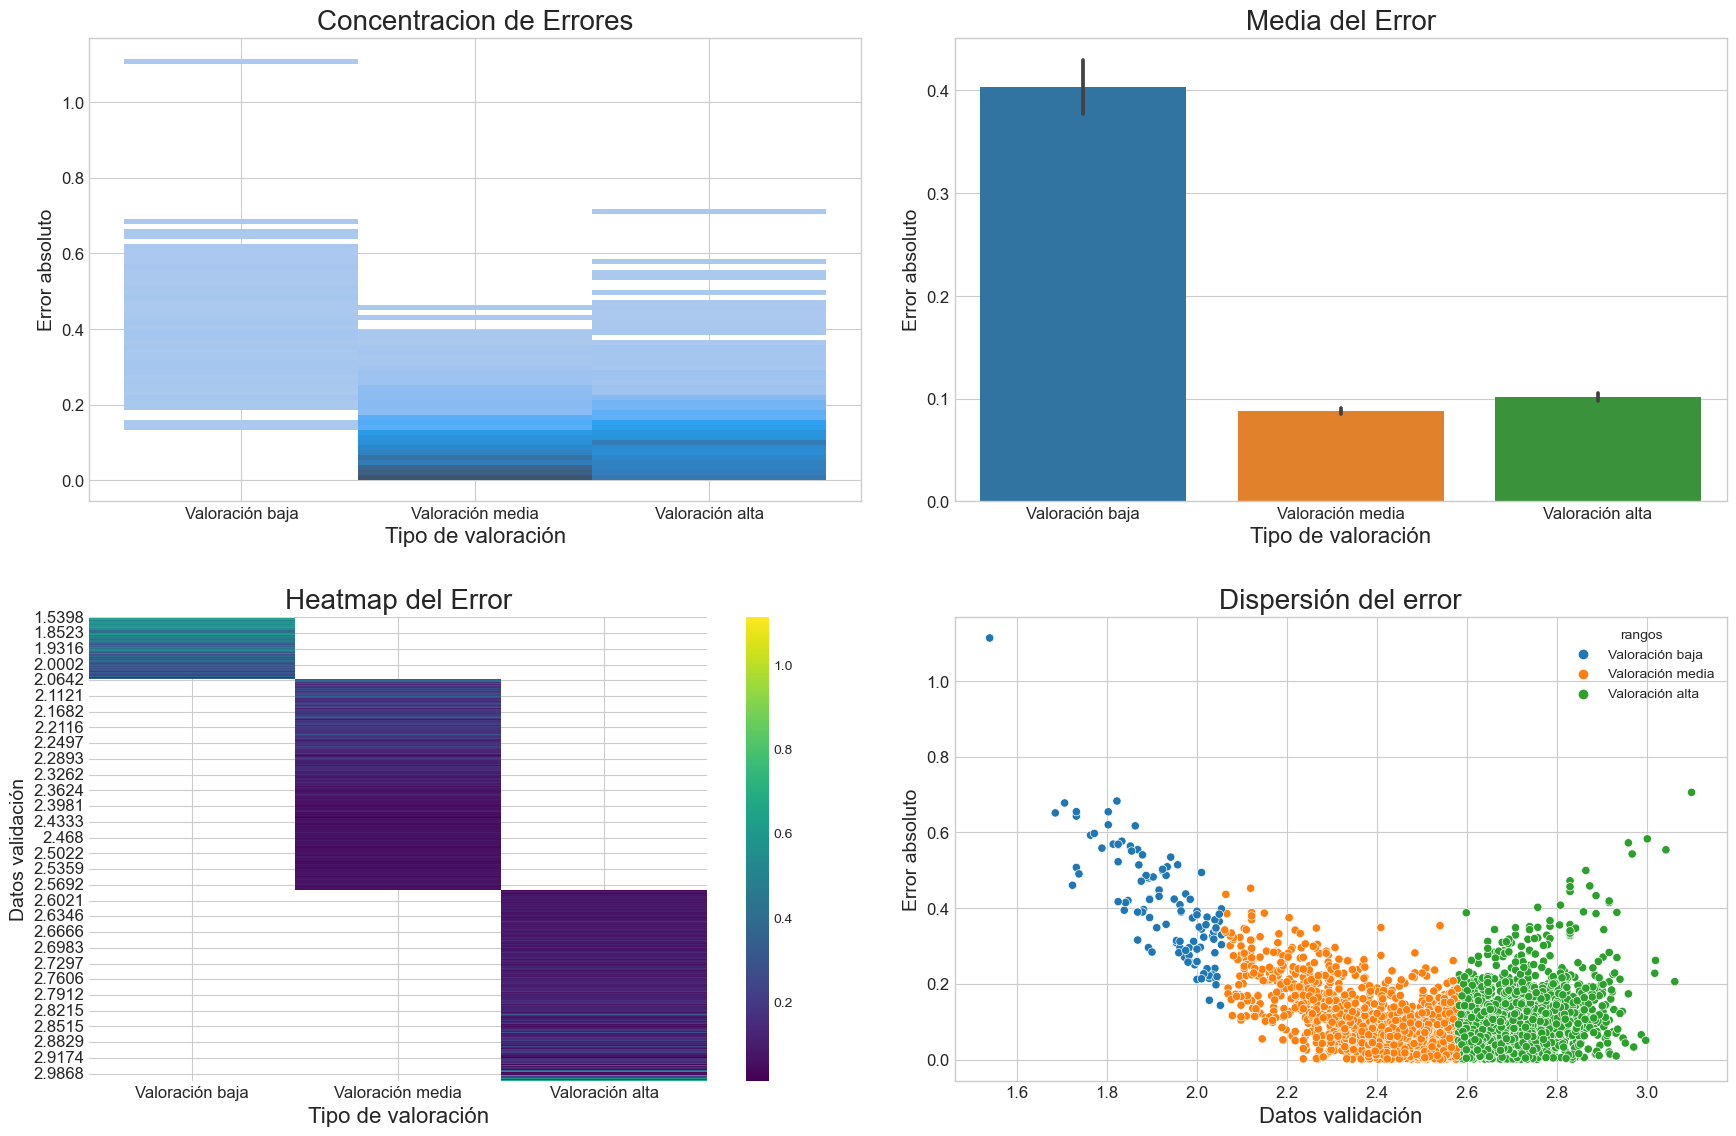

In [169]:
graficar_error(rangos_yhat_voting)

### <span style="color:#87CEEB"> 9.3.- Mejor Modelo

In [170]:
modelos_finales = {
    'SVR' : modelacion_svr, 
    'Gradient Boost' : modelacion_gboost,
    'Random Forest' : modelacion_rf, 
    'Elastic Net' : modelacion_elasticnet,
    'Voting' : modelacion_voting
}

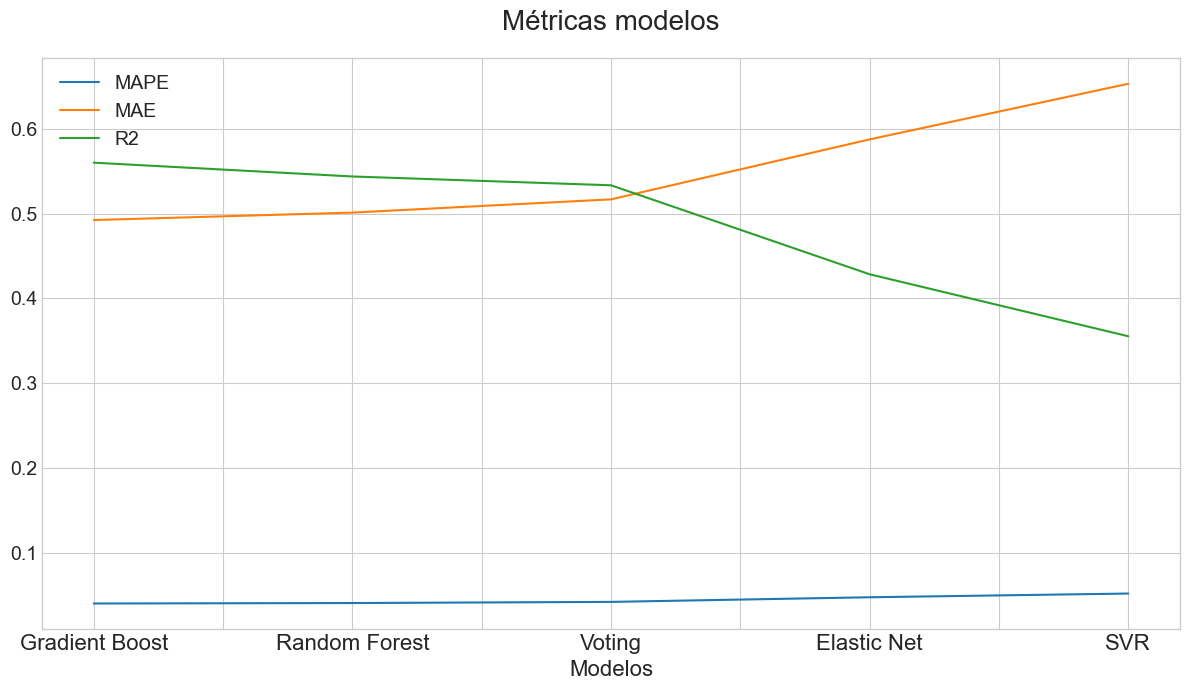

MAPE train  MAE train  R2 train  MAPE test  MAE test   R2 test
Gradient Boost    0.038196   0.462614  0.640725   0.040826  0.492312  0.559840
Random Forest     0.039498   0.477018  0.609557   0.041371  0.501063  0.543597
Voting            0.042380   0.510936  0.560919   0.042727  0.516657  0.533214
Elastic Net       0.043092   0.520418  0.544630   0.048178  0.587249  0.428446
SVR               0.049701   0.615000  0.459840   0.052549  0.652753  0.355484

In [229]:
metricas = resultados_modelacion_sqrt(modelos_finales)
display(metricas_transformacion_inversa(modelos_finales))

    * Los indicadores, principalmente el MAPE muestra un comportamiento estable para los modelos.
    * Los modelos que utilizan árboles de decisión como base muestran mejor desempeño que los demás modelos.
    * En conclusión, el mejor modelo se logra mediante Gradient Boosting Regressor con un error porcentual de 4%.

## <span style="color:#87CEEB"> **10.- Conclusiones**

### <span style="color:#87CEEB"> 10.1.- Comparación de resultados

In [172]:
#Encontrar metricas de df_clean con el modelo Gboost
metricas_gboost_clean =  df_metricas_iteracion_1.loc[df_metricas_iteracion_1.index == 'df_clean_modelacion_GradientBoostingRegressor()']

#Concatenar metricas de df_clean con el modelo Gboost y el mejor modelo Gboost con jerarquia en type y SQRT
metricas_concat = pd.concat([metricas.head(1), metricas_gboost_clean])

#renombrar para el grafico
metricas_concat = metricas_concat.rename(index = {'Gradient Boost':'GB jerarquia y sqrt',
                                                'df_clean_modelacion_GradientBoostingRegressor()':'GB df clean'})

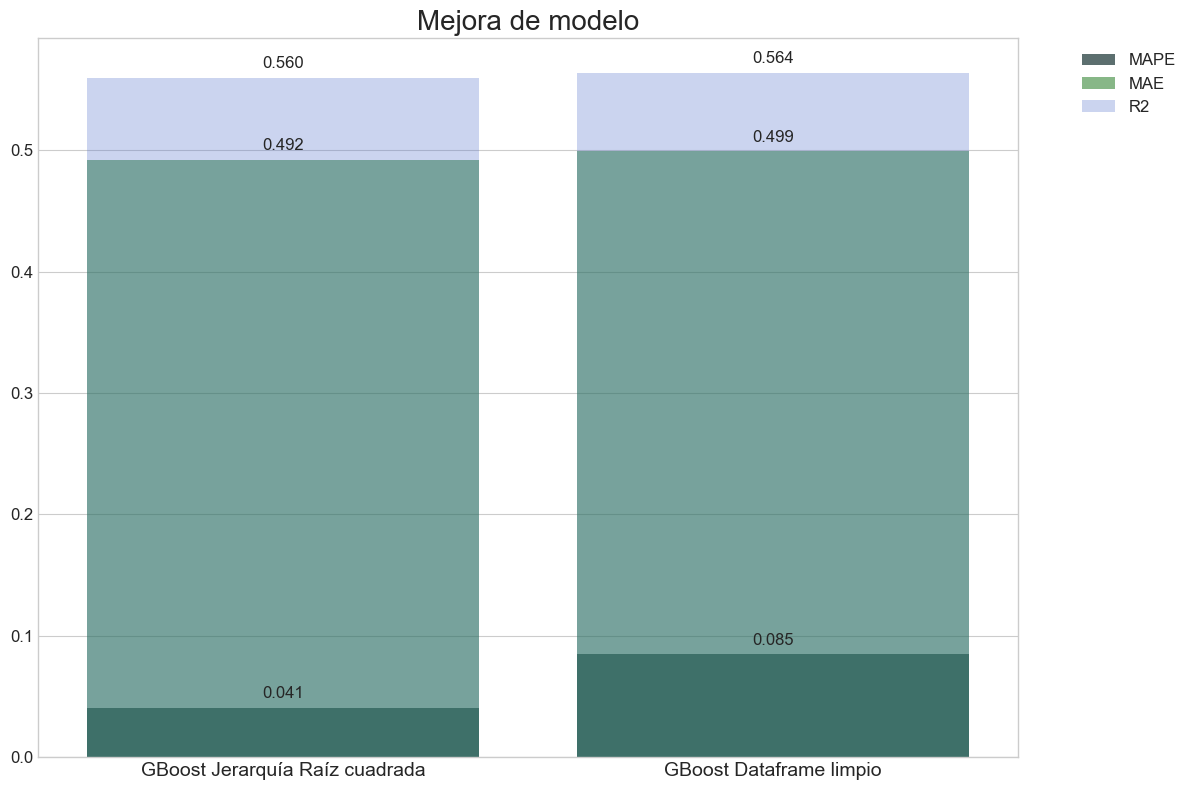

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_facecolor('none')  # Fondo transparente

sns.barplot(data=metricas_concat, y='MAPE', x=metricas_concat.index, color='darkslategray', alpha=0.8, label='MAPE', ax=ax, dodge=True)
sns.barplot(data=metricas_concat, y='MAE', x=metricas_concat.index, color='green', alpha=0.5, label='MAE', ax=ax, dodge=True)
sns.barplot(data=metricas_concat, y='R2', x=metricas_concat.index, color='royalblue', alpha=0.3, label='R2', ax=ax, dodge=True)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

new_xticklabels = ['GBoost Jerarquía Raíz cuadrada', 'GBoost Dataframe limpio']  
ax.set_xticklabels(new_xticklabels, fontsize=14)
ax.tick_params(axis='y', labelsize=12)

plt.title('Mejora de modelo', fontsize=20)
plt.ylabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', fontsize=12)
plt.tight_layout()

# Guardar el gráfico en formato PNG con fondo transparente
plt.savefig('imagen_mejora_modelo.png', transparent=True)
plt.show()

    Se observa como al comparar un modelo basado en Gradient Boosting sin transformación en sus atributos ni vector objetivo, y posterior búsqueda de sus mejores hiper-parámetros para modelación, se obtienen resultados de los que se concluye:
        * R cuadrado se mantiene similar.
        * MAPE baja considerablemente llegando al 4%, el MAE muestra una leve mejora.

### <span style="color:#87CEEB"> 10.2.- Completar datos perdidos en matriz nulos.

In [174]:
df_test_nulos

name  \
8968                                     Inazma Delivery   
9657   Nananin no Ayakashi: Chimi Chimi Mouryou!! Gen...   
10896                                     Gintama (2017)   
10897                                    One Punch Man 2   
10898                                      Steins;Gate 0   
...                                                  ...   
12274  Nuki Doki! Tenshi to Akuma no Sakusei Battle -...   
12279                       Sagurare Otome The Animation   
12280                                       Saimin Class   
12282                    Shikkoku no Shaga The Animation   
12285                                   Taimanin Asagi 3   

                                                   genre type  episodes  \
8968                              Action, Comedy, Sci-Fi   TV      10.0   
9657                                Comedy, Supernatural   TV       1.0   
10896  Action, Comedy, Historical, Parody, Samurai, S...   TV       1.0   
10897  Action, Comedy, Parody, Sci-Fi, Seinen, Super ...   TV       1.0   
10898                                   Sci-Fi, Thriller   TV       1.0   
...                                                  ...  ...       ...   
12274                                             Hentai  OVA       1.0   
12279                                             Hentai  OVA       1.0   
12280                                             Hentai  OVA       1.0   
12282                                             Hentai  OVA       1.0   
12285                       Demons, Hentai, Supernatural  OVA       1.0   

       members  rating  
8968        32     NaN  
9657       129     NaN  
10896    13383     NaN  
10897    90706     NaN  
10898    60999     NaN  
...        ...     ...  
12274      392     NaN  
12279       79     NaN  
12280      240     NaN  
12282      195     NaN  
12285      485     NaN  

[230 rows x 6 columns]

In [175]:
var_a_escalar = ['episodes','members']
var_sin_escalar = ['name', 'genre', 'type']
df_test_nulos_sqrt = dataframe_scaler(df_test_nulos, np.sqrt, var_a_escalar, var_sin_escalar)

# Definir recodificación
type_recod = {
    'Movie': 4,
    'TV': 1,
    'OVA': 3,
    'Special': 2,
    'Music': 6,
    'ONA': 5
}
# Recodificar
df_test_nulos_sqrt['type_recod'] = df_test_nulos_sqrt['type'].map(type_recod)

df_test_nulos_sqrt = df_test_nulos_sqrt.drop(columns='type', axis=1)

# OHE y concatenación para sqrt
tmp_dummies = pd.get_dummies(df_test_nulos_sqrt[['genre']])
tmp_ep_mem = df_test_nulos_sqrt.loc[:, ['type_recod','episodes', 'members']]
df_test_nulos_sqrt_input = pd.concat([tmp_ep_mem, tmp_dummies], axis=1)

In [176]:
print(f'Columnas en matriz modelo: {X.shape[1]}')
print(f'Columnas en matriz prueba con nulos: {df_test_nulos_sqrt_input.shape[1]}')

Columnas en matriz modelo: 3232
Columnas en matriz prueba con nulos: 171


In [177]:
lista_diferencias = df1_vs_df2(df_test_nulos_sqrt_input, X)
df_test_nulos_sqrt_input = df_test_nulos_sqrt_input.drop(columns=lista_diferencias, axis=1)

input_test = pd.DataFrame(columns=X.columns)
input_test = input_test.append(df_test_nulos_sqrt_input, ignore_index=True).replace({np.nan:0})

y_pred_nan = np.square(modelacion_gboost['modelo_fit'].predict(input_test))-0.001

df_test_nulos['rating_pred']= y_pred_nan

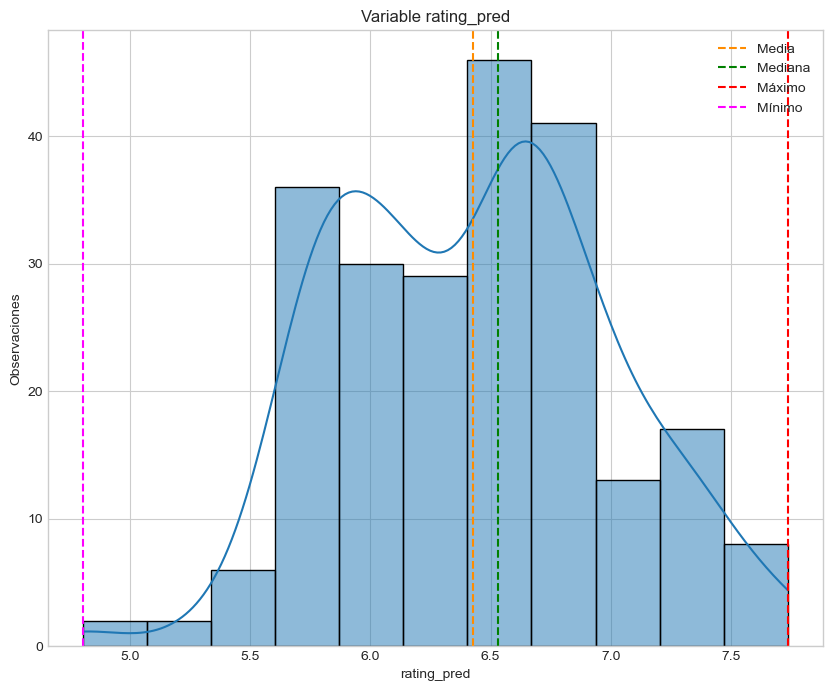

In [178]:
graficar_cont(df_test_nulos, ['rating_pred'],
            figura=(10,8), sep_plot=0.4, cols=1)

In [179]:
# guardado de df_test_nulos en archivo csv
df_test_nulos.to_csv('df_test_nulos.csv', index=False)

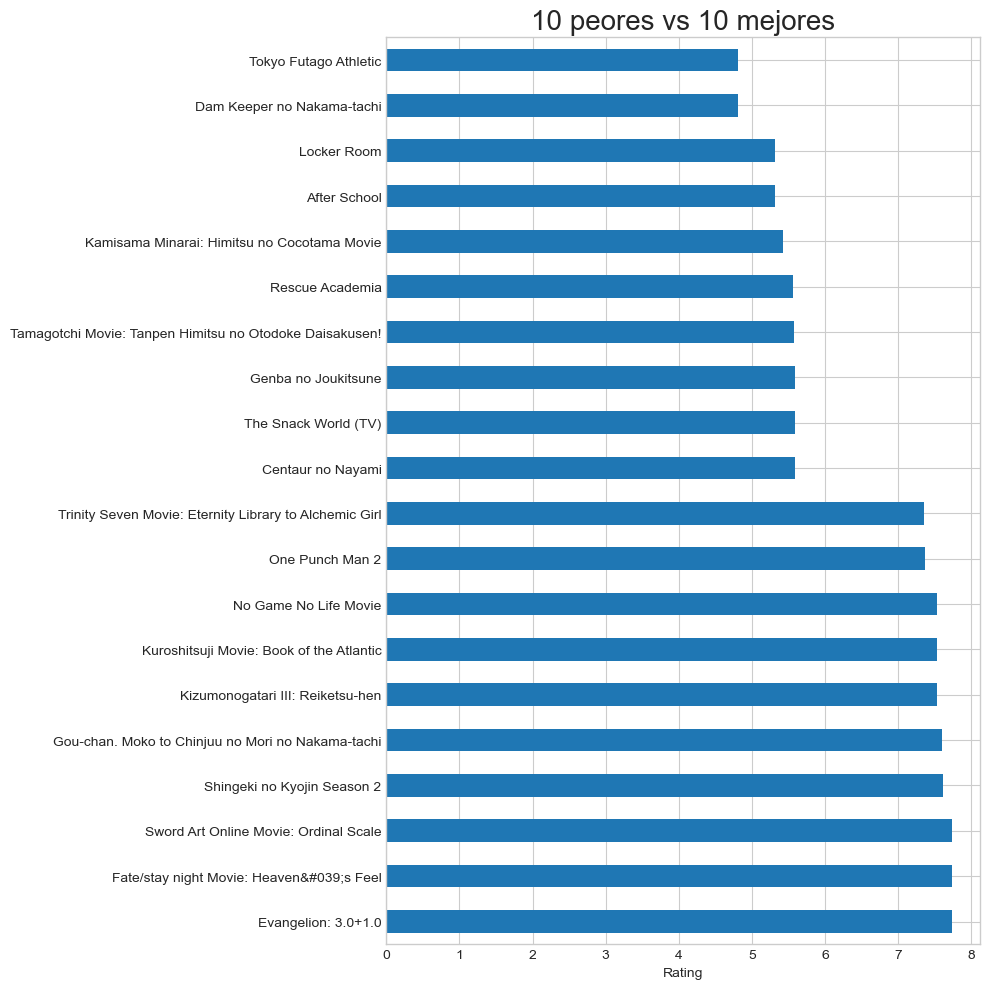

In [180]:
sorted_values = df_test_nulos[['name', 'rating_pred']].sort_values(by='rating_pred', ascending=False)
sorted_values_headtails = pd.concat([sorted_values.head(10), sorted_values.tail(10)])
y_label = sorted_values_headtails['name'].values

num_bars = len(sorted_values_headtails)
fig_height = num_bars * 0.5  # Tamaño de cada barra multiplicado por el número de barras

fig, ax = plt.subplots(figsize=(10, fig_height))
ax.barh(y_label, sorted_values_headtails['rating_pred'], height=0.5)
ax.set_xlabel('Rating')
ax.set_ylabel('')

plt.title('10 peores vs 10 mejores', fontsize=20)
plt.tight_layout()

ax.set_ylim(-0.5, num_bars - 0.5)

# Guardar la figura con fondo transparente
plt.savefig('imagen_top10.png', transparent=True)
plt.show()


## <span style="color:#87CEEB"> **11.- Solicitud adicional**

### <span style="color:#87CEEB"> 11.1.- Árbol de decisiones

    Adicionalmente se solicitó graficar un árbol de decisiones.
    Los pasos realizados para este proceso se muestran a continuación:

#### <span style="color:#87CEEB"> 11.1.1.- Árbol nro 1

In [181]:
# dataset utilizado
df_sqrt_jerarquia_modelacion.head()

type_recod  episodes     members    rating  Action  Action, Adventure  \
0           4  1.000500  447.917404  3.061209       0                  0   
1           1  8.000062  890.878780  3.043189       0                  0   
2           1  7.141498  338.026628  3.041546       0                  0   
3           1  4.899082  820.714324  3.028366       0                  0   
4           1  7.141498  388.929301  3.026714       0                  0   

   Action, Adventure, Cars, Comedy, Sci-Fi, Shounen  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   Action, Adventure, Cars, Sci-Fi  Action, Adventure, Comedy  ...  \
0                                0                          0  ...   
1                                0                          0  ...   
2                                0                          0  ...   
3                                0                          0  ...   
4                                0                          0  ...   

   Slice of Life  Slice of Life, Space  Slice of Life, Supernatural  Space  \
0              0                     0                            0      0   
1              0                     0                            0      0   
2              0                     0                            0      0   
3              0                     0                            0      0   
4              0                     0                            0      0   

   Sports  Super Power, Supernatural, Vampire  Supernatural  Thriller  \
0       0                                   0             0         0   
1       0                                   0             0         0   
2       0                                   0             0         0   
3       0                                   0             0         0   
4       0                                   0             0         0   

   Vampire  Yaoi  
0        0     0  
1        0     0  
2        0     0  
3        0     0  
4        0     0  

[5 rows x 3233 columns]

In [182]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [183]:
# matriz de atributos y vector objetivo
X = df_sqrt_jerarquia_modelacion.drop(columns=['rating'], axis=1)
y = df_sqrt_jerarquia_modelacion['rating']

# muestras de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=10)

# Crea una instancia del modelo de árbol de decisión
model_tree = DecisionTreeRegressor(max_depth=3, criterion='absolute_error', random_state=10)

# Entrena el modelo utilizando los datos
model_tree.fit(X_train, np.square(y_train)-0.001)

DecisionTreeRegressor(criterion='absolute_error', max_depth=3, random_state=10)

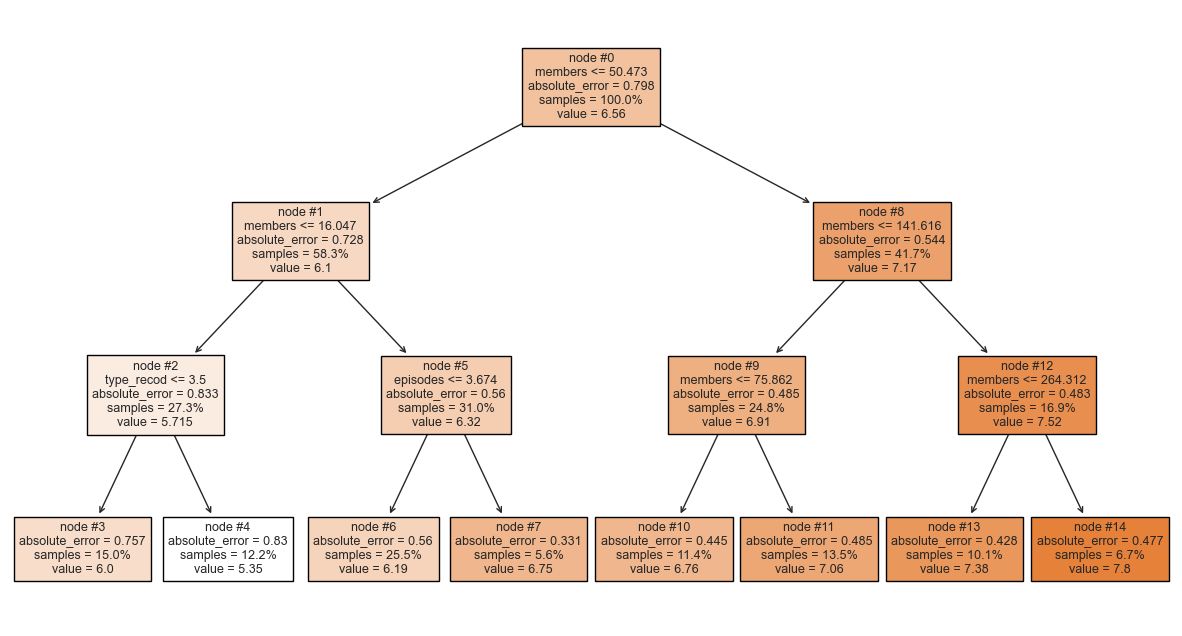

In [184]:
plt.subplots(figsize=(15,8))
tree.plot_tree(model_tree, max_depth=4, feature_names=X.columns, filled=True,
                proportion=True, node_ids=True, fontsize=9)
plt.show() 

#### <span style="color:#87CEEB"> 11.1.2.- Árbol nro 2

In [185]:
X = df_sqrt_jerarquia_modelacion.drop(columns=['episodes','members','rating'], axis=1)
y = df_sqrt_jerarquia_modelacion['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=10)

# Crea una instancia del modelo de árbol de decisión
model_tree = DecisionTreeRegressor(max_depth=3, criterion='absolute_error', random_state=10)

# Entrena el modelo utilizando los datos
model_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=3, random_state=10)

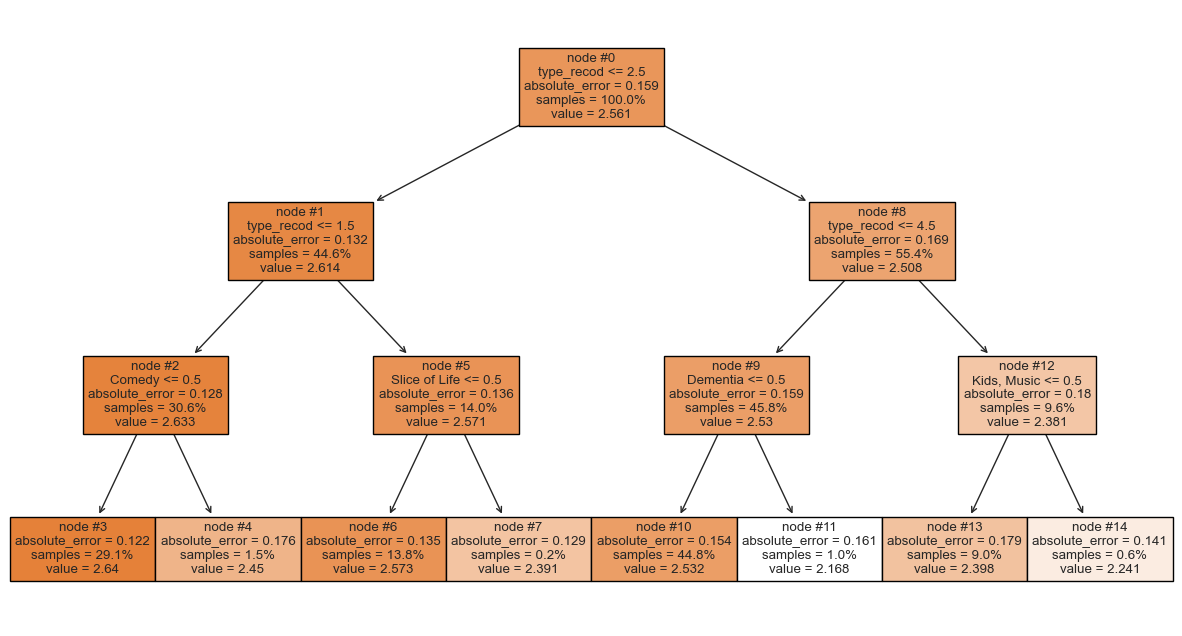

In [186]:
plt.subplots(figsize=(15, 8))
tree.plot_tree(model_tree, max_depth=3, feature_names=X.columns, filled=True, proportion=True, node_ids=True)
plt.show()

### <span style="color:#87CEEB"> 11.2.- Regresión lineal acotando valores extremos

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [188]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

LinearRegression()

In [189]:
# predicciones
y_hat = model_linear.predict(X_test)

# Devolviendo el cambio que se hace al escalar.
y_hat = y_hat + 0.001
y_hat = np.square(y_hat)

# Los valores mayores a 10 seran llevados a 10. No existen valores menores a 0 por lo tanto el limite inferior se deja igual.
y_hat = np.clip(y_hat, None, 10)

# Calculo de métricas
mae = mean_absolute_error(y_test, y_hat)
mape = mean_absolute_percentage_error(y_test, y_hat)
rsquare = r2_score(y_test, y_hat)

print("MAE:", mae)
print("MAPE:", mape)
print("R-square:", rsquare)

MAE: 4.565247723760423
MAPE: 1.7983625977066524
R-square: -532.8239928326849


### <span style="color:#87CEEB"> 11.3.- Matriz sin variables 'episodes' ni 'members'

In [233]:
df_sqrt_jerarquia_genre_modelacion = df_sqrt_jerarquia_modelacion.drop(columns=['members'])

# matriz de atributos
X = df_sqrt_jerarquia_genre_modelacion.drop(columns='rating', axis=1)

# vector objetivo
y = df_sqrt_jerarquia_genre_modelacion['rating']

##### <span style="color:orange"> Grilla del mejor modelo

``` python
# Grilla hiperparámetros
param_grid_gboost = {
    'n_estimators': [1, 10, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5, 1, 5, 10],
    'subsample': np.linspace(0.1, 1.0, 10, endpoint=True, dtype=float),
}

# Guardado Grilla
grid_gboost = GridSearchCV(GradientBoostingRegressor(random_state=10),
                            param_grid=param_grid_gboost,
                            cv=5,
                            verbose=1,
                            n_jobs=-1)
```

In [234]:
# Entrenamiento modelo
modelacion_gboost_genre = probar_modelos(grid_gboost, X, y, test_size=.3, random_state=10, imprime=True, gen_modelacion=True)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1, 5, 10],
                         'n_estimators': [1, 10, 50, 100],
                         'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             verbose=1) 
 Métricas en train:
 MAPE train: 0.05125466342798241 
 MAE train: 0.12550557450938152 
 R2 train: 0.4024233868210202 
 -------------------------------------------------- 
Métricas en test:
 MAPE test: 0.0542552507090176 
 MAE test: 0.13278092646155656 
 R2 test: 0.3034838075172942 
 --------------------------------------------------


In [235]:
modelo_genre = {'modelo_genre':modelacion_gboost_genre}
display(metricas_transformacion_inversa(modelo_genre))

MAPE train  MAE train  R2 train  MAPE test  MAE test   R2 test
modelo_genre    0.051255   0.627948  0.402423   0.054255  0.664798  0.303484

##### <span style="color:orange"> Gráfico de importancia de variables

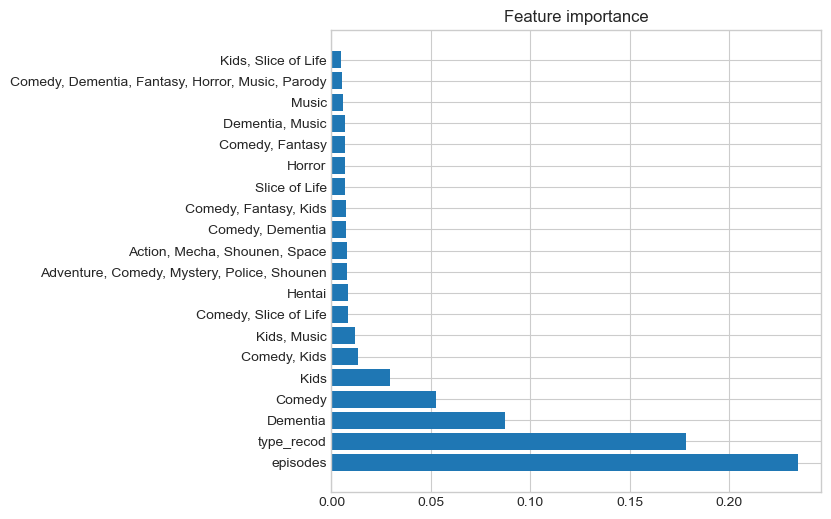

In [236]:
graficar_importancia(modelacion_gboost_genre['modelo_fit'].best_estimator_, X.columns, nro_a_imprimir=20);
plt.savefig('imagen_feature_importance_drop_members_episodes.png', bbox_inches='tight', transparent=True) 